# Prediction Assignment BIOS 624

## Q1 - Develop a predictive model for mortality

Solution: deep learning for tabular data

### Notes & explanations

Some of the columns are continuous (like age) and we will treat them as float numbers we can feed our model directly. Others are categorical and we will convert them to a unique index that we will feed to embedding layers.

The last part is the list of pre-processors we apply to our data:

- Categorify is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
- FillMissing will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
- Normalize will normalize the continuous variables (substract the mean and divide by the std)

### Set-up

In [1]:
# loading necessary libraries
from fastai.tabular.all import *
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import scipy.stats

In [2]:
# reading in data
df = pd.read_table('mri with variable names.dat', delimiter=" ")

In [3]:
# exploring data
df.head()

,ptid,age,male,weight,height,packyrs,yrsquit,alcoh,physact,chf,...,sbp,aai,fev,dsst,vent,whgrd,numinf,volinf,obstime,death
1,1,72,1,173,169,54.0,0,0.00,9.8,0,...,139,1.03,1.28,25,2,2,1,7.46,2126,0
2,2,82,0,139,170,0.0,0,0.25,0.7,0,...,146,1.11,2.55,51,4,2,3,0.14,1841,0
3,3,89,1,145,170,0.0,0,1.25,1.6,0,...,134,1.01,2.38,27,4,1,2,0.18,1875,0
4,4,72,1,190,181,33.0,17,9.50,3.5,0,...,147,0.98,2.69,43,3,2,1,0.04,1897,0
5,5,70,0,153,158,0.0,0,0.25,0.7,0,...,117,0.94,2.03,48,2,1,0,0.00,2107,0


In [4]:
# removing participants censored before 5 years 
df = df.drop(df[(df['obstime']<5*365) & (df['death']==0)].index)

In [5]:
# deleting columns irrelevant for question to be answered
del df['ptid']
del df['obstime']

In [6]:
# checking column names and types
df.dtypes

age          int64
male         int64
weight       int64
height       int64
packyrs     object
yrsquit      int64
alcoh      float64
physact    float64
chf          int64
chd          int64
stroke       int64
diabete      int64
genhlth      int64
ldl         object
alb         object
crt         object
plt         object
sbp          int64
aai         object
fev         object
dsst        object
vent         int64
whgrd        int64
numinf      object
volinf      object
death        int64
dtype: object

In [7]:
# imputing missing values using median
df = df.replace(r'^[.]$', np.nan, regex=True)
df = df.fillna(df.median())

In [8]:
# making sure all categorical columns are set to the correct type
cat_cols = ['male', 'chf', 'chd', 'stroke', 'diabete', 'genhlth', 'vent', 'whgrd', 'numinf']
df[cat_cols] = df[cat_cols].astype('int')
df[cat_cols] = df[cat_cols].astype('object')

In [9]:
# making sure all continuous columns are set to the correct type
num_cols = ['age', 'weight', 'height', 'packyrs', 'yrsquit', 'alcoh', 'physact', 'ldl', 'alb', 'crt', 'plt', 'sbp', 'aai', 'fev', 'dsst', 'volinf']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='raise')

In [10]:
# instantiating metrics
Recall = Recall()
Precision = Precision()
RocAucBinary = RocAucBinary()

In [11]:
# creating function to calculate single sample CI
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

### Single model build

In [12]:
# building tabular object for base model
base_object = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                            cat_names = ['male', 'chf', 'chd', 'stroke', 'diabete', 'vent', 'whgrd', 'numinf'],
                            cont_names = ['age', 'weight', 'height', 'packyrs', 'yrsquit', 'alcoh', 'physact', 'ldl', 'alb', 'crt', 'plt', 'sbp', 'aai', 'fev', 'dsst', 'volinf'],
                            y_names='death',
                            y_block=CategoryBlock,
                            splits=RandomSplitter(valid_pct=0.3, seed=5)(range_of(df)))

In [13]:
# building data_loader
base_dls = base_object.dataloaders(bs=64)

In [14]:
# view processed data
base_dls.show_batch()

,male,chf,chd,stroke,diabete,vent,whgrd,numinf,age,weight,height,packyrs,yrsquit,alcoh,physact,ldl,alb,crt,plt,sbp,aai,fev,dsst,volinf,death
0,0,1,0,0,0,3,2,0,69.0,184.000000,162.000000,-5.950885e-07,2.687717e-07,6.438175e-08,1.1,142.000000,3.9,0.7,275.000001,137.000000,1.13,1.58,41.000000,-5.396462e-08,0
1,0,0,0,0,0,4,6,2,69.0,137.000000,149.999999,4.300000e+01,4.000000e+00,7.250000e+00,1.3,208.000000,4.0,0.7,364.999998,125.000000,0.74,1.58,54.000000,2.630000e+00,0
2,1,0,0,0,0,2,0,0,73.0,162.000000,167.000000,-5.950885e-07,2.687717e-07,6.438175e-08,6.8,74.999999,3.8,0.8,117.000001,143.000000,1.10,0.59,53.000000,-5.396462e-08,0
3,0,0,0,1,0,3,6,0,70.0,146.000000,170.000000,-5.950885e-07,2.687717e-07,5.100000e-01,1.2,115.000000,3.7,1.1,431.999995,120.000000,1.05,2.46,52.000000,-5.396462e-08,0
4,1,0,2,2,0,3,2,1,73.0,147.000000,170.000000,2.500000e+01,2.800000e+01,6.438175e-08,4.6,135.000000,4.3,1.6,279.999998,94.999999,1.23,2.71,50.000000,4.470000e+00,0
5,1,0,1,2,0,3,4,3,78.0,178.000000,161.000000,-5.950885e-07,2.687717e-07,6.438175e-08,2.4,90.000001,3.7,1.0,186.000001,186.000000,1.24,2.14,22.000000,-5.396462e-08,0
6,0,0,2,0,0,1,2,3,71.0,153.000000,165.000000,-5.950885e-07,2.687717e-07,7.500001e-01,2.1,247.000004,4.2,0.7,308.999998,117.000000,1.11,2.36,43.000000,4.800000e-01,0
7,0,0,0,0,0,3,2,0,74.0,137.000000,155.000000,1.400000e+01,1.900000e+01,1.400000e+01,0.2,205.999999,4.1,0.8,302.000000,151.000000,1.20,1.51,35.000000,-5.396462e-08,0
8,0,0,0,0,0,4,1,0,71.0,139.000001,151.000000,3.650000e+01,2.687717e-07,6.438175e-08,2.0,154.999999,4.3,0.8,319.000001,114.999999,1.10,2.05,57.000001,-5.396462e-08,0
9,0,0,1,1,0,5,1,0,78.0,111.000001,168.000000,3.050000e+01,2.687717e-07,7.000000e+00,0.7,96.000000,4.4,1.0,207.000000,185.000002,0.65,1.64,33.000000,-5.396462e-08,0


In [15]:
# build learner
base_learn = tabular_learner(base_dls, metrics=[accuracy, error_rate, Recall, Precision, RocAucBinary])

In [16]:
# training learner for 10 epochs
base_learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,roc_auc_score,time
0,0.750095,0.700577,0.431818,0.568182,0.675000,0.194245,0.538333,00:00
1,0.695497,0.636132,0.809091,0.190909,0.400000,0.470588,0.745278,00:00
2,0.612900,0.521272,0.827273,0.172727,0.225000,0.562500,0.765694,00:00
3,0.540537,0.444642,0.827273,0.172727,0.125000,0.625000,0.764306,00:00
4,0.484902,0.416368,0.822727,0.177273,0.125000,0.555556,0.760000,00:00
5,0.443552,0.407581,0.818182,0.181818,0.125000,0.500000,0.760278,00:00
6,0.407923,0.405311,0.827273,0.172727,0.200000,0.571429,0.759306,00:00
7,0.381366,0.404872,0.827273,0.172727,0.225000,0.562500,0.755417,00:00
8,0.360462,0.406147,0.813636,0.186364,0.150000,0.461538,0.751806,00:00
9,0.342913,0.409579,0.809091,0.190909,0.150000,0.428571,0.747639,00:00


In [17]:
# showing snapshot of predictions
base_learn.show_results()

,male,chf,chd,stroke,diabete,vent,whgrd,numinf,age,weight,height,packyrs,yrsquit,alcoh,physact,ldl,alb,crt,plt,sbp,aai,fev,dsst,volinf,death,death_pred
0,2.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.175889,-1.202648,1.129398,-0.732865,-0.681327,-0.426171,-0.875024,-0.788607,1.520205,-0.232241,-1.627012,0.598975,0.628652,-1.432006,-0.411943,-0.186610,0.0,0.0
1,2.0,1.0,1.0,3.0,1.0,3.0,4.0,1.0,0.049223,0.778154,0.401438,-0.569354,1.025789,-0.224762,-0.592404,1.042949,-0.005927,0.810818,-0.878550,2.694988,-1.976280,1.129589,-0.653756,-0.186610,0.0,0.0
2,2.0,1.0,2.0,1.0,1.0,5.0,4.0,1.0,0.049223,0.679114,2.273334,-0.187830,1.310309,0.072366,-0.215578,-0.699984,-1.913592,0.810818,-1.122946,0.956831,0.309680,0.707680,-0.895569,-0.186610,0.0,0.0
3,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,-1.265220,-0.047180,0.297444,-0.732865,-0.681327,-0.426171,1.103315,0.038547,-0.005927,-0.232241,-0.786901,-0.474594,-0.753557,1.566567,0.394100,-0.186610,0.0,0.0
4,2.0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,0.800334,1.141301,1.649369,0.575218,0.527880,-0.426171,-0.403991,-0.729525,1.520205,-0.232241,-0.954923,-0.065615,0.203357,-0.377232,-1.540403,-0.186610,0.0,0.0
5,1.0,1.0,1.0,3.0,1.0,6.0,3.0,3.0,2.302554,-1.103608,-0.534510,-0.732865,-0.681327,-0.426171,-0.733714,0.422583,-1.532060,1.506190,1.962552,-0.474594,-1.976280,-1.205983,-0.089526,-0.167419,1.0,0.0
6,1.0,1.0,1.0,1.0,1.0,5.0,5.0,1.0,-0.889665,-0.740461,-0.326522,0.647889,0.029971,0.022513,-0.875024,0.097630,-3.058191,-1.275299,1.152991,-0.167860,-0.859881,-0.106004,1.361352,-0.186610,0.0,0.0
7,2.0,1.0,3.0,1.0,1.0,4.0,2.0,1.0,0.424778,0.018846,-0.430516,-0.732865,-0.681327,-0.326464,-0.875024,-0.315948,-1.150526,-0.232241,-0.649429,1.212442,-2.082604,-1.025164,0.313496,-0.186610,0.0,0.0
8,2.0,1.0,2.0,1.0,1.0,4.0,3.0,2.0,2.114777,0.877194,0.089455,-0.732865,-0.681327,-0.426171,-0.027164,-0.050077,0.375605,0.810818,0.389254,-0.474594,-3.624298,0.391247,-1.782216,-0.184352,0.0,1.0


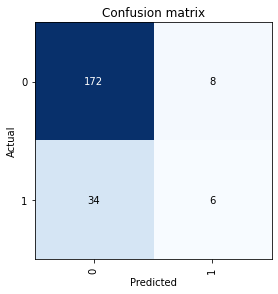

In [18]:
# plotting confusion matrix
interp = ClassificationInterpretation.from_learner(base_learn)
interp.plot_confusion_matrix()

### Investigation of over-fitting: calculating optimism

To repeat 200 times:
- Take a bootstrap sample
- Train a DL model on that bootstrap sample
- Test the model in the original data
- Get model performance on the bootstrap sample
- Get model performance on the original data
- Calculate bootstrap perf - original perf

In [19]:
# creating lists for metrics
optimism = L()

# shortening for-loop
cat_names = ['male', 'chf', 'chd', 'stroke', 'diabete', 'vent', 'whgrd', 'numinf']
cont_names = ['age', 'weight', 'height', 'packyrs', 'yrsquit', 'alcoh', 'physact', 'ldl', 'alb', 'crt', 'plt', 'sbp', 'aai', 'fev', 'dsst', 'volinf']
procs = [Categorify, FillMissing, Normalize]
metrics = RocAucBinary

# repeating optimism calculation i times
for i in range(200):
    # concatenating training set (bootstrap sample) & val sets
    df_train = resample(df)
    df_final = pd.concat([df_train, df], axis=0, sort=False, ignore_index=True)
    train_idx = range(0,len(df_train))
    valid_idx = range(len(df_train)+1, len(df_final))
    splits = (L(list(train_idx)), L(list(valid_idx)))
      
    # building model
    to = TabularPandas(df_final, procs, cat_names, cont_names, y_names="death", y_block=CategoryBlock, splits=splits)
    data = to.dataloaders()
    learn = tabular_learner(data, layers=[200, 100], loss_func=CrossEntropyLossFlat(), metrics=metrics)
    learn.fit(10)
    
    # getting preds on training set
    test_dl = learn.dls.test_dl(df_train)
    tst_preds = learn.get_preds(dl=test_dl)
    
    # calculating optimism
    optimism.append(roc_auc_score(df_train["death"], tst_preds[1]) - learn.validate()[1])
    
    

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.546987,0.559928,0.757184,00:00
1,0.439746,0.437657,0.766580,00:00
2,0.376053,0.397569,0.776763,00:00
3,0.330138,0.382547,0.793027,00:00
4,0.291438,0.370365,0.807664,00:00
5,0.258171,0.345435,0.835762,00:00
6,0.229125,0.318848,0.858669,00:00
7,0.201541,0.298299,0.869178,00:00
8,0.177189,0.293564,0.871367,00:00
9,0.155172,0.305488,0.867889,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.517887,0.570694,0.732438,00:00
1,0.424481,0.443339,0.768644,00:00
2,0.369527,0.395317,0.785908,00:00
3,0.328856,0.383753,0.794515,00:00
4,0.294939,0.368160,0.811117,00:00
5,0.264582,0.342523,0.838840,00:00
6,0.237038,0.310479,0.868703,00:00
7,0.210436,0.285472,0.884266,00:00
8,0.188053,0.276043,0.890421,00:00
9,0.165969,0.276542,0.889945,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.553514,0.571293,0.762489,00:00
1,0.448014,0.431262,0.791075,00:00
2,0.389651,0.384760,0.799432,00:00
3,0.345638,0.370977,0.814370,00:00
4,0.313702,0.365684,0.827593,00:00
5,0.281977,0.346412,0.843306,00:00
6,0.255044,0.312180,0.873682,00:00
7,0.231146,0.289526,0.884804,00:00
8,0.205655,0.279450,0.881914,00:00
9,0.181809,0.279705,0.881588,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.498042,0.564514,0.771046,00:00
1,0.398289,0.428114,0.780454,00:00
2,0.337510,0.390146,0.785620,00:00
3,0.296017,0.384869,0.794215,00:00
4,0.262896,0.376849,0.808978,00:00
5,0.234487,0.350159,0.833123,00:00
6,0.213398,0.331154,0.854290,00:00
7,0.191728,0.317845,0.869766,00:00
8,0.171549,0.316336,0.874983,00:00
9,0.151699,0.334475,0.872593,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.560721,0.591321,0.666433,00:00
1,0.448889,0.472721,0.746663,00:00
2,0.390129,0.414446,0.769357,00:00
3,0.346632,0.390798,0.788235,00:00
4,0.311659,0.372789,0.804874,00:00
5,0.280332,0.362043,0.811930,00:00
6,0.251962,0.339382,0.833748,00:00
7,0.226466,0.325861,0.847585,00:00
8,0.203274,0.323568,0.855129,00:00
9,0.180440,0.335092,0.853265,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.528726,0.574247,0.767142,00:00
1,0.435984,0.444350,0.789198,00:00
2,0.386799,0.395085,0.795892,00:00
3,0.344783,0.375805,0.806651,00:00
4,0.313727,0.356175,0.826367,00:00
5,0.284177,0.330174,0.853765,00:00
6,0.256529,0.292155,0.884328,00:00
7,0.228289,0.258947,0.900254,00:00
8,0.202405,0.245477,0.903807,00:00
9,0.177717,0.233792,0.912427,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.554631,0.593679,0.743060,00:00
1,0.453207,0.459480,0.760012,00:00
2,0.400613,0.411105,0.762576,00:00
3,0.356538,0.393304,0.779590,00:00
4,0.325069,0.377004,0.803398,00:00
5,0.293739,0.346223,0.840579,00:00
6,0.265921,0.315911,0.865850,00:00
7,0.237619,0.288412,0.884303,00:00
8,0.214228,0.279967,0.894962,00:00
9,0.191284,0.261677,0.908648,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.533044,0.572886,0.772622,00:00
1,0.434783,0.429916,0.792751,00:00
2,0.377499,0.386483,0.798193,00:00
3,0.335724,0.376530,0.806363,00:00
4,0.302017,0.366698,0.821726,00:00
5,0.273913,0.342266,0.848348,00:00
6,0.246575,0.315442,0.876159,00:00
7,0.220221,0.285807,0.898165,00:00
8,0.195579,0.281857,0.904833,00:00
9,0.173803,0.265510,0.914428,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.567433,0.582775,0.792464,00:00
1,0.461982,0.448077,0.793827,00:00
2,0.403065,0.394437,0.791163,00:00
3,0.358495,0.374823,0.804123,00:00
4,0.317735,0.360172,0.820475,00:00
5,0.282430,0.330053,0.854666,00:00
6,0.251719,0.298043,0.883953,00:00
7,0.222153,0.269974,0.898165,00:00
8,0.197342,0.270582,0.896814,00:00
9,0.173174,0.289293,0.889795,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.626982,0.628979,0.779040,00:00
1,0.491190,0.469301,0.788173,00:00
2,0.408636,0.395853,0.795604,00:00
3,0.359119,0.387249,0.800270,00:00
4,0.321156,0.376887,0.811430,00:00
5,0.285596,0.343058,0.848698,00:00
6,0.254654,0.309092,0.878936,00:00
7,0.227349,0.290689,0.894011,00:00
8,0.203236,0.288514,0.895387,00:00
9,0.181744,0.283212,0.900254,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.516088,0.580461,0.768118,00:00
1,0.417857,0.437999,0.785608,00:00
2,0.364300,0.387786,0.796067,00:00
3,0.322857,0.372671,0.807764,00:00
4,0.287482,0.355345,0.827756,00:00
5,0.256749,0.332386,0.854878,00:00
6,0.224836,0.305008,0.876009,00:00
7,0.199863,0.286683,0.885542,00:00
8,0.175401,0.283216,0.887443,00:00
9,0.153058,0.285866,0.884716,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.507895,0.598059,0.726996,00:00
1,0.406597,0.451398,0.755758,00:00
2,0.349548,0.411792,0.763777,00:00
3,0.309638,0.404265,0.776350,00:00
4,0.275136,0.392686,0.793002,00:00
5,0.245991,0.360880,0.825666,00:00
6,0.220400,0.324398,0.861872,00:00
7,0.196706,0.307191,0.875033,00:00
8,0.174165,0.300169,0.882164,00:00
9,0.153397,0.283534,0.892360,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.508363,0.570080,0.757547,00:00
1,0.417035,0.433594,0.777288,00:00
2,0.363214,0.389778,0.784232,00:00
3,0.327130,0.380003,0.794828,00:00
4,0.293938,0.364865,0.810817,00:00
5,0.263784,0.340755,0.839303,00:00
6,0.236382,0.311019,0.866200,00:00
7,0.211293,0.270398,0.895550,00:00
8,0.188486,0.258711,0.899103,00:00
9,0.166487,0.254429,0.906947,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.553493,0.586299,0.753519,00:00
1,0.454156,0.453060,0.798118,00:00
2,0.394939,0.392498,0.809716,00:00
3,0.351487,0.371575,0.820012,00:00
4,0.312299,0.352576,0.837276,00:00
5,0.279761,0.325871,0.862948,00:00
6,0.249359,0.295185,0.885216,00:00
7,0.221329,0.284360,0.885266,00:00
8,0.195419,0.284442,0.885817,00:00
9,0.171270,0.306194,0.876009,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.579442,0.603539,0.740658,00:00
1,0.458212,0.443176,0.770708,00:00
2,0.394855,0.387511,0.790274,00:00
3,0.349482,0.372025,0.809178,00:00
4,0.311811,0.358895,0.829407,00:00
5,0.280347,0.334997,0.854303,00:00
6,0.250506,0.305148,0.876884,00:00
7,0.226416,0.273561,0.895725,00:00
8,0.202970,0.259127,0.899316,00:00
9,0.180406,0.250025,0.902368,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.542205,0.579919,0.774674,00:00
1,0.437819,0.444685,0.792564,00:00
2,0.378569,0.389736,0.801709,00:00
3,0.334928,0.375748,0.807189,00:00
4,0.298681,0.360908,0.822414,00:00
5,0.266092,0.339643,0.845120,00:00
6,0.237718,0.309572,0.870179,00:00
7,0.214432,0.286377,0.882176,00:00
8,0.189105,0.275084,0.889970,00:00
9,0.167111,0.273385,0.889695,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.494319,0.572124,0.713485,00:00
1,0.396247,0.441163,0.766567,00:00
2,0.335834,0.395408,0.782243,00:00
3,0.294729,0.383109,0.791488,00:00
4,0.263882,0.370105,0.805762,00:00
5,0.233198,0.352405,0.826980,00:00
6,0.206843,0.327846,0.852076,00:00
7,0.184104,0.317255,0.859432,00:00
8,0.162737,0.324902,0.854303,00:00
9,0.143555,0.343088,0.849249,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.594519,0.583353,0.742372,00:00
1,0.466606,0.462407,0.770745,00:00
2,0.395743,0.404907,0.780291,00:00
3,0.350020,0.385301,0.794178,00:00
4,0.313737,0.368377,0.814495,00:00
5,0.281664,0.345199,0.841267,00:00
6,0.256557,0.321623,0.864762,00:00
7,0.229719,0.293123,0.882064,00:00
8,0.205580,0.285210,0.883690,00:00
9,0.182973,0.281489,0.886480,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.558300,0.586897,0.728961,00:00
1,0.440448,0.456197,0.767856,00:00
2,0.378091,0.400524,0.780779,00:00
3,0.331517,0.380530,0.795003,00:00
4,0.294600,0.366324,0.810316,00:00
5,0.262201,0.347426,0.834336,00:00
6,0.234972,0.326582,0.856580,00:00
7,0.207895,0.321164,0.863173,00:00
8,0.184415,0.306731,0.873194,00:00
9,0.164695,0.308971,0.877910,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.553541,0.579969,0.769194,00:00
1,0.444507,0.441680,0.787472,00:00
2,0.378762,0.387890,0.794515,00:00
3,0.335010,0.372654,0.806363,00:00
4,0.300246,0.360246,0.825179,00:00
5,0.267573,0.337210,0.851100,00:00
6,0.237790,0.308083,0.876346,00:00
7,0.212589,0.284988,0.895162,00:00
8,0.188833,0.281926,0.896013,00:00
9,0.165890,0.285821,0.892710,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.563692,0.558407,0.754770,00:00
1,0.462768,0.441455,0.777426,00:00
2,0.405968,0.393169,0.788936,00:00
3,0.360645,0.381641,0.798656,00:00
4,0.325193,0.366928,0.819461,00:00
5,0.289126,0.337865,0.854028,00:00
6,0.257734,0.307410,0.883765,00:00
7,0.227270,0.269456,0.904620,00:00
8,0.202206,0.251625,0.912277,00:00
9,0.178188,0.253026,0.916280,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.601290,0.604480,0.762238,00:00
1,0.499687,0.459677,0.779190,00:00
2,0.435976,0.405538,0.786546,00:00
3,0.387198,0.389873,0.795191,00:00
4,0.346223,0.368123,0.822314,00:00
5,0.310891,0.339106,0.854040,00:00
6,0.279039,0.299602,0.889583,00:00
7,0.246895,0.260714,0.911726,00:00
8,0.217727,0.247724,0.916255,00:00
9,0.189831,0.238864,0.920921,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.594077,0.622935,0.741233,00:00
1,0.479203,0.473764,0.773423,00:00
2,0.413041,0.400908,0.796942,00:00
3,0.367310,0.380103,0.810491,00:00
4,0.326338,0.364876,0.826280,00:00
5,0.292639,0.342316,0.849662,00:00
6,0.264725,0.314962,0.877623,00:00
7,0.236996,0.291842,0.891359,00:00
8,0.211186,0.296688,0.892998,00:00
9,0.187381,0.296157,0.896238,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.693121,0.638875,0.747764,00:00
1,0.529826,0.519949,0.745549,00:00
2,0.436172,0.443448,0.762726,00:00
3,0.377170,0.410842,0.782718,00:00
4,0.332762,0.396780,0.800095,00:00
5,0.292142,0.364451,0.831772,00:00
6,0.261006,0.334350,0.857906,00:00
7,0.233201,0.328686,0.864274,00:00
8,0.207319,0.322903,0.867939,00:00
9,0.183121,0.334826,0.861234,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.526703,0.583154,0.748727,00:00
1,0.441966,0.466392,0.775187,00:00
2,0.385260,0.412531,0.793752,00:00
3,0.338718,0.411853,0.800470,00:00
4,0.302063,0.398533,0.816184,00:00
5,0.269552,0.365287,0.846772,00:00
6,0.239514,0.342995,0.876084,00:00
7,0.213480,0.300444,0.896326,00:00
8,0.187810,0.294533,0.900529,00:00
9,0.165720,0.296730,0.902906,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.528125,0.558394,0.758110,00:00
1,0.437523,0.431494,0.783006,00:00
2,0.382155,0.386649,0.793002,00:00
3,0.341769,0.372352,0.803611,00:00
4,0.305622,0.361295,0.817097,00:00
5,0.271547,0.341631,0.839841,00:00
6,0.242557,0.311637,0.867852,00:00
7,0.212148,0.293570,0.879587,00:00
8,0.186392,0.293034,0.881426,00:00
9,0.163778,0.296447,0.880300,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.501123,0.562775,0.767668,00:00
1,0.404837,0.435740,0.777151,00:00
2,0.345861,0.391061,0.780891,00:00
3,0.312437,0.383162,0.786846,00:00
4,0.277602,0.369947,0.806138,00:00
5,0.247690,0.349283,0.831922,00:00
6,0.223727,0.320830,0.865062,00:00
7,0.197852,0.299958,0.881688,00:00
8,0.174539,0.293513,0.887181,00:00
9,0.153938,0.296649,0.890746,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.564028,0.592412,0.744649,00:00
1,0.450928,0.460561,0.778840,00:00
2,0.387552,0.401344,0.793364,00:00
3,0.344558,0.384557,0.804624,00:00
4,0.310966,0.369312,0.823665,00:00
5,0.277521,0.339702,0.851501,00:00
6,0.249289,0.302816,0.876484,00:00
7,0.220147,0.275865,0.892172,00:00
8,0.196014,0.270408,0.897915,00:00
9,0.173927,0.262907,0.904545,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.543090,0.580743,0.771796,00:00
1,0.446191,0.439797,0.792101,00:00
2,0.388231,0.391048,0.804887,00:00
3,0.344660,0.374212,0.813669,00:00
4,0.310256,0.361998,0.829069,00:00
5,0.278970,0.337587,0.855041,00:00
6,0.251707,0.301830,0.879512,00:00
7,0.223463,0.277974,0.895600,00:00
8,0.198231,0.272936,0.898115,00:00
9,0.173273,0.270480,0.901330,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.493446,0.542215,0.741696,00:00
1,0.409636,0.428438,0.769219,00:00
2,0.361959,0.390387,0.786671,00:00
3,0.324050,0.378533,0.797505,00:00
4,0.287723,0.365802,0.814958,00:00
5,0.253685,0.349610,0.839628,00:00
6,0.226117,0.305781,0.872468,00:00
7,0.198253,0.280445,0.890058,00:00
8,0.172145,0.268917,0.895450,00:00
9,0.149557,0.272145,0.899628,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.546361,0.595879,0.751967,00:00
1,0.439783,0.460655,0.775499,00:00
2,0.379675,0.402998,0.787672,00:00
3,0.334636,0.386660,0.796179,00:00
4,0.298965,0.364204,0.822276,00:00
5,0.268437,0.346080,0.842368,00:00
6,0.241975,0.317050,0.868152,00:00
7,0.216038,0.300227,0.881238,00:00
8,0.191342,0.293610,0.890683,00:00
9,0.169655,0.304152,0.887831,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.515661,0.573805,0.725683,00:00
1,0.419165,0.458887,0.748602,00:00
2,0.365272,0.411143,0.766642,00:00
3,0.326775,0.395582,0.774786,00:00
4,0.294114,0.379951,0.801421,00:00
5,0.265550,0.347929,0.841818,00:00
6,0.235984,0.312210,0.871367,00:00
7,0.211621,0.282368,0.888344,00:00
8,0.187188,0.268391,0.894111,00:00
9,0.167693,0.270407,0.894812,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.595614,0.605707,0.729561,00:00
1,0.481044,0.480877,0.734903,00:00
2,0.417645,0.427168,0.747801,00:00
3,0.376371,0.409017,0.762926,00:00
4,0.339078,0.392409,0.783907,00:00
5,0.305402,0.363512,0.824953,00:00
6,0.276012,0.323125,0.869841,00:00
7,0.247192,0.290067,0.891422,00:00
8,0.220364,0.276676,0.896000,00:00
9,0.194099,0.263614,0.908786,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.535295,0.575486,0.783056,00:00
1,0.429592,0.438146,0.787922,00:00
2,0.371654,0.392585,0.793214,00:00
3,0.331332,0.375912,0.807751,00:00
4,0.298568,0.364441,0.818761,00:00
5,0.268894,0.336782,0.853490,00:00
6,0.245949,0.311758,0.878060,00:00
7,0.221011,0.288255,0.892147,00:00
8,0.197949,0.284096,0.895625,00:00
9,0.176736,0.288987,0.898352,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.528126,0.584728,0.760412,00:00
1,0.436454,0.457667,0.779978,00:00
2,0.385890,0.397895,0.795979,00:00
3,0.341517,0.379344,0.809591,00:00
4,0.306132,0.361455,0.828069,00:00
5,0.270696,0.334388,0.855416,00:00
6,0.237336,0.299966,0.885792,00:00
7,0.208978,0.273162,0.895888,00:00
8,0.183548,0.263785,0.902243,00:00
9,0.160792,0.270521,0.900592,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.557002,0.605236,0.751429,00:00
1,0.444279,0.459925,0.778877,00:00
2,0.378420,0.397476,0.788573,00:00
3,0.332333,0.379779,0.797993,00:00
4,0.294909,0.364480,0.816922,00:00
5,0.264798,0.341534,0.847222,00:00
6,0.236672,0.314832,0.874270,00:00
7,0.210682,0.285934,0.895187,00:00
8,0.187041,0.285420,0.891772,00:00
9,0.164146,0.302749,0.883177,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.559344,0.609613,0.750479,00:00
1,0.448090,0.446162,0.770533,00:00
2,0.387002,0.389138,0.785558,00:00
3,0.340399,0.376518,0.795791,00:00
4,0.302211,0.366271,0.811254,00:00
5,0.271727,0.351041,0.831359,00:00
6,0.240888,0.316569,0.865537,00:00
7,0.214337,0.294209,0.878623,00:00
8,0.188666,0.280811,0.884178,00:00
9,0.165709,0.287577,0.882276,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.540387,0.592357,0.739294,00:00
1,0.433575,0.478037,0.758348,00:00
2,0.376776,0.424849,0.769357,00:00
3,0.335466,0.398935,0.792051,00:00
4,0.298359,0.381789,0.807676,00:00
5,0.267581,0.357799,0.830908,00:00
6,0.240220,0.326884,0.853527,00:00
7,0.215162,0.304002,0.868615,00:00
8,0.192176,0.301376,0.869078,00:00
9,0.171386,0.302256,0.865938,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.504703,0.549022,0.764077,00:00
1,0.409784,0.430693,0.782968,00:00
2,0.353796,0.383755,0.793377,00:00
3,0.309792,0.375443,0.801709,00:00
4,0.274971,0.362846,0.818811,00:00
5,0.244993,0.340227,0.842155,00:00
6,0.217171,0.313354,0.865925,00:00
7,0.189451,0.309313,0.869453,00:00
8,0.167881,0.310741,0.872806,00:00
9,0.144715,0.323124,0.871442,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.534512,0.567776,0.758110,00:00
1,0.440430,0.443887,0.783193,00:00
2,0.378934,0.390624,0.793965,00:00
3,0.335004,0.379850,0.798794,00:00
4,0.301853,0.363685,0.819949,00:00
5,0.269386,0.329591,0.859320,00:00
6,0.242427,0.295302,0.892623,00:00
7,0.218064,0.268573,0.912176,00:00
8,0.192863,0.254581,0.921121,00:00
9,0.171068,0.256040,0.922623,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.632762,0.609082,0.734428,00:00
1,0.505335,0.481460,0.766617,00:00
2,0.428820,0.415834,0.788010,00:00
3,0.377711,0.393503,0.800608,00:00
4,0.336771,0.379172,0.818123,00:00
5,0.303036,0.349417,0.847735,00:00
6,0.270308,0.304738,0.882839,00:00
7,0.239654,0.280400,0.893273,00:00
8,0.212851,0.271432,0.898553,00:00
9,0.186832,0.270316,0.900617,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.562494,0.572522,0.690040,00:00
1,0.436155,0.450673,0.747163,00:00
2,0.367387,0.404233,0.765554,00:00
3,0.322070,0.389821,0.779378,00:00
4,0.287747,0.384364,0.789098,00:00
5,0.260106,0.364023,0.816096,00:00
6,0.234462,0.334045,0.848448,00:00
7,0.212293,0.319130,0.862072,00:00
8,0.191675,0.316240,0.862723,00:00
9,0.173236,0.313769,0.868765,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.551726,0.599452,0.725745,00:00
1,0.447529,0.468150,0.758260,00:00
2,0.390047,0.409307,0.775937,00:00
3,0.344873,0.399537,0.784207,00:00
4,0.308219,0.382971,0.804199,00:00
5,0.276457,0.358079,0.833248,00:00
6,0.249447,0.330141,0.859833,00:00
7,0.224465,0.304613,0.875208,00:00
8,0.200316,0.296825,0.881839,00:00
9,0.177997,0.304094,0.878473,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.475248,0.550957,0.775299,00:00
1,0.391700,0.430388,0.785833,00:00
2,0.347162,0.389560,0.792676,00:00
3,0.310054,0.374299,0.807676,00:00
4,0.274421,0.357761,0.827693,00:00
5,0.244791,0.333068,0.856442,00:00
6,0.218278,0.303307,0.884503,00:00
7,0.192198,0.285342,0.894687,00:00
8,0.170000,0.292211,0.889432,00:00
9,0.151824,0.300212,0.894086,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.519751,0.590698,0.784839,00:00
1,0.423707,0.429203,0.798106,00:00
2,0.366442,0.380410,0.808027,00:00
3,0.320077,0.362090,0.821751,00:00
4,0.281950,0.347994,0.836676,00:00
5,0.252264,0.328315,0.858832,00:00
6,0.223727,0.303777,0.881688,00:00
7,0.198204,0.295938,0.890371,00:00
8,0.174163,0.293268,0.895112,00:00
9,0.152605,0.309932,0.891146,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.536456,0.577875,0.731925,00:00
1,0.432108,0.442672,0.789186,00:00
2,0.375051,0.390316,0.802972,00:00
3,0.335093,0.375050,0.813056,00:00
4,0.297869,0.358223,0.832647,00:00
5,0.270116,0.336559,0.853727,00:00
6,0.241180,0.309694,0.874420,00:00
7,0.216669,0.288735,0.886655,00:00
8,0.195599,0.288289,0.884478,00:00
9,0.173006,0.292548,0.877798,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.596524,0.606579,0.749628,00:00
1,0.480048,0.455454,0.769645,00:00
2,0.419104,0.396817,0.780741,00:00
3,0.372107,0.379750,0.795191,00:00
4,0.335035,0.365113,0.813056,00:00
5,0.303435,0.347132,0.834236,00:00
6,0.271843,0.305798,0.880625,00:00
7,0.243727,0.275437,0.900291,00:00
8,0.217187,0.262170,0.910362,00:00
9,0.193850,0.261032,0.908086,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.557933,0.591211,0.770283,00:00
1,0.452205,0.435454,0.780016,00:00
2,0.393980,0.388528,0.790525,00:00
3,0.350372,0.376997,0.798819,00:00
4,0.314738,0.369864,0.807664,00:00
5,0.284700,0.351209,0.832435,00:00
6,0.257709,0.317872,0.867702,00:00
7,0.233477,0.277695,0.900191,00:00
8,0.211285,0.262415,0.905233,00:00
9,0.187640,0.252618,0.909036,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.584595,0.593553,0.722405,00:00
1,0.469848,0.465896,0.752080,00:00
2,0.403572,0.410300,0.765178,00:00
3,0.356056,0.393970,0.779140,00:00
4,0.317866,0.393322,0.779590,00:00
5,0.285677,0.379285,0.801446,00:00
6,0.258252,0.339113,0.852552,00:00
7,0.231855,0.314243,0.869778,00:00
8,0.204403,0.301235,0.875646,00:00
9,0.181340,0.302979,0.872956,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.586851,0.622466,0.712096,00:00
1,0.466497,0.481668,0.747263,00:00
2,0.399100,0.416991,0.762351,00:00
3,0.355766,0.393632,0.778327,00:00
4,0.317859,0.385705,0.791113,00:00
5,0.285726,0.359186,0.825629,00:00
6,0.258035,0.316896,0.867852,00:00
7,0.229247,0.295122,0.878273,00:00
8,0.204039,0.288745,0.883690,00:00
9,0.180901,0.291969,0.883803,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.610815,0.597146,0.743473,00:00
1,0.481130,0.462570,0.783957,00:00
2,0.410856,0.397447,0.794603,00:00
3,0.361864,0.376867,0.803823,00:00
4,0.327663,0.363318,0.822489,00:00
5,0.292680,0.341905,0.849224,00:00
6,0.262385,0.315802,0.877385,00:00
7,0.234145,0.300697,0.884703,00:00
8,0.206958,0.301783,0.883390,00:00
9,0.181776,0.301465,0.884728,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.562442,0.583718,0.756246,00:00
1,0.440866,0.446879,0.767743,00:00
2,0.370797,0.398471,0.772022,00:00
3,0.321265,0.387260,0.780504,00:00
4,0.282726,0.374490,0.795529,00:00
5,0.251778,0.352334,0.824891,00:00
6,0.222833,0.318928,0.854641,00:00
7,0.199117,0.298873,0.865562,00:00
8,0.175978,0.306032,0.859708,00:00
9,0.155751,0.313031,0.862285,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.508284,0.585874,0.723481,00:00
1,0.417090,0.441341,0.773423,00:00
2,0.369282,0.395419,0.779353,00:00
3,0.328983,0.381747,0.793840,00:00
4,0.297359,0.373282,0.807063,00:00
5,0.266917,0.349540,0.837076,00:00
6,0.241357,0.320333,0.866363,00:00
7,0.216008,0.294682,0.883190,00:00
8,0.192247,0.280803,0.890433,00:00
9,0.170525,0.283851,0.887231,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.562761,0.575649,0.764715,00:00
1,0.450612,0.447072,0.786146,00:00
2,0.390038,0.396901,0.792764,00:00
3,0.346002,0.388571,0.801108,00:00
4,0.308929,0.367028,0.820500,00:00
5,0.274265,0.342080,0.846484,00:00
6,0.244712,0.320632,0.867151,00:00
7,0.218694,0.300740,0.879074,00:00
8,0.194189,0.299828,0.879036,00:00
9,0.172156,0.309135,0.881801,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.508701,0.555041,0.769182,00:00
1,0.412220,0.449647,0.777664,00:00
2,0.358056,0.412515,0.784982,00:00
3,0.314182,0.394801,0.800833,00:00
4,0.278715,0.384333,0.812831,00:00
5,0.243973,0.352803,0.839103,00:00
6,0.217411,0.318684,0.860333,00:00
7,0.193289,0.303839,0.873256,00:00
8,0.168550,0.293013,0.875708,00:00
9,0.147441,0.313273,0.864874,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.551629,0.588553,0.768056,00:00
1,0.437394,0.438275,0.778327,00:00
2,0.380225,0.388487,0.785145,00:00
3,0.336079,0.376799,0.796892,00:00
4,0.300954,0.367879,0.808152,00:00
5,0.270704,0.343152,0.838590,00:00
6,0.244682,0.306783,0.873457,00:00
7,0.220142,0.281553,0.892548,00:00
8,0.194921,0.273197,0.896526,00:00
9,0.174946,0.273789,0.896764,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.567086,0.591310,0.756684,00:00
1,0.440622,0.442544,0.772785,00:00
2,0.375149,0.390900,0.782605,00:00
3,0.325817,0.382853,0.786771,00:00
4,0.287956,0.365131,0.810729,00:00
5,0.255512,0.343937,0.837576,00:00
6,0.231988,0.318915,0.858819,00:00
7,0.206660,0.282973,0.888056,00:00
8,0.186544,0.274987,0.894374,00:00
9,0.167028,0.280789,0.898152,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.454894,0.544059,0.768031,00:00
1,0.377234,0.416853,0.773811,00:00
2,0.332311,0.393073,0.778252,00:00
3,0.298417,0.384584,0.794841,00:00
4,0.266974,0.374906,0.810216,00:00
5,0.243618,0.354111,0.834599,00:00
6,0.218041,0.320891,0.866213,00:00
7,0.195741,0.308326,0.868853,00:00
8,0.174734,0.306074,0.872080,00:00
9,0.154815,0.298929,0.876046,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.566007,0.586747,0.742810,00:00
1,0.459695,0.460087,0.773248,00:00
2,0.402777,0.405019,0.788060,00:00
3,0.355556,0.386803,0.799244,00:00
4,0.316565,0.369118,0.817335,00:00
5,0.283166,0.344991,0.841943,00:00
6,0.253425,0.311124,0.868065,00:00
7,0.226486,0.289393,0.879424,00:00
8,0.201143,0.286451,0.879524,00:00
9,0.175236,0.284451,0.883102,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.476634,0.552164,0.735366,00:00
1,0.393636,0.432859,0.783406,00:00
2,0.340580,0.389089,0.794078,00:00
3,0.304922,0.384571,0.794465,00:00
4,0.274860,0.367349,0.817660,00:00
5,0.242932,0.351068,0.836413,00:00
6,0.216705,0.327098,0.859307,00:00
7,0.191325,0.307574,0.871105,00:00
8,0.168997,0.309415,0.872831,00:00
9,0.149553,0.315448,0.873757,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.492370,0.574149,0.729498,00:00
1,0.410052,0.448501,0.762038,00:00
2,0.356223,0.405913,0.772710,00:00
3,0.314448,0.386759,0.786071,00:00
4,0.279774,0.374015,0.799745,00:00
5,0.248350,0.350846,0.823039,00:00
6,0.219111,0.325749,0.843456,00:00
7,0.193793,0.315718,0.851738,00:00
8,0.171685,0.330551,0.855266,00:00
9,0.151018,0.337200,0.859645,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.500708,0.535442,0.757322,00:00
1,0.422114,0.418270,0.782230,00:00
2,0.372244,0.384730,0.787885,00:00
3,0.332974,0.381548,0.793902,00:00
4,0.299427,0.373010,0.808527,00:00
5,0.267101,0.361296,0.826430,00:00
6,0.239412,0.326376,0.861484,00:00
7,0.211232,0.304021,0.876484,00:00
8,0.184679,0.296543,0.887068,00:00
9,0.161611,0.302917,0.890108,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.588776,0.581997,0.756634,00:00
1,0.460395,0.459273,0.768969,00:00
2,0.394204,0.399986,0.782768,00:00
3,0.349600,0.384824,0.793264,00:00
4,0.316796,0.379798,0.801083,00:00
5,0.285961,0.355851,0.826980,00:00
6,0.259290,0.316894,0.864849,00:00
7,0.232646,0.299253,0.875108,00:00
8,0.209867,0.285049,0.885229,00:00
9,0.187857,0.284273,0.887518,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.522481,0.563684,0.713848,00:00
1,0.447312,0.462282,0.760337,00:00
2,0.396019,0.415240,0.777551,00:00
3,0.357351,0.401272,0.776713,00:00
4,0.322213,0.388831,0.791813,00:00
5,0.295089,0.356344,0.830708,00:00
6,0.264675,0.323630,0.862660,00:00
7,0.235577,0.298972,0.875996,00:00
8,0.209539,0.293343,0.874920,00:00
9,0.182784,0.305580,0.869628,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.502650,0.546714,0.773360,00:00
1,0.413596,0.431792,0.791525,00:00
2,0.365679,0.392160,0.802547,00:00
3,0.327403,0.375019,0.811042,00:00
4,0.296664,0.361153,0.827380,00:00
5,0.267682,0.336732,0.853240,00:00
6,0.241072,0.300362,0.883577,00:00
7,0.215130,0.268570,0.901080,00:00
8,0.189321,0.247863,0.903482,00:00
9,0.167264,0.241571,0.906434,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.651891,0.617663,0.749753,00:00
1,0.496740,0.465848,0.768231,00:00
2,0.414226,0.398571,0.781204,00:00
3,0.351284,0.386611,0.789636,00:00
4,0.303457,0.380799,0.801546,00:00
5,0.265732,0.363699,0.825028,00:00
6,0.235710,0.333028,0.856868,00:00
7,0.208159,0.312580,0.874107,00:00
8,0.183216,0.319823,0.877935,00:00
9,0.158126,0.318957,0.882664,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.585473,0.593614,0.776025,00:00
1,0.468463,0.449018,0.785145,00:00
2,0.402789,0.396590,0.790687,00:00
3,0.356462,0.383040,0.796154,00:00
4,0.317596,0.367593,0.817284,00:00
5,0.284159,0.341854,0.844645,00:00
6,0.254488,0.312054,0.870166,00:00
7,0.225449,0.287377,0.880913,00:00
8,0.201168,0.279376,0.884391,00:00
9,0.177000,0.288808,0.874620,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.531950,0.592967,0.771283,00:00
1,0.438076,0.441197,0.780291,00:00
2,0.382552,0.386954,0.794578,00:00
3,0.340946,0.368962,0.807626,00:00
4,0.306186,0.353633,0.826017,00:00
5,0.274415,0.329156,0.854065,00:00
6,0.245459,0.300230,0.881025,00:00
7,0.218801,0.276671,0.892610,00:00
8,0.195397,0.267667,0.894186,00:00
9,0.173130,0.265066,0.895863,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.528797,0.571884,0.758285,00:00
1,0.423731,0.447274,0.784219,00:00
2,0.363218,0.393989,0.791100,00:00
3,0.320614,0.379545,0.803560,00:00
4,0.285934,0.371951,0.814144,00:00
5,0.255665,0.350748,0.841355,00:00
6,0.229719,0.325975,0.864649,00:00
7,0.204248,0.304402,0.880350,00:00
8,0.180702,0.297083,0.885041,00:00
9,0.161786,0.300720,0.883540,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.525535,0.585703,0.767168,00:00
1,0.429435,0.437060,0.785045,00:00
2,0.375638,0.386529,0.795604,00:00
3,0.334955,0.372924,0.805662,00:00
4,0.304054,0.358111,0.824728,00:00
5,0.274399,0.340309,0.848861,00:00
6,0.249677,0.309115,0.879224,00:00
7,0.225865,0.285848,0.898978,00:00
8,0.202634,0.276446,0.902794,00:00
9,0.179012,0.279755,0.903757,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.511425,0.542940,0.771559,00:00
1,0.421338,0.419222,0.779816,00:00
2,0.366231,0.382250,0.792176,00:00
3,0.327002,0.371537,0.805062,00:00
4,0.294416,0.358126,0.821876,00:00
5,0.265226,0.336920,0.845771,00:00
6,0.237364,0.308540,0.873507,00:00
7,0.210965,0.282894,0.894449,00:00
8,0.188183,0.272801,0.900942,00:00
9,0.166145,0.277597,0.901930,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.619277,0.602898,0.742234,00:00
1,0.486088,0.455705,0.768381,00:00
2,0.412706,0.392425,0.783982,00:00
3,0.364246,0.380622,0.795491,00:00
4,0.325298,0.370663,0.813369,00:00
5,0.291812,0.349872,0.838340,00:00
6,0.260869,0.323520,0.867889,00:00
7,0.232472,0.301566,0.879924,00:00
8,0.206628,0.290967,0.882839,00:00
9,0.182188,0.293096,0.885179,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.498742,0.555900,0.757034,00:00
1,0.421213,0.443014,0.777013,00:00
2,0.369589,0.397646,0.782255,00:00
3,0.330753,0.379236,0.796067,00:00
4,0.298368,0.360363,0.815095,00:00
5,0.267969,0.327868,0.850250,00:00
6,0.242766,0.298630,0.877322,00:00
7,0.215758,0.273083,0.891997,00:00
8,0.193192,0.265607,0.894637,00:00
9,0.170244,0.268977,0.898027,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.568053,0.592971,0.750153,00:00
1,0.456948,0.458057,0.778089,00:00
2,0.389901,0.394487,0.788723,00:00
3,0.343055,0.373960,0.800033,00:00
4,0.304476,0.357048,0.817410,00:00
5,0.269570,0.335323,0.842956,00:00
6,0.237622,0.305277,0.871292,00:00
7,0.208541,0.296537,0.874545,00:00
8,0.181845,0.301444,0.878886,00:00
9,0.157396,0.321573,0.875733,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.489276,0.562482,0.769907,00:00
1,0.400191,0.436534,0.785308,00:00
2,0.351614,0.394124,0.786521,00:00
3,0.315238,0.378287,0.802535,00:00
4,0.284422,0.370456,0.812005,00:00
5,0.255507,0.348590,0.835300,00:00
6,0.229301,0.317548,0.862072,00:00
7,0.204912,0.297782,0.876547,00:00
8,0.184074,0.291233,0.881113,00:00
9,0.161549,0.299296,0.886042,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.551811,0.593098,0.762363,00:00
1,0.432487,0.454448,0.766617,00:00
2,0.370989,0.402023,0.774449,00:00
3,0.329657,0.391734,0.770996,00:00
4,0.294049,0.381435,0.785520,00:00
5,0.262294,0.357770,0.825191,00:00
6,0.234418,0.327131,0.858069,00:00
7,0.209129,0.313691,0.860346,00:00
8,0.187172,0.304403,0.865550,00:00
9,0.166268,0.300640,0.871092,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.687086,0.644610,0.709181,00:00
1,0.536993,0.484067,0.765716,00:00
2,0.459101,0.406091,0.791738,00:00
3,0.404133,0.381020,0.808690,00:00
4,0.356186,0.363595,0.823164,00:00
5,0.315204,0.333790,0.851688,00:00
6,0.280265,0.301512,0.875984,00:00
7,0.247006,0.271838,0.892460,00:00
8,0.217179,0.260879,0.895788,00:00
9,0.190113,0.256487,0.902206,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.619233,0.637155,0.740308,00:00
1,0.476649,0.490203,0.725870,00:00
2,0.398809,0.423885,0.742566,00:00
3,0.346526,0.404663,0.762013,00:00
4,0.306231,0.390387,0.783406,00:00
5,0.272235,0.362820,0.819874,00:00
6,0.242817,0.328158,0.851563,00:00
7,0.214855,0.311366,0.862497,00:00
8,0.191523,0.307171,0.863298,00:00
9,0.168758,0.301940,0.870379,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.552915,0.586596,0.755295,00:00
1,0.446411,0.440438,0.790537,00:00
2,0.386829,0.391312,0.795616,00:00
3,0.340910,0.376358,0.803210,00:00
4,0.302151,0.367620,0.815233,00:00
5,0.266977,0.351411,0.839028,00:00
6,0.236886,0.329565,0.856555,00:00
7,0.208177,0.307285,0.871130,00:00
8,0.182525,0.305442,0.872205,00:00
9,0.159954,0.313188,0.871505,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.532079,0.594474,0.752124,00:00
1,0.418952,0.462051,0.765516,00:00
2,0.356081,0.417872,0.767818,00:00
3,0.310033,0.407068,0.773273,00:00
4,0.271744,0.384296,0.800846,00:00
5,0.240605,0.358302,0.825929,00:00
6,0.212577,0.329394,0.854165,00:00
7,0.190108,0.310836,0.871930,00:00
8,0.164427,0.304983,0.880925,00:00
9,0.143476,0.308877,0.884941,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.560413,0.581556,0.749090,00:00
1,0.454121,0.435946,0.761775,00:00
2,0.393098,0.392313,0.779415,00:00
3,0.346912,0.389649,0.784982,00:00
4,0.310756,0.374625,0.806063,00:00
5,0.280162,0.351173,0.832873,00:00
6,0.252106,0.323012,0.861859,00:00
7,0.225798,0.295700,0.883965,00:00
8,0.201436,0.287624,0.890521,00:00
9,0.177725,0.299309,0.892873,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.565320,0.589205,0.763464,00:00
1,0.458129,0.465433,0.771771,00:00
2,0.400583,0.415058,0.780091,00:00
3,0.362601,0.398990,0.791388,00:00
4,0.327608,0.376575,0.813031,00:00
5,0.298994,0.351810,0.837451,00:00
6,0.271693,0.314431,0.872543,00:00
7,0.245531,0.275870,0.898903,00:00
8,0.220517,0.257702,0.904220,00:00
9,0.198566,0.253739,0.905258,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.511177,0.569423,0.728410,00:00
1,0.411723,0.436034,0.764428,00:00
2,0.354628,0.402812,0.770821,00:00
3,0.311273,0.391074,0.786746,00:00
4,0.276182,0.379920,0.802647,00:00
5,0.244648,0.361274,0.828394,00:00
6,0.217887,0.337673,0.851788,00:00
7,0.193767,0.325198,0.861009,00:00
8,0.172347,0.327371,0.863361,00:00
9,0.152468,0.335460,0.867101,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.607616,0.628593,0.745587,00:00
1,0.481654,0.452048,0.782706,00:00
2,0.409232,0.390791,0.794966,00:00
3,0.354732,0.375576,0.808014,00:00
4,0.316056,0.366486,0.823903,00:00
5,0.280300,0.346146,0.851888,00:00
6,0.248383,0.311447,0.876109,00:00
7,0.218193,0.295968,0.874795,00:00
8,0.192760,0.288023,0.877260,00:00
9,0.168250,0.290582,0.882439,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.550151,0.607661,0.743986,00:00
1,0.448057,0.475131,0.778339,00:00
2,0.388352,0.411875,0.786296,00:00
3,0.341803,0.393575,0.794440,00:00
4,0.303822,0.369534,0.811317,00:00
5,0.272568,0.342226,0.844820,00:00
6,0.241348,0.308948,0.872506,00:00
7,0.213265,0.289364,0.882539,00:00
8,0.187244,0.288865,0.881038,00:00
9,0.164109,0.288902,0.884541,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.558449,0.607590,0.745262,00:00
1,0.463464,0.464001,0.764928,00:00
2,0.407847,0.413790,0.765604,00:00
3,0.364039,0.395617,0.782893,00:00
4,0.329013,0.380822,0.798794,00:00
5,0.295448,0.362777,0.820425,00:00
6,0.265782,0.323141,0.862022,00:00
7,0.238920,0.294419,0.881613,00:00
8,0.211262,0.275234,0.888832,00:00
9,0.186961,0.273420,0.889683,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.534687,0.581916,0.768719,00:00
1,0.437119,0.448538,0.763702,00:00
2,0.375997,0.404533,0.771684,00:00
3,0.336793,0.397536,0.773135,00:00
4,0.304272,0.393249,0.783719,00:00
5,0.276523,0.372343,0.812606,00:00
6,0.248079,0.344602,0.841230,00:00
7,0.221266,0.303820,0.873869,00:00
8,0.196178,0.302238,0.874670,00:00
9,0.173662,0.302025,0.877910,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.530118,0.574698,0.759474,00:00
1,0.431475,0.427654,0.780316,00:00
2,0.369320,0.387997,0.787735,00:00
3,0.329105,0.382220,0.795566,00:00
4,0.295069,0.376862,0.807026,00:00
5,0.263930,0.355762,0.834561,00:00
6,0.238638,0.325255,0.863298,00:00
7,0.214064,0.300347,0.876734,00:00
8,0.189888,0.287569,0.875070,00:00
9,0.166949,0.287120,0.872718,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.496843,0.529955,0.771283,00:00
1,0.405184,0.424180,0.799319,00:00
2,0.359574,0.382669,0.806651,00:00
3,0.322205,0.369904,0.813857,00:00
4,0.294674,0.357151,0.830208,00:00
5,0.262706,0.330081,0.861972,00:00
6,0.233914,0.301064,0.885567,00:00
7,0.208182,0.284412,0.890258,00:00
8,0.185517,0.272202,0.898528,00:00
9,0.161329,0.285252,0.899128,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.540497,0.570682,0.768669,00:00
1,0.449320,0.444607,0.788873,00:00
2,0.391642,0.398932,0.795791,00:00
3,0.347081,0.389792,0.799069,00:00
4,0.313051,0.377881,0.816384,00:00
5,0.281584,0.347385,0.841868,00:00
6,0.251558,0.307132,0.877147,00:00
7,0.225067,0.293435,0.890433,00:00
8,0.198960,0.282534,0.893273,00:00
9,0.177277,0.286142,0.895700,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.596049,0.598527,0.751567,00:00
1,0.465063,0.462131,0.785458,00:00
2,0.402437,0.400989,0.799845,00:00
3,0.356473,0.377740,0.810917,00:00
4,0.316053,0.358314,0.829970,00:00
5,0.282940,0.330904,0.859582,00:00
6,0.252157,0.298595,0.883540,00:00
7,0.224309,0.270589,0.902456,00:00
8,0.197828,0.254427,0.910325,00:00
9,0.173186,0.260997,0.902068,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.617366,0.618203,0.752005,00:00
1,0.490564,0.457755,0.778902,00:00
2,0.419615,0.394894,0.786158,00:00
3,0.364899,0.380826,0.791838,00:00
4,0.326347,0.362470,0.815583,00:00
5,0.289856,0.339703,0.843657,00:00
6,0.257991,0.308548,0.871668,00:00
7,0.229261,0.278329,0.896914,00:00
8,0.202919,0.260323,0.902681,00:00
9,0.176109,0.256846,0.905208,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.604234,0.621835,0.756096,00:00
1,0.472293,0.457905,0.786659,00:00
2,0.392063,0.394067,0.794978,00:00
3,0.339618,0.378265,0.800520,00:00
4,0.300386,0.369870,0.807814,00:00
5,0.268253,0.355632,0.821688,00:00
6,0.237821,0.335376,0.840479,00:00
7,0.211496,0.323452,0.849943,00:00
8,0.188239,0.326902,0.850437,00:00
9,0.166783,0.346384,0.844432,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.546524,0.564889,0.763264,00:00
1,0.445335,0.426550,0.776450,00:00
2,0.386702,0.388432,0.780917,00:00
3,0.343098,0.383721,0.791600,00:00
4,0.305801,0.372520,0.810829,00:00
5,0.277488,0.348811,0.837276,00:00
6,0.251370,0.314580,0.873882,00:00
7,0.228463,0.266969,0.904758,00:00
8,0.204122,0.253334,0.907410,00:00
9,0.180464,0.245239,0.918469,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.556226,0.613949,0.770483,00:00
1,0.446736,0.449124,0.787522,00:00
2,0.386515,0.395894,0.792264,00:00
3,0.342083,0.384624,0.804999,00:00
4,0.306473,0.369666,0.820400,00:00
5,0.275879,0.342427,0.849186,00:00
6,0.246894,0.304578,0.883327,00:00
7,0.221873,0.284720,0.899166,00:00
8,0.198232,0.260310,0.910437,00:00
9,0.174662,0.268392,0.908373,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.504732,0.552470,0.765866,00:00
1,0.417821,0.432470,0.784219,00:00
2,0.359233,0.392496,0.790612,00:00
3,0.319421,0.378879,0.799895,00:00
4,0.285684,0.368889,0.811842,00:00
5,0.256886,0.339260,0.845408,00:00
6,0.230138,0.309917,0.872368,00:00
7,0.205081,0.287898,0.888407,00:00
8,0.182257,0.275462,0.894712,00:00
9,0.160217,0.281776,0.893336,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.471900,0.534913,0.742247,00:00
1,0.388699,0.435915,0.773373,00:00
2,0.338605,0.395991,0.785871,00:00
3,0.300201,0.376164,0.805787,00:00
4,0.270443,0.359590,0.823940,00:00
5,0.241777,0.334630,0.849361,00:00
6,0.217036,0.306163,0.873294,00:00
7,0.193655,0.286774,0.889270,00:00
8,0.172794,0.269693,0.895000,00:00
9,0.152572,0.283001,0.895525,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.533908,0.558037,0.771671,00:00
1,0.433829,0.435680,0.788686,00:00
2,0.375452,0.392494,0.793840,00:00
3,0.333358,0.376451,0.803473,00:00
4,0.299064,0.360920,0.822276,00:00
5,0.270020,0.333127,0.853202,00:00
6,0.243117,0.300015,0.880975,00:00
7,0.217766,0.273513,0.898965,00:00
8,0.194262,0.253825,0.914866,00:00
9,0.172709,0.250443,0.916180,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.520084,0.572854,0.763890,00:00
1,0.432928,0.461189,0.774949,00:00
2,0.382868,0.415222,0.779528,00:00
3,0.342611,0.394493,0.795566,00:00
4,0.315080,0.380425,0.815946,00:00
5,0.287959,0.357117,0.849136,00:00
6,0.261435,0.318895,0.876722,00:00
7,0.236602,0.290191,0.890834,00:00
8,0.212378,0.272514,0.903907,00:00
9,0.188182,0.271609,0.903857,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.536868,0.573593,0.758848,00:00
1,0.430130,0.433372,0.775312,00:00
2,0.372409,0.394871,0.776375,00:00
3,0.329494,0.383620,0.784444,00:00
4,0.296145,0.370889,0.801759,00:00
5,0.268263,0.349620,0.834124,00:00
6,0.240980,0.319678,0.865049,00:00
7,0.218291,0.286965,0.888657,00:00
8,0.194608,0.273068,0.895788,00:00
9,0.171792,0.267151,0.899954,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.532753,0.570872,0.745312,00:00
1,0.438189,0.437700,0.772309,00:00
2,0.384001,0.395234,0.784119,00:00
3,0.342114,0.385540,0.792051,00:00
4,0.308691,0.375830,0.805975,00:00
5,0.276322,0.346954,0.837827,00:00
6,0.248576,0.320430,0.863073,00:00
7,0.222481,0.307372,0.871430,00:00
8,0.198622,0.310325,0.869866,00:00
9,0.175778,0.308225,0.875859,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.479991,0.552094,0.759161,00:00
1,0.395022,0.425791,0.794540,00:00
2,0.345551,0.383024,0.803373,00:00
3,0.314290,0.369932,0.813969,00:00
4,0.284073,0.353826,0.832447,00:00
5,0.256334,0.333844,0.854378,00:00
6,0.233883,0.309771,0.878436,00:00
7,0.210620,0.287033,0.894849,00:00
8,0.188270,0.287536,0.893911,00:00
9,0.167615,0.292669,0.892935,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.578368,0.611505,0.768156,00:00
1,0.456525,0.465252,0.782605,00:00
2,0.397179,0.403662,0.794440,00:00
3,0.352826,0.390034,0.806288,00:00
4,0.316658,0.368998,0.830045,00:00
5,0.284665,0.338791,0.857944,00:00
6,0.257171,0.301342,0.885704,00:00
7,0.231292,0.276578,0.899478,00:00
8,0.205307,0.267634,0.905796,00:00
9,0.182843,0.264851,0.906372,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.530050,0.585889,0.783957,00:00
1,0.425184,0.446891,0.784776,00:00
2,0.367973,0.392265,0.787785,00:00
3,0.325976,0.380698,0.794002,00:00
4,0.292912,0.366190,0.811380,00:00
5,0.264550,0.341912,0.839115,00:00
6,0.238360,0.304911,0.874895,00:00
7,0.213734,0.276446,0.892510,00:00
8,0.190691,0.270471,0.896676,00:00
9,0.169386,0.258080,0.905396,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.522810,0.604175,0.750641,00:00
1,0.428240,0.451801,0.781367,00:00
2,0.380167,0.397477,0.785796,00:00
3,0.340728,0.383649,0.795416,00:00
4,0.312653,0.366798,0.813894,00:00
5,0.285442,0.344006,0.838915,00:00
6,0.259399,0.316877,0.862422,00:00
7,0.234870,0.295410,0.874557,00:00
8,0.212009,0.281530,0.882276,00:00
9,0.187927,0.280320,0.886292,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.653621,0.638368,0.769482,00:00
1,0.500059,0.482779,0.791388,00:00
2,0.414488,0.398966,0.798506,00:00
3,0.358788,0.377928,0.804899,00:00
4,0.317580,0.368595,0.814144,00:00
5,0.280387,0.347580,0.836601,00:00
6,0.254354,0.320525,0.858494,00:00
7,0.226735,0.306943,0.865175,00:00
8,0.201250,0.296432,0.871430,00:00
9,0.177083,0.296547,0.869128,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.596220,0.601464,0.766554,00:00
1,0.488170,0.465093,0.795641,00:00
2,0.423221,0.402288,0.803548,00:00
3,0.377143,0.387560,0.810967,00:00
4,0.341978,0.372174,0.826467,00:00
5,0.308547,0.364624,0.845783,00:00
6,0.280124,0.322753,0.880050,00:00
7,0.251687,0.289771,0.904170,00:00
8,0.224474,0.261900,0.913715,00:00
9,0.199965,0.262123,0.916618,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.541833,0.578023,0.783306,00:00
1,0.432334,0.428320,0.785996,00:00
2,0.366455,0.386024,0.787747,00:00
3,0.319159,0.382055,0.794190,00:00
4,0.285170,0.371605,0.810741,00:00
5,0.255936,0.348304,0.839678,00:00
6,0.228299,0.317747,0.866200,00:00
7,0.201950,0.299649,0.875408,00:00
8,0.178535,0.298633,0.876346,00:00
9,0.156186,0.292930,0.881376,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.570684,0.574447,0.759886,00:00
1,0.445633,0.452000,0.768519,00:00
2,0.377312,0.396162,0.783719,00:00
3,0.329051,0.376475,0.797681,00:00
4,0.291245,0.362000,0.816271,00:00
5,0.258191,0.345594,0.839628,00:00
6,0.232218,0.326129,0.858707,00:00
7,0.206192,0.310924,0.871067,00:00
8,0.186250,0.312224,0.870004,00:00
9,0.167511,0.314944,0.869979,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.544688,0.580893,0.727309,00:00
1,0.439024,0.452668,0.761788,00:00
2,0.383127,0.399226,0.776413,00:00
3,0.340780,0.382959,0.793189,00:00
4,0.305552,0.375568,0.801521,00:00
5,0.273791,0.349279,0.832747,00:00
6,0.243839,0.324732,0.856317,00:00
7,0.216781,0.299556,0.880437,00:00
8,0.189857,0.297784,0.886105,00:00
9,0.167419,0.297888,0.888769,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.589860,0.614276,0.766942,00:00
1,0.470442,0.447573,0.791100,00:00
2,0.402952,0.382910,0.804624,00:00
3,0.355488,0.370479,0.812143,00:00
4,0.317180,0.361719,0.824153,00:00
5,0.282881,0.344211,0.846296,00:00
6,0.254516,0.325193,0.867677,00:00
7,0.228399,0.283898,0.893536,00:00
8,0.201993,0.261570,0.904983,00:00
9,0.177775,0.259593,0.906484,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.564338,0.569826,0.746750,00:00
1,0.458815,0.456441,0.772184,00:00
2,0.398859,0.402661,0.783294,00:00
3,0.354120,0.384166,0.790462,00:00
4,0.315706,0.373514,0.800658,00:00
5,0.281542,0.348723,0.835450,00:00
6,0.251969,0.320490,0.864461,00:00
7,0.223203,0.293929,0.884491,00:00
8,0.196853,0.281029,0.895487,00:00
9,0.175075,0.277705,0.901392,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.552300,0.587609,0.769695,00:00
1,0.440657,0.442985,0.783806,00:00
2,0.378542,0.388829,0.789511,00:00
3,0.329386,0.374897,0.802835,00:00
4,0.289252,0.361616,0.822151,00:00
5,0.257046,0.345732,0.845333,00:00
6,0.227631,0.310409,0.878723,00:00
7,0.203276,0.285563,0.892835,00:00
8,0.179697,0.280111,0.893473,00:00
9,0.156659,0.283706,0.895212,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.532131,0.576362,0.751229,00:00
1,0.432076,0.449066,0.778702,00:00
2,0.379376,0.398759,0.787222,00:00
3,0.340634,0.386561,0.793877,00:00
4,0.308662,0.374948,0.811767,00:00
5,0.276194,0.346567,0.840129,00:00
6,0.248854,0.323482,0.862597,00:00
7,0.223887,0.303983,0.877572,00:00
8,0.199559,0.288467,0.887080,00:00
9,0.178106,0.284479,0.885141,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.554674,0.589221,0.745900,00:00
1,0.443564,0.457011,0.767981,00:00
2,0.379669,0.403254,0.780854,00:00
3,0.342962,0.387811,0.791338,00:00
4,0.304164,0.375823,0.805562,00:00
5,0.273282,0.347668,0.839691,00:00
6,0.244803,0.312851,0.872543,00:00
7,0.218805,0.287573,0.890158,00:00
8,0.195834,0.268338,0.900041,00:00
9,0.172999,0.275974,0.891146,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.562510,0.589374,0.767330,00:00
1,0.449347,0.448264,0.778565,00:00
2,0.385165,0.388708,0.791250,00:00
3,0.337513,0.373366,0.800696,00:00
4,0.302217,0.362586,0.811630,00:00
5,0.269565,0.339472,0.838302,00:00
6,0.242987,0.311669,0.869954,00:00
7,0.217184,0.291203,0.879874,00:00
8,0.192314,0.287032,0.882639,00:00
9,0.170396,0.290397,0.882677,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.647800,0.617068,0.768118,00:00
1,0.516303,0.474625,0.776613,00:00
2,0.444053,0.405127,0.794991,00:00
3,0.392632,0.390778,0.797580,00:00
4,0.348330,0.376080,0.813832,00:00
5,0.311375,0.352111,0.837276,00:00
6,0.277382,0.323430,0.865137,00:00
7,0.249289,0.299489,0.882777,00:00
8,0.221429,0.288089,0.885667,00:00
9,0.197371,0.305170,0.881313,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.517629,0.581010,0.759824,00:00
1,0.408772,0.425712,0.778577,00:00
2,0.348571,0.391528,0.775024,00:00
3,0.303108,0.384332,0.785721,00:00
4,0.265647,0.383364,0.793690,00:00
5,0.234276,0.363810,0.824703,00:00
6,0.204483,0.328631,0.861209,00:00
7,0.178952,0.300754,0.878023,00:00
8,0.155696,0.299204,0.882264,00:00
9,0.135756,0.302927,0.882927,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.599644,0.603932,0.769845,00:00
1,0.474756,0.454551,0.781379,00:00
2,0.405383,0.393794,0.790475,00:00
3,0.355892,0.376970,0.804812,00:00
4,0.318231,0.367622,0.816146,00:00
5,0.283106,0.354092,0.834436,00:00
6,0.254211,0.327154,0.859970,00:00
7,0.230227,0.312263,0.866163,00:00
8,0.203616,0.301294,0.877372,00:00
9,0.180549,0.303000,0.874695,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.518495,0.570694,0.718977,00:00
1,0.425702,0.440209,0.780078,00:00
2,0.379106,0.392182,0.791275,00:00
3,0.340629,0.381300,0.803260,00:00
4,0.308001,0.365412,0.824816,00:00
5,0.279139,0.338013,0.854203,00:00
6,0.250599,0.304599,0.887018,00:00
7,0.224437,0.266088,0.913315,00:00
8,0.198931,0.257631,0.912827,00:00
9,0.175489,0.244436,0.913878,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.523722,0.568472,0.772847,00:00
1,0.430770,0.443847,0.788973,00:00
2,0.372742,0.393299,0.789674,00:00
3,0.328330,0.378529,0.801121,00:00
4,0.291371,0.359006,0.822464,00:00
5,0.260934,0.336187,0.850150,00:00
6,0.231758,0.312593,0.871367,00:00
7,0.203629,0.298100,0.882714,00:00
8,0.180291,0.301865,0.883678,00:00
9,0.157837,0.312948,0.887406,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.547646,0.582131,0.768318,00:00
1,0.442801,0.446354,0.787510,00:00
2,0.386955,0.396030,0.790650,00:00
3,0.343631,0.381400,0.799432,00:00
4,0.309919,0.365851,0.819011,00:00
5,0.279974,0.337487,0.850325,00:00
6,0.251968,0.305293,0.879724,00:00
7,0.225303,0.272192,0.904833,00:00
8,0.200685,0.262755,0.907060,00:00
9,0.180460,0.260465,0.913703,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.462997,0.550391,0.747889,00:00
1,0.378093,0.428287,0.774786,00:00
2,0.331894,0.397731,0.770608,00:00
3,0.291385,0.391903,0.781079,00:00
4,0.260331,0.372843,0.805199,00:00
5,0.234614,0.352077,0.831897,00:00
6,0.210204,0.318642,0.867451,00:00
7,0.187643,0.300022,0.881688,00:00
8,0.164544,0.307420,0.885529,00:00
9,0.146145,0.311587,0.888344,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.535150,0.582970,0.796217,00:00
1,0.432134,0.430777,0.807051,00:00
2,0.375048,0.376514,0.809553,00:00
3,0.333712,0.363395,0.818010,00:00
4,0.298737,0.347424,0.836651,00:00
5,0.270358,0.325849,0.862985,00:00
6,0.241930,0.288637,0.893361,00:00
7,0.215562,0.263173,0.906184,00:00
8,0.191717,0.245898,0.913077,00:00
9,0.171387,0.241540,0.913227,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.534169,0.599369,0.723006,00:00
1,0.422306,0.454401,0.742097,00:00
2,0.358461,0.408514,0.758010,00:00
3,0.310983,0.400936,0.769069,00:00
4,0.273471,0.390490,0.790399,00:00
5,0.242465,0.376400,0.812180,00:00
6,0.213684,0.345376,0.847935,00:00
7,0.189263,0.326456,0.866651,00:00
8,0.166509,0.328169,0.872068,00:00
9,0.146398,0.340702,0.871192,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.526214,0.560242,0.760937,00:00
1,0.436165,0.438915,0.787572,00:00
2,0.383682,0.390721,0.801108,00:00
3,0.344432,0.373950,0.811717,00:00
4,0.311366,0.356803,0.832735,00:00
5,0.282211,0.331032,0.861459,00:00
6,0.251741,0.301043,0.882777,00:00
7,0.224990,0.275172,0.894399,00:00
8,0.200872,0.263776,0.898878,00:00
9,0.177850,0.265083,0.895663,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.555517,0.603169,0.754619,00:00
1,0.444151,0.452939,0.776263,00:00
2,0.382702,0.392287,0.784432,00:00
3,0.339699,0.382672,0.788535,00:00
4,0.302623,0.375063,0.799595,00:00
5,0.269829,0.364944,0.815395,00:00
6,0.239210,0.345572,0.842355,00:00
7,0.212739,0.333892,0.856405,00:00
8,0.190323,0.333009,0.863060,00:00
9,0.168812,0.338813,0.862898,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.592581,0.623742,0.708568,00:00
1,0.483400,0.484704,0.748252,00:00
2,0.419354,0.427737,0.762639,00:00
3,0.374666,0.410384,0.777801,00:00
4,0.336304,0.389370,0.800758,00:00
5,0.305917,0.362889,0.827731,00:00
6,0.274842,0.329102,0.861146,00:00
7,0.247981,0.302894,0.881864,00:00
8,0.223810,0.283333,0.892472,00:00
9,0.199276,0.279003,0.894824,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.556240,0.591070,0.756221,00:00
1,0.452091,0.461207,0.774411,00:00
2,0.389937,0.406449,0.780841,00:00
3,0.346763,0.389980,0.789824,00:00
4,0.312050,0.377532,0.806400,00:00
5,0.281586,0.348865,0.835975,00:00
6,0.252279,0.319490,0.862985,00:00
7,0.225443,0.294857,0.882552,00:00
8,0.201154,0.282870,0.891834,00:00
9,0.178078,0.292973,0.892110,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.580374,0.594638,0.744048,00:00
1,0.473370,0.459155,0.770395,00:00
2,0.410032,0.397877,0.782080,00:00
3,0.361932,0.383072,0.793777,00:00
4,0.319930,0.369141,0.810354,00:00
5,0.286685,0.348994,0.831121,00:00
6,0.255806,0.312789,0.864124,00:00
7,0.226003,0.285951,0.880050,00:00
8,0.198830,0.271434,0.884341,00:00
9,0.173018,0.275210,0.884153,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.516456,0.560616,0.759636,00:00
1,0.412422,0.433336,0.785308,00:00
2,0.356084,0.386092,0.798444,00:00
3,0.319226,0.374288,0.806200,00:00
4,0.285653,0.371251,0.814007,00:00
5,0.259221,0.354863,0.830933,00:00
6,0.234652,0.332135,0.854853,00:00
7,0.211526,0.310531,0.869303,00:00
8,0.188874,0.306053,0.873431,00:00
9,0.166984,0.316636,0.870917,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.524982,0.573539,0.772284,00:00
1,0.437578,0.435460,0.793752,00:00
2,0.383123,0.384617,0.805537,00:00
3,0.347904,0.368172,0.815233,00:00
4,0.313869,0.356943,0.826855,00:00
5,0.287251,0.334985,0.851200,00:00
6,0.259561,0.307744,0.878311,00:00
7,0.233404,0.273103,0.897664,00:00
8,0.207975,0.260269,0.903156,00:00
9,0.183739,0.254930,0.905671,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.542391,0.589887,0.788210,00:00
1,0.428823,0.433888,0.795479,00:00
2,0.362040,0.384568,0.802034,00:00
3,0.319361,0.376111,0.809328,00:00
4,0.284775,0.369198,0.819073,00:00
5,0.255466,0.350237,0.837839,00:00
6,0.227062,0.332670,0.854391,00:00
7,0.200803,0.317242,0.868753,00:00
8,0.178220,0.304387,0.877835,00:00
9,0.157317,0.323520,0.876609,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.471473,0.542011,0.779678,00:00
1,0.396518,0.417251,0.788185,00:00
2,0.350335,0.384337,0.793740,00:00
3,0.316476,0.378346,0.801246,00:00
4,0.283867,0.365716,0.817585,00:00
5,0.261215,0.345908,0.839403,00:00
6,0.235188,0.315502,0.864136,00:00
7,0.212412,0.288173,0.877885,00:00
8,0.190475,0.277239,0.884641,00:00
9,0.167812,0.279363,0.882477,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.535290,0.580807,0.740971,00:00
1,0.437206,0.468980,0.767205,00:00
2,0.381252,0.415277,0.783331,00:00
3,0.343426,0.393523,0.797330,00:00
4,0.311134,0.375520,0.820212,00:00
5,0.279768,0.343821,0.853940,00:00
6,0.255944,0.307227,0.884603,00:00
7,0.230179,0.280135,0.902769,00:00
8,0.207000,0.271536,0.903945,00:00
9,0.184969,0.278552,0.906409,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.570176,0.573643,0.772434,00:00
1,0.454790,0.434341,0.782530,00:00
2,0.385306,0.385468,0.787597,00:00
3,0.341480,0.375069,0.795954,00:00
4,0.303371,0.362411,0.814657,00:00
5,0.270556,0.341793,0.840054,00:00
6,0.240488,0.324372,0.859745,00:00
7,0.212928,0.303364,0.873156,00:00
8,0.189206,0.300344,0.885954,00:00
9,0.167248,0.300375,0.884341,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.480353,0.552083,0.749828,00:00
1,0.391914,0.436598,0.772422,00:00
2,0.339126,0.389058,0.798681,00:00
3,0.300564,0.373982,0.810892,00:00
4,0.265954,0.363083,0.827018,00:00
5,0.236292,0.349644,0.843206,00:00
6,0.208263,0.327730,0.863048,00:00
7,0.184175,0.311138,0.875733,00:00
8,0.161804,0.308732,0.881951,00:00
9,0.141737,0.328276,0.882164,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.537082,0.581015,0.762814,00:00
1,0.424146,0.440229,0.778464,00:00
2,0.356545,0.390211,0.781129,00:00
3,0.310423,0.377883,0.791250,00:00
4,0.272836,0.371635,0.799294,00:00
5,0.242863,0.358647,0.821776,00:00
6,0.217944,0.333398,0.848398,00:00
7,0.193351,0.317522,0.862685,00:00
8,0.168950,0.318820,0.868177,00:00
9,0.148381,0.330301,0.866801,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.550390,0.590040,0.748890,00:00
1,0.439135,0.457227,0.766842,00:00
2,0.373899,0.410445,0.771646,00:00
3,0.329906,0.390814,0.790374,00:00
4,0.295707,0.381018,0.804361,00:00
5,0.264829,0.357708,0.833085,00:00
6,0.240413,0.343033,0.848498,00:00
7,0.216513,0.324340,0.860058,00:00
8,0.192981,0.330917,0.856417,00:00
9,0.171298,0.326559,0.858757,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.567601,0.592167,0.745287,00:00
1,0.446288,0.451622,0.763052,00:00
2,0.380484,0.400999,0.773761,00:00
3,0.338586,0.388464,0.787009,00:00
4,0.302024,0.375721,0.802272,00:00
5,0.267692,0.350361,0.831947,00:00
6,0.240775,0.320108,0.862848,00:00
7,0.214487,0.298237,0.875208,00:00
8,0.191916,0.298478,0.876597,00:00
9,0.171101,0.296960,0.878085,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.540855,0.588443,0.737618,00:00
1,0.442979,0.449599,0.775825,00:00
2,0.389333,0.397601,0.785833,00:00
3,0.345102,0.387001,0.794941,00:00
4,0.304283,0.366936,0.819086,00:00
5,0.272275,0.347948,0.840829,00:00
6,0.240995,0.317013,0.868890,00:00
7,0.212394,0.302718,0.878936,00:00
8,0.187156,0.299503,0.882802,00:00
9,0.165874,0.307593,0.882902,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.563391,0.600964,0.729361,00:00
1,0.448212,0.460512,0.757647,00:00
2,0.387986,0.407356,0.767931,00:00
3,0.343808,0.390618,0.783694,00:00
4,0.307818,0.368959,0.808552,00:00
5,0.273010,0.336893,0.845158,00:00
6,0.244675,0.304878,0.872043,00:00
7,0.220069,0.262016,0.903432,00:00
8,0.195797,0.242110,0.911976,00:00
9,0.173576,0.244674,0.906422,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.495846,0.535123,0.776513,00:00
1,0.416296,0.427576,0.790850,00:00
2,0.363064,0.387930,0.795028,00:00
3,0.326051,0.374620,0.807902,00:00
4,0.295421,0.358835,0.830133,00:00
5,0.264089,0.334550,0.858869,00:00
6,0.235906,0.306708,0.882814,00:00
7,0.209739,0.282194,0.899403,00:00
8,0.185275,0.278776,0.902068,00:00
9,0.163038,0.283333,0.904645,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.511409,0.576072,0.725958,00:00
1,0.403917,0.442151,0.767443,00:00
2,0.351850,0.396400,0.782042,00:00
3,0.309824,0.386438,0.785808,00:00
4,0.276337,0.373960,0.799420,00:00
5,0.246467,0.353341,0.825754,00:00
6,0.220608,0.326431,0.852176,00:00
7,0.195543,0.310372,0.859883,00:00
8,0.171230,0.316048,0.857481,00:00
9,0.148239,0.328781,0.857431,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.471198,0.565844,0.725445,00:00
1,0.378261,0.428782,0.756121,00:00
2,0.327112,0.397984,0.771246,00:00
3,0.287882,0.394483,0.784444,00:00
4,0.255541,0.394382,0.792251,00:00
5,0.226918,0.380180,0.813807,00:00
6,0.200429,0.358778,0.843569,00:00
7,0.176979,0.346567,0.851551,00:00
8,0.153532,0.349143,0.851701,00:00
9,0.134179,0.348672,0.852689,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.612812,0.623730,0.731663,00:00
1,0.470495,0.454107,0.766229,00:00
2,0.394025,0.396168,0.779378,00:00
3,0.335941,0.384957,0.792414,00:00
4,0.294862,0.374638,0.808915,00:00
5,0.263620,0.356401,0.830258,00:00
6,0.233028,0.319650,0.862710,00:00
7,0.206382,0.303882,0.874995,00:00
8,0.184434,0.305175,0.875971,00:00
9,0.164475,0.302029,0.883828,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.538970,0.583551,0.754144,00:00
1,0.431645,0.440895,0.758560,00:00
2,0.371632,0.401588,0.766204,00:00
3,0.324352,0.391690,0.777376,00:00
4,0.288598,0.379118,0.796992,00:00
5,0.259769,0.362272,0.818661,00:00
6,0.230048,0.329560,0.856205,00:00
7,0.205046,0.314317,0.867126,00:00
8,0.182681,0.317706,0.865462,00:00
9,0.160726,0.324266,0.864099,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.507376,0.555789,0.744761,00:00
1,0.426722,0.425422,0.770245,00:00
2,0.382006,0.388806,0.783056,00:00
3,0.343779,0.377074,0.794490,00:00
4,0.309599,0.364534,0.811517,00:00
5,0.278603,0.346994,0.835825,00:00
6,0.250954,0.315397,0.868602,00:00
7,0.223461,0.285518,0.891622,00:00
8,0.198905,0.265960,0.898790,00:00
9,0.175629,0.266670,0.897477,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.560449,0.582116,0.769645,00:00
1,0.441289,0.434649,0.783519,00:00
2,0.370754,0.386156,0.788786,00:00
3,0.327002,0.377339,0.798544,00:00
4,0.289955,0.369094,0.812093,00:00
5,0.259197,0.352532,0.833461,00:00
6,0.233097,0.330308,0.855516,00:00
7,0.208946,0.312537,0.867364,00:00
8,0.187762,0.313688,0.865325,00:00
9,0.166654,0.318415,0.869616,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.539254,0.580402,0.749665,00:00
1,0.445029,0.442721,0.774148,00:00
2,0.384430,0.395734,0.784107,00:00
3,0.336942,0.380753,0.798556,00:00
4,0.297543,0.372203,0.810254,00:00
5,0.261940,0.355583,0.825767,00:00
6,0.229268,0.332828,0.845358,00:00
7,0.201086,0.329936,0.846421,00:00
8,0.174314,0.342137,0.841317,00:00
9,0.151821,0.374203,0.831346,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.580255,0.635616,0.750629,00:00
1,0.470477,0.484701,0.777564,00:00
2,0.400917,0.423763,0.781204,00:00
3,0.355951,0.409290,0.789661,00:00
4,0.320424,0.390095,0.804123,00:00
5,0.289832,0.352922,0.840829,00:00
6,0.260055,0.310686,0.876522,00:00
7,0.231000,0.279589,0.892285,00:00
8,0.206280,0.266918,0.902268,00:00
9,0.183032,0.267590,0.906284,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.573029,0.572227,0.779978,00:00
1,0.447579,0.445684,0.784907,00:00
2,0.380875,0.389149,0.794540,00:00
3,0.336085,0.374035,0.800445,00:00
4,0.300113,0.363839,0.813444,00:00
5,0.272127,0.348567,0.828206,00:00
6,0.248534,0.323056,0.860233,00:00
7,0.225231,0.287244,0.882301,00:00
8,0.203428,0.272892,0.889545,00:00
9,0.182248,0.278001,0.885629,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.561586,0.622814,0.738994,00:00
1,0.446212,0.474498,0.770208,00:00
2,0.390162,0.410958,0.778652,00:00
3,0.348440,0.391937,0.797355,00:00
4,0.313737,0.375334,0.819023,00:00
5,0.282214,0.340444,0.857868,00:00
6,0.253630,0.306614,0.881726,00:00
7,0.227431,0.281683,0.892022,00:00
8,0.203824,0.279308,0.889583,00:00
9,0.180756,0.278077,0.891709,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.539508,0.574905,0.754707,00:00
1,0.438835,0.444638,0.770633,00:00
2,0.377945,0.402469,0.777801,00:00
3,0.332433,0.386422,0.789449,00:00
4,0.297397,0.371729,0.809953,00:00
5,0.266795,0.347005,0.837939,00:00
6,0.237459,0.314834,0.868978,00:00
7,0.209529,0.286977,0.884053,00:00
8,0.183469,0.282298,0.885980,00:00
9,0.160706,0.292142,0.884829,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.521428,0.562968,0.783243,00:00
1,0.423563,0.418572,0.799094,00:00
2,0.368652,0.378026,0.806701,00:00
3,0.328486,0.368043,0.810516,00:00
4,0.294897,0.357609,0.823565,00:00
5,0.261441,0.334634,0.850562,00:00
6,0.235040,0.305400,0.878836,00:00
7,0.209822,0.274353,0.900141,00:00
8,0.187351,0.275429,0.901793,00:00
9,0.166677,0.277342,0.901242,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.494620,0.541135,0.766805,00:00
1,0.413837,0.429237,0.781192,00:00
2,0.366294,0.392198,0.787997,00:00
3,0.325373,0.378401,0.802072,00:00
4,0.293077,0.364260,0.820362,00:00
5,0.261475,0.339675,0.849787,00:00
6,0.234819,0.306839,0.880162,00:00
7,0.209447,0.290632,0.890283,00:00
8,0.185646,0.292150,0.890771,00:00
9,0.163065,0.295336,0.892660,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.529867,0.561678,0.763252,00:00
1,0.429404,0.432254,0.783143,00:00
2,0.377570,0.387946,0.790024,00:00
3,0.333481,0.380458,0.797043,00:00
4,0.296274,0.374971,0.806613,00:00
5,0.264889,0.362516,0.825979,00:00
6,0.233555,0.339946,0.847472,00:00
7,0.206707,0.329562,0.855729,00:00
8,0.181283,0.341456,0.846146,00:00
9,0.159506,0.353242,0.858156,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.502425,0.583390,0.753193,00:00
1,0.406089,0.462002,0.762939,00:00
2,0.351534,0.411105,0.777226,00:00
3,0.311148,0.390057,0.794878,00:00
4,0.276135,0.369744,0.816621,00:00
5,0.248320,0.336566,0.853928,00:00
6,0.222795,0.316570,0.873769,00:00
7,0.199315,0.293853,0.889445,00:00
8,0.176248,0.282090,0.901105,00:00
9,0.156312,0.281922,0.901668,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.477593,0.554180,0.754957,00:00
1,0.386252,0.429606,0.775625,00:00
2,0.334892,0.388938,0.784182,00:00
3,0.293903,0.371161,0.806088,00:00
4,0.260589,0.362477,0.819086,00:00
5,0.232933,0.339291,0.846572,00:00
6,0.206439,0.318751,0.865562,00:00
7,0.180780,0.318035,0.869591,00:00
8,0.159130,0.321343,0.873994,00:00
9,0.140611,0.336681,0.867739,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.566686,0.577723,0.755996,00:00
1,0.447482,0.445988,0.793277,00:00
2,0.378887,0.386540,0.801121,00:00
3,0.336202,0.373325,0.803498,00:00
4,0.300141,0.360115,0.822852,00:00
5,0.269926,0.342105,0.847347,00:00
6,0.242819,0.319897,0.869966,00:00
7,0.217662,0.287354,0.888557,00:00
8,0.194331,0.290909,0.884003,00:00
9,0.171733,0.290463,0.887543,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.554580,0.606412,0.665107,00:00
1,0.450097,0.495640,0.709719,00:00
2,0.388887,0.439544,0.729699,00:00
3,0.345692,0.417884,0.755170,00:00
4,0.310426,0.400288,0.781417,00:00
5,0.275085,0.362739,0.822727,00:00
6,0.244162,0.340819,0.832297,00:00
7,0.215495,0.316362,0.849399,00:00
8,0.189068,0.319404,0.851813,00:00
9,0.167070,0.328516,0.846709,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.520494,0.550255,0.728272,00:00
1,0.420695,0.444382,0.750991,00:00
2,0.360299,0.408069,0.756534,00:00
3,0.320799,0.397452,0.770082,00:00
4,0.285481,0.385366,0.790662,00:00
5,0.254449,0.363236,0.821576,00:00
6,0.226883,0.336493,0.850838,00:00
7,0.201473,0.328140,0.853903,00:00
8,0.177918,0.321635,0.867464,00:00
9,0.157693,0.326767,0.870492,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.528269,0.583334,0.748026,00:00
1,0.425092,0.441768,0.777263,00:00
2,0.366201,0.391865,0.781567,00:00
3,0.323574,0.379161,0.793377,00:00
4,0.287796,0.362070,0.818110,00:00
5,0.257975,0.344455,0.843144,00:00
6,0.228189,0.323971,0.864599,00:00
7,0.204885,0.296859,0.883665,00:00
8,0.182110,0.294326,0.884954,00:00
9,0.161304,0.286463,0.889357,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.596656,0.598600,0.744699,00:00
1,0.479845,0.464559,0.776588,00:00
2,0.413666,0.403042,0.790825,00:00
3,0.368846,0.381339,0.802847,00:00
4,0.334271,0.363036,0.830120,00:00
5,0.302406,0.337599,0.859007,00:00
6,0.273814,0.303351,0.890446,00:00
7,0.249909,0.275176,0.906972,00:00
8,0.226276,0.259131,0.912201,00:00
9,0.202649,0.259422,0.908411,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.593968,0.596789,0.762163,00:00
1,0.475732,0.446722,0.773961,00:00
2,0.408819,0.388736,0.786571,00:00
3,0.361637,0.376576,0.798244,00:00
4,0.324510,0.365103,0.815433,00:00
5,0.293985,0.341007,0.841392,00:00
6,0.268605,0.300540,0.884503,00:00
7,0.244761,0.263439,0.912627,00:00
8,0.219043,0.245300,0.921559,00:00
9,0.197539,0.234733,0.924687,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.473855,0.526000,0.753418,00:00
1,0.396211,0.417957,0.771584,00:00
2,0.349311,0.385358,0.783068,00:00
3,0.312041,0.380768,0.791100,00:00
4,0.278553,0.362175,0.815283,00:00
5,0.248539,0.338297,0.843932,00:00
6,0.220948,0.307143,0.873582,00:00
7,0.193434,0.285727,0.884954,00:00
8,0.168513,0.280680,0.887869,00:00
9,0.146674,0.294704,0.883490,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.594317,0.598892,0.725408,00:00
1,0.461773,0.472476,0.744624,00:00
2,0.393055,0.410087,0.773573,00:00
3,0.347749,0.389158,0.786096,00:00
4,0.308461,0.375894,0.803485,00:00
5,0.275688,0.355778,0.826767,00:00
6,0.248163,0.324758,0.856943,00:00
7,0.220766,0.297878,0.872894,00:00
8,0.196019,0.295681,0.873994,00:00
9,0.174349,0.290185,0.876709,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.489186,0.556717,0.750566,00:00
1,0.399271,0.431908,0.782781,00:00
2,0.340689,0.382860,0.797906,00:00
3,0.299623,0.369387,0.808552,00:00
4,0.265764,0.358452,0.821926,00:00
5,0.237176,0.336270,0.850062,00:00
6,0.211439,0.321718,0.861021,00:00
7,0.187806,0.305981,0.871330,00:00
8,0.166880,0.305933,0.874345,00:00
9,0.147489,0.312946,0.869441,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.569556,0.605695,0.748327,00:00
1,0.464491,0.461933,0.775987,00:00
2,0.398112,0.404393,0.788323,00:00
3,0.356363,0.382532,0.798519,00:00
4,0.319740,0.369810,0.812956,00:00
5,0.288426,0.347716,0.837439,00:00
6,0.259732,0.318786,0.864562,00:00
7,0.232181,0.298291,0.875533,00:00
8,0.209019,0.286371,0.879862,00:00
9,0.187562,0.283631,0.884941,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.557562,0.610175,0.760074,00:00
1,0.454303,0.457491,0.784645,00:00
2,0.393933,0.397990,0.790962,00:00
3,0.349879,0.380101,0.801696,00:00
4,0.312057,0.360666,0.823014,00:00
5,0.279709,0.336646,0.846459,00:00
6,0.249914,0.302115,0.878386,00:00
7,0.221547,0.276022,0.891672,00:00
8,0.195704,0.270206,0.894124,00:00
9,0.172271,0.267504,0.896989,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.550312,0.567549,0.772072,00:00
1,0.448697,0.439202,0.774674,00:00
2,0.389315,0.396010,0.783994,00:00
3,0.347346,0.387357,0.787572,00:00
4,0.314082,0.376406,0.804774,00:00
5,0.281543,0.358897,0.829295,00:00
6,0.253414,0.325133,0.866075,00:00
7,0.227173,0.297404,0.886718,00:00
8,0.201746,0.283821,0.896851,00:00
9,0.180104,0.283494,0.896889,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.526906,0.551140,0.762238,00:00
1,0.433671,0.430224,0.783544,00:00
2,0.380067,0.386203,0.797193,00:00
3,0.339127,0.372454,0.811742,00:00
4,0.303154,0.359187,0.826067,00:00
5,0.271754,0.333841,0.858294,00:00
6,0.242794,0.296773,0.892510,00:00
7,0.215917,0.273132,0.900967,00:00
8,0.190131,0.259253,0.905246,00:00
9,0.167887,0.256985,0.907385,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.498134,0.535688,0.750153,00:00
1,0.406928,0.427824,0.762726,00:00
2,0.351480,0.401836,0.763077,00:00
3,0.309540,0.397674,0.772597,00:00
4,0.276342,0.381886,0.799595,00:00
5,0.248391,0.363017,0.823677,00:00
6,0.222420,0.331386,0.856442,00:00
7,0.198393,0.308429,0.873031,00:00
8,0.176387,0.297670,0.880287,00:00
9,0.156985,0.302311,0.884228,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.590854,0.608729,0.742697,00:00
1,0.470481,0.472314,0.774761,00:00
2,0.401908,0.414897,0.780891,00:00
3,0.353080,0.397755,0.790600,00:00
4,0.309651,0.382551,0.809891,00:00
5,0.275302,0.354252,0.836963,00:00
6,0.243252,0.317879,0.864999,00:00
7,0.215795,0.289676,0.881713,00:00
8,0.190008,0.282646,0.886980,00:00
9,0.167642,0.283456,0.885029,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.612465,0.618230,0.719402,00:00
1,0.486386,0.466067,0.760524,00:00
2,0.413959,0.397238,0.779228,00:00
3,0.362870,0.380110,0.789724,00:00
4,0.321857,0.364094,0.809666,00:00
5,0.288621,0.340645,0.840742,00:00
6,0.259217,0.303244,0.884015,00:00
7,0.231467,0.279151,0.899829,00:00
8,0.207904,0.263069,0.905196,00:00
9,0.186493,0.266600,0.900104,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.627937,0.632139,0.662417,00:00
1,0.489141,0.484132,0.727096,00:00
2,0.406147,0.411346,0.752993,00:00
3,0.350699,0.391171,0.771359,00:00
4,0.309737,0.380320,0.783706,00:00
5,0.278828,0.363965,0.808002,00:00
6,0.249026,0.347287,0.825341,00:00
7,0.220521,0.336410,0.840829,00:00
8,0.194470,0.332462,0.840667,00:00
9,0.172353,0.340706,0.839053,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.558104,0.572715,0.733514,00:00
1,0.452242,0.453043,0.765754,00:00
2,0.387924,0.397300,0.789098,00:00
3,0.344752,0.380581,0.796942,00:00
4,0.307845,0.363753,0.818298,00:00
5,0.274427,0.338347,0.849099,00:00
6,0.247371,0.304483,0.877372,00:00
7,0.221917,0.284033,0.890721,00:00
8,0.198458,0.274445,0.895925,00:00
9,0.176856,0.288154,0.887781,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.522264,0.551864,0.749428,00:00
1,0.420145,0.442636,0.772484,00:00
2,0.360504,0.394589,0.787497,00:00
3,0.323116,0.376194,0.799132,00:00
4,0.286731,0.365144,0.814707,00:00
5,0.256434,0.343086,0.837326,00:00
6,0.230049,0.318449,0.862059,00:00
7,0.205916,0.303448,0.873719,00:00
8,0.182824,0.301289,0.872418,00:00
9,0.161675,0.313459,0.863673,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.517641,0.575591,0.757215,00:00
1,0.423260,0.422763,0.781930,00:00
2,0.373500,0.385400,0.787797,00:00
3,0.335372,0.373795,0.805487,00:00
4,0.298827,0.365002,0.821075,00:00
5,0.269228,0.352334,0.844382,00:00
6,0.240742,0.320676,0.873669,00:00
7,0.213826,0.289566,0.885379,00:00
8,0.188942,0.275060,0.889945,00:00
9,0.166678,0.277941,0.888394,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.536382,0.565543,0.758473,00:00
1,0.444972,0.444871,0.773485,00:00
2,0.397172,0.395731,0.782718,00:00
3,0.354233,0.381628,0.795329,00:00
4,0.320302,0.368275,0.811680,00:00
5,0.290534,0.333614,0.855004,00:00
6,0.262267,0.297606,0.890408,00:00
7,0.235468,0.258165,0.915029,00:00
8,0.210502,0.249299,0.918469,00:00
9,0.187167,0.242354,0.921372,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.523784,0.560578,0.732976,00:00
1,0.424011,0.426023,0.777551,00:00
2,0.361707,0.385997,0.795241,00:00
3,0.317918,0.377046,0.809140,00:00
4,0.282260,0.366676,0.828656,00:00
5,0.252060,0.345263,0.858394,00:00
6,0.224729,0.316416,0.882577,00:00
7,0.200340,0.297461,0.890721,00:00
8,0.176530,0.289677,0.886155,00:00
9,0.157838,0.299937,0.882514,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.556377,0.603088,0.768856,00:00
1,0.447169,0.459726,0.795304,00:00
2,0.385333,0.398814,0.801484,00:00
3,0.343099,0.391325,0.811042,00:00
4,0.303729,0.369799,0.821238,00:00
5,0.268946,0.351505,0.841930,00:00
6,0.239119,0.323139,0.864949,00:00
7,0.212558,0.297293,0.881976,00:00
8,0.187589,0.290971,0.888607,00:00
9,0.166373,0.292847,0.887819,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.584168,0.633949,0.771884,00:00
1,0.475304,0.466671,0.783294,00:00
2,0.412113,0.399792,0.790162,00:00
3,0.372853,0.384639,0.794778,00:00
4,0.337832,0.365367,0.820262,00:00
5,0.307694,0.341702,0.849612,00:00
6,0.280264,0.299909,0.896100,00:00
7,0.251923,0.262068,0.915004,00:00
8,0.227306,0.246606,0.916330,00:00
9,0.205656,0.238837,0.918094,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.497128,0.549555,0.769007,00:00
1,0.409681,0.424491,0.778227,00:00
2,0.353820,0.388593,0.782543,00:00
3,0.316286,0.378141,0.789749,00:00
4,0.282960,0.361178,0.812693,00:00
5,0.251777,0.333568,0.847034,00:00
6,0.223300,0.301132,0.881063,00:00
7,0.199579,0.271964,0.900592,00:00
8,0.174393,0.276386,0.898753,00:00
9,0.152918,0.283328,0.901017,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.508900,0.557473,0.760299,00:00
1,0.416081,0.460076,0.770908,00:00
2,0.360937,0.408631,0.780729,00:00
3,0.323052,0.385962,0.797543,00:00
4,0.291429,0.372433,0.817159,00:00
5,0.262029,0.337088,0.858019,00:00
6,0.231310,0.308508,0.884065,00:00
7,0.203251,0.293675,0.893836,00:00
8,0.179791,0.294672,0.897289,00:00
9,0.157830,0.329813,0.883465,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.546444,0.560063,0.760249,00:00
1,0.429908,0.440387,0.778489,00:00
2,0.365486,0.390046,0.793552,00:00
3,0.317447,0.374913,0.803148,00:00
4,0.279682,0.367337,0.813569,00:00
5,0.247838,0.356498,0.829032,00:00
6,0.220298,0.337837,0.850437,00:00
7,0.196150,0.336469,0.850863,00:00
8,0.172892,0.343478,0.854240,00:00
9,0.152434,0.343356,0.856067,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.541321,0.601734,0.748452,00:00
1,0.436293,0.454996,0.772359,00:00
2,0.375908,0.398895,0.784069,00:00
3,0.333226,0.383436,0.790374,00:00
4,0.300015,0.369987,0.808978,00:00
5,0.268206,0.352270,0.829320,00:00
6,0.240636,0.322584,0.858607,00:00
7,0.214633,0.307691,0.869916,00:00
8,0.191008,0.311528,0.869678,00:00
9,0.169285,0.312207,0.871980,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.528080,0.572764,0.750966,00:00
1,0.436676,0.438079,0.772159,00:00
2,0.380120,0.392593,0.788773,00:00
3,0.338963,0.377858,0.800320,00:00
4,0.304139,0.356329,0.827706,00:00
5,0.271187,0.330898,0.856017,00:00
6,0.247141,0.301194,0.883315,00:00
7,0.223353,0.275333,0.900041,00:00
8,0.200535,0.264002,0.904370,00:00
9,0.177603,0.254240,0.907773,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.573744,0.584950,0.763127,00:00
1,0.450672,0.455572,0.771333,00:00
2,0.381705,0.394224,0.787459,00:00
3,0.332132,0.385073,0.784044,00:00
4,0.288981,0.377412,0.796054,00:00
5,0.255182,0.362113,0.822514,00:00
6,0.224305,0.341015,0.844770,00:00
7,0.198384,0.321489,0.862835,00:00
8,0.174488,0.329176,0.866463,00:00
9,0.152937,0.335723,0.867852,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.585103,0.610811,0.761025,00:00
1,0.465890,0.455819,0.781142,00:00
2,0.396188,0.395829,0.792376,00:00
3,0.347406,0.383352,0.797318,00:00
4,0.310238,0.371378,0.811492,00:00
5,0.276536,0.343300,0.840879,00:00
6,0.249778,0.315941,0.864436,00:00
7,0.222454,0.298020,0.876271,00:00
8,0.198474,0.287002,0.885079,00:00
9,0.175859,0.286980,0.886055,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.482372,0.565168,0.769570,00:00
1,0.399752,0.423415,0.792689,00:00
2,0.353665,0.380995,0.800308,00:00
3,0.318406,0.372416,0.808615,00:00
4,0.284241,0.364075,0.820387,00:00
5,0.254325,0.345268,0.846396,00:00
6,0.225723,0.314067,0.874858,00:00
7,0.200199,0.288264,0.893123,00:00
8,0.174970,0.277954,0.893048,00:00
9,0.153858,0.283512,0.891659,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.545108,0.594401,0.758785,00:00
1,0.439172,0.454819,0.768806,00:00
2,0.377195,0.398476,0.782493,00:00
3,0.338641,0.379570,0.795942,00:00
4,0.304290,0.364103,0.816296,00:00
5,0.273726,0.337405,0.845558,00:00
6,0.243611,0.313481,0.864824,00:00
7,0.215290,0.292402,0.878448,00:00
8,0.190876,0.290506,0.878311,00:00
9,0.166546,0.303040,0.870829,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.553917,0.596567,0.730374,00:00
1,0.442086,0.471400,0.757847,00:00
2,0.383135,0.416099,0.774411,00:00
3,0.342638,0.400388,0.787134,00:00
4,0.307767,0.383314,0.811017,00:00
5,0.277479,0.355906,0.839803,00:00
6,0.252221,0.311721,0.877335,00:00
7,0.228100,0.281905,0.900717,00:00
8,0.206455,0.272542,0.903294,00:00
9,0.184570,0.264661,0.909049,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.525867,0.558116,0.742972,00:00
1,0.432285,0.443747,0.767055,00:00
2,0.374863,0.400221,0.771359,00:00
3,0.330955,0.385628,0.784657,00:00
4,0.292980,0.376563,0.797180,00:00
5,0.260667,0.354788,0.823365,00:00
6,0.229682,0.321309,0.856217,00:00
7,0.202204,0.305021,0.870291,00:00
8,0.178178,0.305063,0.877072,00:00
9,0.155456,0.326870,0.866501,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.555154,0.580674,0.777151,00:00
1,0.441955,0.441222,0.787109,00:00
2,0.375542,0.388104,0.795416,00:00
3,0.328937,0.373289,0.805900,00:00
4,0.293627,0.367849,0.817497,00:00
5,0.260780,0.349220,0.843194,00:00
6,0.230388,0.323943,0.868165,00:00
7,0.203625,0.306352,0.883415,00:00
8,0.180097,0.294760,0.884528,00:00
9,0.158992,0.301613,0.882777,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.524046,0.558602,0.769119,00:00
1,0.428068,0.440675,0.784970,00:00
2,0.372025,0.389900,0.792076,00:00
3,0.332210,0.375605,0.800783,00:00
4,0.300915,0.362557,0.820087,00:00
5,0.271110,0.345270,0.848686,00:00
6,0.242551,0.312642,0.874432,00:00
7,0.218640,0.298360,0.883853,00:00
8,0.195716,0.294154,0.884203,00:00
9,0.174153,0.288925,0.885154,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.508446,0.583770,0.744398,00:00
1,0.422476,0.452689,0.780416,00:00
2,0.374649,0.404109,0.786846,00:00
3,0.334945,0.389871,0.796680,00:00
4,0.301650,0.375494,0.812218,00:00
5,0.269489,0.343460,0.847059,00:00
6,0.242838,0.304664,0.879336,00:00
7,0.215372,0.279613,0.889608,00:00
8,0.193120,0.286214,0.880175,00:00
9,0.168434,0.285348,0.881426,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.647332,0.635634,0.744323,00:00
1,0.494802,0.488866,0.765941,00:00
2,0.412388,0.414942,0.784207,00:00
3,0.357413,0.393845,0.798043,00:00
4,0.313482,0.373036,0.819649,00:00
5,0.276114,0.342747,0.855854,00:00
6,0.246437,0.313191,0.881401,00:00
7,0.218982,0.286181,0.900554,00:00
8,0.192236,0.271334,0.908111,00:00
9,0.167410,0.265614,0.914729,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.529970,0.568067,0.748364,00:00
1,0.426165,0.446307,0.776688,00:00
2,0.368403,0.395925,0.786309,00:00
3,0.328370,0.384710,0.794465,00:00
4,0.295049,0.368615,0.814557,00:00
5,0.265030,0.357479,0.834036,00:00
6,0.237754,0.340389,0.847735,00:00
7,0.211773,0.324922,0.858319,00:00
8,0.190176,0.318856,0.851788,00:00
9,0.169701,0.319706,0.860896,00:00


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.538720,0.582569,0.771158,00:00
1,0.437285,0.450359,0.781917,00:00
2,0.371993,0.401079,0.791876,00:00
3,0.327674,0.382697,0.804561,00:00
4,0.291463,0.366070,0.825692,00:00
5,0.259594,0.335136,0.853565,00:00
6,0.230308,0.305363,0.874970,00:00
7,0.202584,0.293232,0.878861,00:00
8,0.177064,0.300430,0.875283,00:00
9,0.153986,0.310371,0.875008,00:00


In [20]:
np.mean(optimism)

0.11267323883752646

### Repeated Stratified K-fold cross-validation with SMOTE

In [21]:
# creating lists for metrics
val_acc, val_sen, val_spe, val_ppv, val_npv, val_auc = L(), L(), L(), L(), L(), L()

# shortening for-loop
cat_names = ['male', 'chf', 'chd', 'stroke', 'diabete', 'vent', 'whgrd', 'numinf']
cont_names = ['age', 'weight', 'height', 'packyrs', 'yrsquit', 'alcoh', 'physact', 'ldl', 'alb', 'crt', 'plt', 'sbp', 'aai', 'fev', 'dsst']
procs = [Categorify, FillMissing, Normalize]
metrics=[accuracy, Recall, Precision, RocAucBinary]

# repeated stratified k-fold
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=624)
res = skf.split(df.index, df['death'])
for x, y in res:
  # creating SMOTEr
  sm = SMOTE()
    
  # splitting into train & valid sets
  X_train, y_train = df.iloc[x,:-1], df.iloc[x,-1:]
  df_val = df.iloc[y,:]

  # oversampling training set
  X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)

  # converting training set back to df
  X_train = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
  y_train = pd.DataFrame(y_train_oversampled, columns=y_train.columns)
  df_train = pd.concat([X_train, y_train], axis=1)
  
  # concatenating train & val sets
  df_final = pd.concat([df_train, df_val], axis=0, sort=False, ignore_index=True)
  train_idx = range(0,len(df_train))
  valid_idx = range(len(df_train)+1, len(df_final))
  splits = (L(list(train_idx)), L(list(valid_idx)))
    
  # building model 
  to = TabularPandas(df_final, procs, cat_names, cont_names, y_names="death", y_block=CategoryBlock, splits=splits)
  data = to.dataloaders()
  learn = tabular_learner(data, layers=[200, 100], loss_func=CrossEntropyLossFlat(), metrics=metrics)
  learn.fit(5)  
  
  # extracting model metrics
  val_acc.append(learn.validate()[1]) # accuracy
  val_sen.append(learn.validate()[2]) # sensitivity
  val_ppv.append(learn.validate()[3]) # ppv
  val_auc.append(learn.validate()[4]) # auc
  interp = ClassificationInterpretation.from_learner(learn)
  upp, low = interp.confusion_matrix()
  tn, fp = upp[0], upp[1]
  fn, tp = low[0], low[1]
  specificity = tn/(fp + tn)
  npv = tn/(tn+fn)
  val_npv.append(npv) # npv
  val_spe.append(specificity) # specificity

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.399660,0.525362,0.835616,0.076923,1.000000,0.743590,00:00
1,0.321314,0.485570,0.849315,0.230769,0.750000,0.751282,00:00
2,0.279999,0.413824,0.849315,0.230769,0.750000,0.764103,00:00
3,0.250646,0.386131,0.849315,0.230769,0.750000,0.767949,00:00
4,0.229724,0.386285,0.849315,0.153846,1.000000,0.803846,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.402663,0.506947,0.835616,0.076923,1.000000,0.870513,00:00
1,0.316858,0.434881,0.849315,0.230769,0.750000,0.862821,00:00
2,0.279127,0.392262,0.876712,0.384615,0.833333,0.857692,00:00
3,0.249325,0.372895,0.863014,0.230769,1.000000,0.811538,00:00
4,0.228859,0.394267,0.849315,0.153846,1.000000,0.773077,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.416443,0.566924,0.808219,0.142857,0.500000,0.742131,00:00
1,0.328746,0.517281,0.780822,0.142857,0.333333,0.777240,00:00
2,0.280399,0.454376,0.821918,0.214286,0.600000,0.763923,00:00
3,0.252078,0.430134,0.821918,0.142857,0.666667,0.739709,00:00
4,0.233972,0.458108,0.808219,0.142857,0.500000,0.697337,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.410026,0.589619,0.808219,0.071429,0.500000,0.753027,00:00
1,0.324753,0.588316,0.753425,0.571429,0.400000,0.716707,00:00
2,0.284100,0.512638,0.767123,0.428571,0.400000,0.726392,00:00
3,0.259861,0.455428,0.780822,0.285714,0.400000,0.737288,00:00
4,0.240960,0.438124,0.794521,0.142857,0.400000,0.736077,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.415844,0.631471,0.739726,0.285714,0.307692,0.667070,00:00
1,0.320683,0.706010,0.534247,0.714286,0.250000,0.688862,00:00
2,0.278203,0.648565,0.712329,0.714286,0.370370,0.746973,00:00
3,0.247528,0.530161,0.726027,0.357143,0.312500,0.705811,00:00
4,0.226416,0.503486,0.821918,0.428571,0.545455,0.673123,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.407102,0.583459,0.861111,0.230769,1.000000,0.801825,00:00
1,0.327549,0.535407,0.847222,0.461538,0.600000,0.773142,00:00
2,0.286319,0.467121,0.847222,0.307692,0.666667,0.770535,00:00
3,0.256766,0.439094,0.819444,0.153846,0.500000,0.745763,00:00
4,0.238028,0.389310,0.833333,0.307692,0.571429,0.800522,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386377,0.586682,0.791667,0.230769,0.375000,0.713168,00:00
1,0.308401,0.572368,0.708333,0.230769,0.214286,0.694915,00:00
2,0.264031,0.501376,0.722222,0.230769,0.230769,0.700130,00:00
3,0.240279,0.474709,0.750000,0.153846,0.222222,0.679270,00:00
4,0.220034,0.522585,0.777778,0.076923,0.200000,0.603651,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.415526,0.573417,0.861111,0.230769,1.000000,0.637549,00:00
1,0.324127,0.595024,0.722222,0.461538,0.315789,0.664928,00:00
2,0.280550,0.552673,0.736111,0.307692,0.285714,0.663625,00:00
3,0.251945,0.460252,0.777778,0.230769,0.333333,0.705346,00:00
4,0.230593,0.428407,0.805556,0.230769,0.428571,0.735332,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.361427,0.557249,0.847222,0.230769,0.750000,0.799218,00:00
1,0.296333,0.512992,0.861111,0.538462,0.636364,0.813559,00:00
2,0.261748,0.405076,0.875000,0.384615,0.833333,0.812256,00:00
3,0.240196,0.394593,0.847222,0.307692,0.666667,0.790091,00:00
4,0.223196,0.415604,0.833333,0.153846,0.666667,0.753585,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389096,0.529203,0.805556,0.076923,0.333333,0.710561,00:00
1,0.311476,0.480429,0.791667,0.076923,0.250000,0.709257,00:00
2,0.268844,0.459952,0.805556,0.153846,0.400000,0.719687,00:00
3,0.238749,0.468242,0.819444,0.230769,0.500000,0.702738,00:00
4,0.221810,0.496755,0.819444,0.230769,0.500000,0.661017,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.411152,0.619048,0.863014,0.461538,0.666667,0.882051,00:00
1,0.325963,0.591032,0.794521,0.769231,0.454545,0.893590,00:00
2,0.288202,0.511321,0.863014,0.769231,0.588235,0.865385,00:00
3,0.260977,0.426090,0.849315,0.384615,0.625000,0.843590,00:00
4,0.238895,0.398456,0.835616,0.153846,0.666667,0.755128,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408757,0.513528,0.835616,0.153846,0.666667,0.810256,00:00
1,0.318165,0.439109,0.849315,0.230769,0.750000,0.833333,00:00
2,0.278959,0.389855,0.835616,0.153846,0.666667,0.833333,00:00
3,0.251443,0.361239,0.835616,0.153846,0.666667,0.841026,00:00
4,0.233815,0.412894,0.821918,0.230769,0.500000,0.769231,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.376335,0.572785,0.821918,0.214286,0.600000,0.831719,00:00
1,0.304427,0.504518,0.808219,0.500000,0.500000,0.828087,00:00
2,0.268638,0.419363,0.808219,0.285714,0.500000,0.828087,00:00
3,0.243361,0.402596,0.808219,0.142857,0.500000,0.814770,00:00
4,0.224605,0.422218,0.835616,0.142857,1.000000,0.763923,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383275,0.565047,0.808219,0.071429,0.500000,0.623487,00:00
1,0.310108,0.539857,0.767123,0.142857,0.285714,0.615012,00:00
2,0.270193,0.495008,0.794521,0.071429,0.333333,0.629540,00:00
3,0.246029,0.488919,0.794521,0.142857,0.400000,0.613801,00:00
4,0.224281,0.499171,0.794521,0.214286,0.428571,0.633172,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386130,0.585551,0.780822,0.071429,0.250000,0.531477,00:00
1,0.304179,0.577697,0.767123,0.357143,0.384615,0.532688,00:00
2,0.263876,0.567899,0.753425,0.357143,0.357143,0.549637,00:00
3,0.237854,0.583782,0.753425,0.357143,0.357143,0.578692,00:00
4,0.208016,0.676910,0.780822,0.357143,0.416667,0.593220,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.414517,0.593129,0.791667,0.076923,0.250000,0.696219,00:00
1,0.330397,0.559383,0.763889,0.230769,0.300000,0.691004,00:00
2,0.285765,0.498570,0.819444,0.307692,0.500000,0.691004,00:00
3,0.257285,0.448805,0.805556,0.076923,0.333333,0.693611,00:00
4,0.236082,0.464797,0.805556,0.153846,0.400000,0.663625,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.378383,0.522716,0.819444,0.000000,0.000000,0.676662,00:00
1,0.302759,0.485070,0.833333,0.076923,1.000000,0.709257,00:00
2,0.271493,0.455640,0.819444,0.076923,0.500000,0.688396,00:00
3,0.249474,0.435287,0.819444,0.076923,0.500000,0.702738,00:00
4,0.230663,0.462267,0.777778,0.076923,0.200000,0.671447,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.399727,0.597967,0.791667,0.076923,0.250000,0.642764,00:00
1,0.311841,0.571907,0.722222,0.153846,0.181818,0.616688,00:00
2,0.275448,0.528498,0.763889,0.153846,0.250000,0.595828,00:00
3,0.249359,0.497321,0.763889,0.076923,0.166667,0.588005,00:00
4,0.226875,0.526365,0.791667,0.153846,0.333333,0.537158,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383683,0.551107,0.805556,0.076923,0.333333,0.857888,00:00
1,0.315091,0.493237,0.819444,0.153846,0.500000,0.833116,00:00
2,0.273184,0.447811,0.805556,0.153846,0.400000,0.821382,00:00
3,0.251398,0.415216,0.805556,0.076923,0.333333,0.787484,00:00
4,0.229966,0.437314,0.805556,0.230769,0.428571,0.727510,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390687,0.601783,0.847222,0.461538,0.600000,0.886571,00:00
1,0.312740,0.532234,0.819444,0.461538,0.500000,0.859192,00:00
2,0.275775,0.457782,0.819444,0.384615,0.500000,0.873533,00:00
3,0.251814,0.384360,0.833333,0.307692,0.571429,0.869622,00:00
4,0.232120,0.378209,0.833333,0.384615,0.555556,0.831812,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.400080,0.598893,0.780822,0.153846,0.285714,0.784615,00:00
1,0.317112,0.593304,0.794521,0.692308,0.450000,0.803846,00:00
2,0.274916,0.526983,0.808219,0.461538,0.461538,0.770513,00:00
3,0.252510,0.484529,0.794521,0.230769,0.375000,0.730769,00:00
4,0.233317,0.439680,0.808219,0.153846,0.400000,0.724359,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.406058,0.576303,0.835616,0.153846,0.666667,0.767949,00:00
1,0.318372,0.538886,0.808219,0.461538,0.461538,0.797436,00:00
2,0.275531,0.470032,0.767123,0.384615,0.357143,0.808974,00:00
3,0.252233,0.405649,0.794521,0.153846,0.333333,0.800000,00:00
4,0.229417,0.398202,0.835616,0.230769,0.600000,0.829487,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.364868,0.566971,0.821918,0.142857,0.666667,0.670702,00:00
1,0.296847,0.561703,0.739726,0.214286,0.272727,0.671913,00:00
2,0.265661,0.524225,0.753425,0.071429,0.166667,0.646489,00:00
3,0.239309,0.470930,0.780822,0.071429,0.250000,0.676755,00:00
4,0.218117,0.527571,0.726027,0.142857,0.200000,0.616223,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.393997,0.546125,0.821918,0.071429,1.000000,0.710654,00:00
1,0.312762,0.520654,0.794521,0.214286,0.428571,0.698547,00:00
2,0.268849,0.470042,0.794521,0.214286,0.428571,0.703390,00:00
3,0.243696,0.472004,0.808219,0.285714,0.500000,0.693705,00:00
4,0.230591,0.473966,0.794521,0.071429,0.333333,0.696126,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.418657,0.599270,0.863014,0.500000,0.700000,0.762712,00:00
1,0.325072,0.590798,0.726027,0.571429,0.363636,0.760291,00:00
2,0.280531,0.494404,0.808219,0.500000,0.500000,0.762712,00:00
3,0.254000,0.424703,0.849315,0.500000,0.636364,0.778450,00:00
4,0.231622,0.413543,0.835616,0.285714,0.666667,0.762712,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397312,0.533559,0.819444,0.000000,0.000000,0.723598,00:00
1,0.320953,0.485568,0.833333,0.076923,1.000000,0.718383,00:00
2,0.282553,0.431143,0.833333,0.076923,1.000000,0.707953,00:00
3,0.255080,0.411148,0.833333,0.076923,1.000000,0.736636,00:00
4,0.232349,0.425065,0.833333,0.076923,1.000000,0.698827,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389030,0.603734,0.819444,0.615385,0.500000,0.782269,00:00
1,0.313258,0.569254,0.777778,0.692308,0.428571,0.769231,00:00
2,0.272826,0.487826,0.819444,0.538462,0.500000,0.761408,00:00
3,0.248790,0.431133,0.805556,0.307692,0.444444,0.770535,00:00
4,0.235824,0.410277,0.791667,0.153846,0.333333,0.783572,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.384917,0.527111,0.819444,0.000000,0.000000,0.761408,00:00
1,0.314221,0.471860,0.819444,0.307692,0.500000,0.762712,00:00
2,0.281405,0.418667,0.847222,0.307692,0.666667,0.778357,00:00
3,0.258589,0.396893,0.861111,0.384615,0.714286,0.799218,00:00
4,0.238456,0.386807,0.875000,0.384615,0.833333,0.775750,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383104,0.577376,0.861111,0.384615,0.714286,0.796610,00:00
1,0.309728,0.533021,0.805556,0.538462,0.466667,0.791395,00:00
2,0.270573,0.450271,0.847222,0.461538,0.600000,0.786180,00:00
3,0.246017,0.424865,0.861111,0.307692,0.800000,0.748370,00:00
4,0.226128,0.442553,0.819444,0.307692,0.500000,0.696219,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383553,0.546523,0.861111,0.230769,1.000000,0.827901,00:00
1,0.311485,0.507905,0.833333,0.384615,0.555556,0.831812,00:00
2,0.278882,0.462772,0.819444,0.384615,0.500000,0.812256,00:00
3,0.255764,0.388645,0.833333,0.230769,0.600000,0.821382,00:00
4,0.231327,0.400067,0.819444,0.307692,0.500000,0.780965,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.392035,0.531192,0.821918,0.000000,0.000000,0.867949,00:00
1,0.309321,0.455897,0.835616,0.153846,0.666667,0.866667,00:00
2,0.273019,0.397203,0.821918,0.153846,0.500000,0.848718,00:00
3,0.245338,0.354760,0.808219,0.076923,0.333333,0.876923,00:00
4,0.226289,0.346591,0.821918,0.076923,0.500000,0.885897,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386165,0.543401,0.835616,0.307692,0.571429,0.837179,00:00
1,0.314598,0.471197,0.849315,0.384615,0.625000,0.843590,00:00
2,0.278676,0.397145,0.835616,0.307692,0.571429,0.860256,00:00
3,0.253181,0.366842,0.849315,0.230769,0.750000,0.857692,00:00
4,0.230449,0.371845,0.835616,0.153846,0.666667,0.839744,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.391781,0.654103,0.698630,0.357143,0.277778,0.554479,00:00
1,0.314169,0.685762,0.616438,0.571429,0.266667,0.571429,00:00
2,0.273331,0.634443,0.643836,0.500000,0.269231,0.583535,00:00
3,0.244740,0.539999,0.753425,0.285714,0.333333,0.607748,00:00
4,0.226919,0.526540,0.753425,0.142857,0.250000,0.562954,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.402363,0.579052,0.808219,0.071429,0.500000,0.633172,00:00
1,0.314216,0.530921,0.808219,0.142857,0.500000,0.638015,00:00
2,0.274562,0.484735,0.794521,0.071429,0.333333,0.670702,00:00
3,0.246848,0.463877,0.808219,0.142857,0.500000,0.704600,00:00
4,0.226701,0.513584,0.767123,0.000000,0.000000,0.692494,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395587,0.553736,0.794521,0.000000,0.000000,0.624697,00:00
1,0.308671,0.524702,0.780822,0.142857,0.333333,0.640436,00:00
2,0.272558,0.489333,0.794521,0.142857,0.400000,0.645278,00:00
3,0.246844,0.475471,0.780822,0.142857,0.333333,0.639225,00:00
4,0.223664,0.516771,0.794521,0.142857,0.400000,0.619855,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408604,0.568766,0.805556,0.076923,0.333333,0.753585,00:00
1,0.328857,0.572816,0.722222,0.384615,0.294118,0.761408,00:00
2,0.275175,0.475743,0.819444,0.307692,0.500000,0.790091,00:00
3,0.246362,0.465317,0.819444,0.230769,0.500000,0.744459,00:00
4,0.224301,0.509741,0.791667,0.230769,0.375000,0.651890,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.416643,0.606200,0.777778,0.384615,0.384615,0.769231,00:00
1,0.331481,0.571913,0.750000,0.461538,0.352941,0.758801,00:00
2,0.280070,0.486639,0.805556,0.384615,0.454545,0.767927,00:00
3,0.247092,0.417610,0.805556,0.384615,0.454545,0.797914,00:00
4,0.229969,0.421603,0.805556,0.153846,0.400000,0.757497,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383725,0.541725,0.847222,0.153846,1.000000,0.812256,00:00
1,0.307859,0.485451,0.847222,0.384615,0.625000,0.788787,00:00
2,0.267800,0.425309,0.847222,0.384615,0.625000,0.778357,00:00
3,0.248900,0.417813,0.833333,0.384615,0.555556,0.754889,00:00
4,0.229387,0.420896,0.847222,0.384615,0.625000,0.739244,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.396179,0.579017,0.819444,0.153846,0.500000,0.668840,00:00
1,0.313804,0.553622,0.750000,0.307692,0.307692,0.658409,00:00
2,0.272698,0.465836,0.861111,0.230769,1.000000,0.664928,00:00
3,0.245560,0.453514,0.805556,0.153846,0.400000,0.687093,00:00
4,0.222489,0.490453,0.777778,0.076923,0.200000,0.645372,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397757,0.534995,0.847222,0.230769,0.750000,0.900913,00:00
1,0.322099,0.494639,0.833333,0.384615,0.555556,0.848761,00:00
2,0.285469,0.423034,0.833333,0.384615,0.555556,0.839635,00:00
3,0.255623,0.373887,0.819444,0.307692,0.500000,0.844850,00:00
4,0.235112,0.361642,0.847222,0.307692,0.666667,0.825293,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.401225,0.504760,0.835616,0.076923,1.000000,0.764103,00:00
1,0.323512,0.441928,0.835616,0.153846,0.666667,0.780769,00:00
2,0.281319,0.402814,0.849315,0.230769,0.750000,0.775641,00:00
3,0.255316,0.396217,0.821918,0.076923,0.500000,0.769231,00:00
4,0.232533,0.425272,0.808219,0.153846,0.400000,0.742308,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.374930,0.560770,0.863014,0.230769,1.000000,0.794872,00:00
1,0.297680,0.484542,0.863014,0.307692,0.800000,0.783333,00:00
2,0.267166,0.414367,0.849315,0.153846,1.000000,0.785897,00:00
3,0.243870,0.410231,0.835616,0.153846,0.666667,0.752564,00:00
4,0.225807,0.443294,0.821918,0.153846,0.500000,0.730769,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.374323,0.541916,0.821918,0.071429,1.000000,0.733656,00:00
1,0.303409,0.505955,0.835616,0.285714,0.666667,0.762712,00:00
2,0.269972,0.449855,0.835616,0.285714,0.666667,0.771186,00:00
3,0.243443,0.419664,0.835616,0.214286,0.750000,0.766344,00:00
4,0.220235,0.463510,0.808219,0.142857,0.500000,0.699758,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.394029,0.569872,0.780822,0.142857,0.333333,0.730024,00:00
1,0.311649,0.562824,0.808219,0.500000,0.500000,0.739709,00:00
2,0.271591,0.507026,0.808219,0.428571,0.500000,0.716707,00:00
3,0.247837,0.472468,0.808219,0.285714,0.500000,0.714286,00:00
4,0.225653,0.498923,0.794521,0.285714,0.444444,0.686441,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.411678,0.554475,0.808219,0.000000,0.000000,0.756659,00:00
1,0.328030,0.503373,0.835616,0.214286,0.750000,0.782082,00:00
2,0.282727,0.444447,0.835616,0.214286,0.750000,0.767554,00:00
3,0.255251,0.413883,0.821918,0.142857,0.666667,0.779661,00:00
4,0.232790,0.420019,0.821918,0.214286,0.600000,0.757869,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.388710,0.563521,0.805556,0.000000,0.000000,0.762712,00:00
1,0.307829,0.536321,0.805556,0.153846,0.400000,0.753585,00:00
2,0.274868,0.473688,0.833333,0.153846,0.666667,0.743155,00:00
3,0.243610,0.459115,0.791667,0.000000,0.000000,0.675359,00:00
4,0.222102,0.530066,0.722222,0.076923,0.111111,0.619296,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408001,0.556732,0.819444,0.000000,0.000000,0.795306,00:00
1,0.329503,0.509934,0.847222,0.230769,0.750000,0.765319,00:00
2,0.282454,0.427964,0.847222,0.230769,0.750000,0.777053,00:00
3,0.257564,0.400933,0.833333,0.153846,0.666667,0.792699,00:00
4,0.237695,0.382678,0.819444,0.000000,0.000000,0.816167,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.407363,0.598616,0.847222,0.538462,0.583333,0.825293,00:00
1,0.322326,0.585249,0.736111,0.846154,0.392857,0.835724,00:00
2,0.283141,0.524759,0.750000,0.692308,0.391304,0.807040,00:00
3,0.259945,0.443231,0.805556,0.538462,0.466667,0.820078,00:00
4,0.239947,0.388839,0.819444,0.307692,0.500000,0.771838,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.399386,0.582164,0.819444,0.153846,0.500000,0.653194,00:00
1,0.323102,0.532003,0.805556,0.230769,0.428571,0.632334,00:00
2,0.279549,0.495452,0.791667,0.153846,0.333333,0.601043,00:00
3,0.253379,0.456135,0.805556,0.153846,0.400000,0.663625,00:00
4,0.230364,0.444716,0.833333,0.076923,1.000000,0.696219,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395385,0.550195,0.819444,0.076923,0.500000,0.719687,00:00
1,0.315158,0.514334,0.833333,0.230769,0.600000,0.730117,00:00
2,0.278868,0.468297,0.805556,0.307692,0.444444,0.748370,00:00
3,0.256551,0.411623,0.833333,0.153846,0.666667,0.767927,00:00
4,0.236351,0.387455,0.805556,0.230769,0.428571,0.782269,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397028,0.568082,0.821918,0.230769,0.500000,0.710256,00:00
1,0.310619,0.568701,0.698630,0.384615,0.263158,0.732051,00:00
2,0.272486,0.502719,0.739726,0.384615,0.312500,0.750000,00:00
3,0.247604,0.437715,0.835616,0.461538,0.545455,0.748718,00:00
4,0.226804,0.428089,0.835616,0.384615,0.555556,0.756410,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395156,0.561296,0.821918,0.153846,0.500000,0.724359,00:00
1,0.323986,0.523673,0.821918,0.307692,0.500000,0.770513,00:00
2,0.283817,0.466999,0.835616,0.307692,0.571429,0.788462,00:00
3,0.259362,0.429641,0.808219,0.384615,0.454545,0.837179,00:00
4,0.240138,0.385359,0.808219,0.230769,0.428571,0.810256,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.375877,0.540039,0.821918,0.071429,1.000000,0.774818,00:00
1,0.301572,0.507403,0.863014,0.357143,0.833333,0.725182,00:00
2,0.261576,0.434374,0.808219,0.071429,0.500000,0.751816,00:00
3,0.244029,0.428621,0.808219,0.071429,0.500000,0.742131,00:00
4,0.225086,0.475745,0.821918,0.071429,1.000000,0.714286,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.377737,0.555043,0.821918,0.071429,1.000000,0.647700,00:00
1,0.303845,0.531232,0.794521,0.071429,0.333333,0.650121,00:00
2,0.268444,0.474941,0.835616,0.142857,1.000000,0.654964,00:00
3,0.240892,0.453715,0.849315,0.214286,1.000000,0.652542,00:00
4,0.223971,0.484586,0.835616,0.142857,1.000000,0.640436,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.413418,0.555532,0.835616,0.076923,1.000000,0.752564,00:00
1,0.326692,0.540602,0.794521,0.692308,0.450000,0.766667,00:00
2,0.283240,0.442807,0.794521,0.307692,0.400000,0.774359,00:00
3,0.251565,0.413547,0.835616,0.153846,0.666667,0.752564,00:00
4,0.233147,0.399145,0.821918,0.230769,0.500000,0.792308,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386780,0.608174,0.833333,0.461538,0.545455,0.734029,00:00
1,0.313152,0.586613,0.805556,0.692308,0.473684,0.757497,00:00
2,0.276776,0.484504,0.833333,0.384615,0.555556,0.748370,00:00
3,0.252547,0.436543,0.819444,0.230769,0.500000,0.754889,00:00
4,0.234947,0.443175,0.791667,0.000000,0.000000,0.736636,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.388393,0.605768,0.819444,0.307692,0.500000,0.753585,00:00
1,0.306853,0.581495,0.763889,0.538462,0.388889,0.749674,00:00
2,0.271096,0.502832,0.805556,0.461538,0.461538,0.740548,00:00
3,0.241382,0.434847,0.875000,0.384615,0.833333,0.734029,00:00
4,0.225373,0.458223,0.833333,0.307692,0.571429,0.676662,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.424779,0.545289,0.847222,0.153846,1.000000,0.760104,00:00
1,0.338247,0.489965,0.819444,0.153846,0.500000,0.754889,00:00
2,0.288116,0.452461,0.805556,0.307692,0.444444,0.756193,00:00
3,0.264913,0.431718,0.819444,0.384615,0.500000,0.765319,00:00
4,0.244974,0.408290,0.819444,0.230769,0.500000,0.767927,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.406842,0.567991,0.805556,0.153846,0.400000,0.727510,00:00
1,0.325387,0.523072,0.833333,0.461538,0.545455,0.735332,00:00
2,0.282108,0.461478,0.833333,0.461538,0.545455,0.713168,00:00
3,0.254223,0.425671,0.805556,0.230769,0.428571,0.726206,00:00
4,0.229017,0.425778,0.833333,0.153846,0.666667,0.748370,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.392423,0.581847,0.791667,0.000000,0.000000,0.737940,00:00
1,0.312709,0.555364,0.736111,0.153846,0.200000,0.745763,00:00
2,0.273023,0.480984,0.791667,0.076923,0.250000,0.717080,00:00
3,0.251659,0.455556,0.763889,0.000000,0.000000,0.739244,00:00
4,0.234252,0.444431,0.791667,0.153846,0.333333,0.744459,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.407553,0.599212,0.863014,0.461538,0.666667,0.838462,00:00
1,0.324839,0.530385,0.835616,0.692308,0.529412,0.856410,00:00
2,0.279505,0.441821,0.849315,0.461538,0.600000,0.865385,00:00
3,0.249827,0.373100,0.876712,0.461538,0.750000,0.852564,00:00
4,0.228637,0.357333,0.849315,0.307692,0.666667,0.833333,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408388,0.497706,0.835616,0.076923,1.000000,0.811538,00:00
1,0.316815,0.415634,0.863014,0.230769,1.000000,0.814103,00:00
2,0.280777,0.379822,0.863014,0.307692,0.800000,0.823077,00:00
3,0.253855,0.353882,0.876712,0.307692,1.000000,0.830769,00:00
4,0.235309,0.367016,0.863014,0.307692,0.800000,0.812821,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.382590,0.537503,0.808219,0.000000,0.000000,0.663438,00:00
1,0.306001,0.484957,0.808219,0.071429,0.500000,0.669492,00:00
2,0.264916,0.464893,0.808219,0.000000,0.000000,0.664649,00:00
3,0.243179,0.485351,0.780822,0.071429,0.250000,0.650121,00:00
4,0.219705,0.514045,0.794521,0.000000,0.000000,0.657385,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.417025,0.569173,0.808219,0.000000,0.000000,0.599274,00:00
1,0.326016,0.528586,0.821918,0.071429,1.000000,0.602906,00:00
2,0.276866,0.486290,0.821918,0.071429,1.000000,0.634383,00:00
3,0.248904,0.484803,0.794521,0.071429,0.333333,0.622276,00:00
4,0.230251,0.514020,0.808219,0.071429,0.500000,0.621065,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.396935,0.546473,0.835616,0.142857,1.000000,0.914044,00:00
1,0.322155,0.495149,0.890411,0.500000,0.875000,0.924939,00:00
2,0.281078,0.417289,0.876712,0.428571,0.857143,0.916465,00:00
3,0.254604,0.359596,0.849315,0.285714,0.800000,0.897094,00:00
4,0.236372,0.368775,0.863014,0.285714,1.000000,0.843826,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.376376,0.526030,0.805556,0.076923,0.333333,0.766623,00:00
1,0.310068,0.474950,0.819444,0.384615,0.500000,0.782269,00:00
2,0.269021,0.423278,0.819444,0.384615,0.500000,0.766623,00:00
3,0.242083,0.397916,0.819444,0.307692,0.500000,0.760104,00:00
4,0.224188,0.375192,0.833333,0.307692,0.571429,0.794003,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.412780,0.554461,0.819444,0.076923,0.500000,0.672751,00:00
1,0.324965,0.513963,0.819444,0.230769,0.500000,0.674055,00:00
2,0.278758,0.471954,0.777778,0.076923,0.200000,0.671447,00:00
3,0.252269,0.467963,0.791667,0.000000,0.000000,0.616688,00:00
4,0.229027,0.478471,0.819444,0.153846,0.500000,0.658409,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397415,0.586559,0.819444,0.076923,0.500000,0.623207,00:00
1,0.309773,0.572739,0.722222,0.384615,0.294118,0.661017,00:00
2,0.272192,0.528336,0.736111,0.153846,0.200000,0.674055,00:00
3,0.248148,0.502749,0.750000,0.153846,0.222222,0.668840,00:00
4,0.227694,0.531889,0.777778,0.000000,0.000000,0.631030,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.414635,0.602402,0.777778,0.153846,0.285714,0.662321,00:00
1,0.324719,0.580418,0.708333,0.230769,0.214286,0.684485,00:00
2,0.285197,0.534182,0.736111,0.230769,0.250000,0.651890,00:00
3,0.258426,0.495368,0.736111,0.076923,0.125000,0.655802,00:00
4,0.233970,0.486585,0.777778,0.000000,0.000000,0.650587,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.394948,0.560812,0.805556,0.153846,0.400000,0.749674,00:00
1,0.326119,0.498618,0.777778,0.307692,0.363636,0.770535,00:00
2,0.284892,0.426381,0.819444,0.153846,0.500000,0.795306,00:00
3,0.255708,0.395168,0.833333,0.076923,1.000000,0.797914,00:00
4,0.236953,0.409417,0.819444,0.076923,0.500000,0.761408,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.398292,0.545459,0.821918,0.000000,0.000000,0.707692,00:00
1,0.320021,0.495440,0.849315,0.230769,0.750000,0.710256,00:00
2,0.277882,0.443447,0.835616,0.153846,0.666667,0.693590,00:00
3,0.249063,0.449532,0.794521,0.000000,0.000000,0.662821,00:00
4,0.229218,0.479633,0.808219,0.000000,0.000000,0.628205,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.396261,0.544778,0.821918,0.000000,0.000000,0.787179,00:00
1,0.318866,0.485946,0.835616,0.153846,0.666667,0.797436,00:00
2,0.278964,0.435852,0.835616,0.153846,0.666667,0.787179,00:00
3,0.251802,0.399008,0.821918,0.153846,0.500000,0.789744,00:00
4,0.234568,0.435965,0.821918,0.076923,0.500000,0.708974,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.376609,0.551283,0.835616,0.214286,0.750000,0.737288,00:00
1,0.303944,0.477588,0.808219,0.142857,0.500000,0.714286,00:00
2,0.264265,0.454488,0.835616,0.214286,0.750000,0.674334,00:00
3,0.239131,0.454691,0.808219,0.142857,0.500000,0.682809,00:00
4,0.219627,0.533407,0.821918,0.285714,0.571429,0.600484,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.403471,0.532845,0.821918,0.071429,1.000000,0.760291,00:00
1,0.320071,0.476879,0.863014,0.285714,1.000000,0.731235,00:00
2,0.275721,0.436610,0.863014,0.357143,0.833333,0.737288,00:00
3,0.250620,0.430800,0.849315,0.285714,0.800000,0.714286,00:00
4,0.226761,0.466502,0.794521,0.142857,0.400000,0.714286,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395863,0.582496,0.794521,0.142857,0.400000,0.654964,00:00
1,0.318731,0.498335,0.794521,0.142857,0.400000,0.699758,00:00
2,0.277864,0.453142,0.835616,0.142857,1.000000,0.711864,00:00
3,0.249498,0.446651,0.808219,0.071429,0.500000,0.690073,00:00
4,0.228709,0.486110,0.821918,0.142857,0.666667,0.642857,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389370,0.550178,0.819444,0.000000,0.000000,0.767927,00:00
1,0.321145,0.491794,0.819444,0.076923,0.500000,0.809648,00:00
2,0.276608,0.427026,0.805556,0.076923,0.333333,0.808344,00:00
3,0.253215,0.395667,0.819444,0.076923,0.500000,0.791395,00:00
4,0.233666,0.410251,0.805556,0.000000,0.000000,0.786180,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397189,0.572750,0.861111,0.384615,0.714286,0.745763,00:00
1,0.320075,0.528516,0.833333,0.384615,0.555556,0.777053,00:00
2,0.280944,0.461847,0.819444,0.307692,0.500000,0.796610,00:00
3,0.253298,0.380446,0.861111,0.461538,0.666667,0.869622,00:00
4,0.236534,0.355234,0.847222,0.230769,0.750000,0.839635,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.413513,0.574404,0.805556,0.076923,0.333333,0.692308,00:00
1,0.326176,0.591074,0.736111,0.615385,0.363636,0.706649,00:00
2,0.281642,0.534214,0.777778,0.538462,0.411765,0.717080,00:00
3,0.254211,0.468323,0.763889,0.384615,0.357143,0.710561,00:00
4,0.232692,0.442649,0.777778,0.076923,0.200000,0.719687,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.400132,0.571464,0.847222,0.230769,0.750000,0.714472,00:00
1,0.318752,0.525683,0.791667,0.461538,0.428571,0.734029,00:00
2,0.276360,0.472547,0.791667,0.230769,0.375000,0.702738,00:00
3,0.246690,0.426413,0.805556,0.153846,0.400000,0.731421,00:00
4,0.225682,0.487275,0.805556,0.307692,0.444444,0.658409,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.391637,0.609620,0.805556,0.384615,0.454545,0.723598,00:00
1,0.314742,0.644861,0.680556,0.692308,0.321429,0.713168,00:00
2,0.280156,0.589284,0.736111,0.615385,0.363636,0.741851,00:00
3,0.251959,0.496989,0.833333,0.538462,0.538462,0.767927,00:00
4,0.236005,0.486553,0.819444,0.153846,0.500000,0.713168,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395926,0.570887,0.835616,0.076923,1.000000,0.897436,00:00
1,0.312975,0.511294,0.794521,0.230769,0.375000,0.884615,00:00
2,0.276369,0.413747,0.849315,0.230769,0.750000,0.898718,00:00
3,0.255308,0.385992,0.821918,0.076923,0.500000,0.861538,00:00
4,0.237122,0.349892,0.863014,0.230769,1.000000,0.843590,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.396207,0.575298,0.821918,0.230769,0.500000,0.620513,00:00
1,0.323262,0.540800,0.794521,0.230769,0.375000,0.632051,00:00
2,0.281530,0.466921,0.821918,0.230769,0.500000,0.639744,00:00
3,0.242789,0.442361,0.835616,0.230769,0.600000,0.679487,00:00
4,0.224948,0.462902,0.821918,0.230769,0.500000,0.653846,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.387943,0.590141,0.780822,0.071429,0.250000,0.653753,00:00
1,0.309445,0.568192,0.753425,0.214286,0.300000,0.669492,00:00
2,0.267097,0.515780,0.767123,0.142857,0.285714,0.670702,00:00
3,0.241512,0.496021,0.780822,0.142857,0.333333,0.685230,00:00
4,0.221342,0.550834,0.780822,0.142857,0.333333,0.636804,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.392098,0.566396,0.876712,0.357143,1.000000,0.830508,00:00
1,0.321995,0.485388,0.849315,0.285714,0.800000,0.819613,00:00
2,0.281850,0.418269,0.849315,0.285714,0.800000,0.869249,00:00
3,0.254534,0.391420,0.863014,0.357143,0.833333,0.863196,00:00
4,0.232560,0.360777,0.849315,0.357143,0.714286,0.857143,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.406300,0.587280,0.821918,0.142857,0.666667,0.730024,00:00
1,0.315244,0.531266,0.739726,0.500000,0.368421,0.748184,00:00
2,0.276821,0.449690,0.849315,0.428571,0.666667,0.766344,00:00
3,0.251550,0.446611,0.821918,0.357143,0.555556,0.731235,00:00
4,0.230762,0.486526,0.780822,0.142857,0.333333,0.688862,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390942,0.532586,0.819444,0.000000,0.000000,0.754889,00:00
1,0.315720,0.482268,0.833333,0.076923,1.000000,0.770535,00:00
2,0.271067,0.450053,0.805556,0.000000,0.000000,0.758801,00:00
3,0.246094,0.427802,0.819444,0.076923,0.500000,0.713168,00:00
4,0.227667,0.493160,0.763889,0.153846,0.250000,0.664928,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.405159,0.616583,0.736111,0.307692,0.285714,0.765319,00:00
1,0.325067,0.569487,0.722222,0.461538,0.315789,0.808344,00:00
2,0.289452,0.455634,0.777778,0.307692,0.363636,0.795306,00:00
3,0.261819,0.411488,0.819444,0.230769,0.500000,0.786180,00:00
4,0.235309,0.386578,0.847222,0.461538,0.600000,0.787484,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.388284,0.547809,0.833333,0.076923,1.000000,0.687093,00:00
1,0.310846,0.498607,0.875000,0.307692,1.000000,0.689700,00:00
2,0.276346,0.457486,0.805556,0.230769,0.428571,0.702738,00:00
3,0.253102,0.431613,0.833333,0.153846,0.666667,0.700130,00:00
4,0.233321,0.470276,0.833333,0.153846,0.666667,0.659713,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383596,0.614166,0.777778,0.307692,0.363636,0.574967,00:00
1,0.305376,0.609695,0.694444,0.307692,0.235294,0.614081,00:00
2,0.264003,0.547009,0.736111,0.307692,0.285714,0.640156,00:00
3,0.238825,0.477602,0.763889,0.307692,0.333333,0.677966,00:00
4,0.219654,0.445090,0.805556,0.384615,0.454545,0.720991,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.382048,0.543315,0.819444,0.076923,0.500000,0.700130,00:00
1,0.309862,0.519508,0.819444,0.461538,0.500000,0.741851,00:00
2,0.272310,0.440436,0.805556,0.076923,0.333333,0.758801,00:00
3,0.247944,0.417556,0.791667,0.000000,0.000000,0.771838,00:00
4,0.227136,0.428288,0.791667,0.000000,0.000000,0.734029,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408993,0.599573,0.849315,0.230769,0.750000,0.828205,00:00
1,0.320599,0.541565,0.808219,0.307692,0.444444,0.808974,00:00
2,0.286584,0.453238,0.821918,0.307692,0.500000,0.832051,00:00
3,0.257526,0.388514,0.863014,0.307692,0.800000,0.808974,00:00
4,0.240329,0.383688,0.876712,0.384615,0.833333,0.765385,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.392411,0.548002,0.808219,0.000000,0.000000,0.575641,00:00
1,0.316903,0.535760,0.780822,0.230769,0.333333,0.574359,00:00
2,0.279390,0.471453,0.821918,0.153846,0.500000,0.587179,00:00
3,0.256753,0.459291,0.808219,0.153846,0.400000,0.632051,00:00
4,0.235706,0.473805,0.821918,0.230769,0.500000,0.623077,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.393953,0.541390,0.808219,0.000000,0.000000,0.791768,00:00
1,0.314867,0.497215,0.780822,0.000000,0.000000,0.790557,00:00
2,0.274367,0.416980,0.808219,0.071429,0.500000,0.825666,00:00
3,0.246178,0.397210,0.794521,0.000000,0.000000,0.820823,00:00
4,0.226772,0.370214,0.821918,0.071429,1.000000,0.847458,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.405057,0.599151,0.767123,0.285714,0.363636,0.774818,00:00
1,0.320389,0.645698,0.657534,0.785714,0.333333,0.760291,00:00
2,0.278701,0.573029,0.739726,0.785714,0.407407,0.754237,00:00
3,0.255131,0.483417,0.739726,0.214286,0.272727,0.748184,00:00
4,0.229734,0.505044,0.753425,0.285714,0.333333,0.685230,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.404439,0.526254,0.808219,0.142857,0.500000,0.800242,00:00
1,0.323333,0.484412,0.808219,0.357143,0.500000,0.824455,00:00
2,0.283963,0.426964,0.821918,0.428571,0.545455,0.829298,00:00
3,0.258757,0.382126,0.808219,0.357143,0.500000,0.846247,00:00
4,0.233817,0.373268,0.821918,0.285714,0.571429,0.834140,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.393353,0.563080,0.833333,0.076923,1.000000,0.624511,00:00
1,0.313693,0.502537,0.847222,0.153846,1.000000,0.662321,00:00
2,0.278215,0.457797,0.847222,0.153846,1.000000,0.610169,00:00
3,0.253542,0.440664,0.847222,0.153846,1.000000,0.636245,00:00
4,0.232281,0.434209,0.847222,0.230769,0.750000,0.684485,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.378250,0.561567,0.833333,0.153846,0.666667,0.674055,00:00
1,0.312782,0.529957,0.833333,0.461538,0.545455,0.743155,00:00
2,0.269085,0.442059,0.847222,0.461538,0.600000,0.773142,00:00
3,0.246716,0.379891,0.875000,0.307692,1.000000,0.813559,00:00
4,0.228944,0.395853,0.833333,0.076923,1.000000,0.780965,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.368733,0.539791,0.833333,0.076923,1.000000,0.710561,00:00
1,0.302574,0.533553,0.805556,0.153846,0.400000,0.691004,00:00
2,0.269074,0.455953,0.819444,0.153846,0.500000,0.718383,00:00
3,0.245688,0.434529,0.819444,0.076923,0.500000,0.720991,00:00
4,0.230326,0.447020,0.819444,0.076923,0.500000,0.692308,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.399182,0.560363,0.791667,0.076923,0.250000,0.804433,00:00
1,0.315204,0.517170,0.819444,0.307692,0.500000,0.796610,00:00
2,0.269751,0.458062,0.833333,0.307692,0.571429,0.777053,00:00
3,0.244065,0.435936,0.819444,0.230769,0.500000,0.732725,00:00
4,0.226488,0.442349,0.791667,0.307692,0.400000,0.702738,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.371744,0.570594,0.875000,0.384615,0.833333,0.726206,00:00
1,0.299189,0.564695,0.819444,0.384615,0.500000,0.736636,00:00
2,0.268187,0.493637,0.833333,0.384615,0.555556,0.744459,00:00
3,0.243154,0.442926,0.833333,0.307692,0.571429,0.719687,00:00
4,0.224323,0.506789,0.819444,0.076923,0.500000,0.595828,00:00


In [22]:
print(f'\nAccuracy:\nmean/conf: {mean_confidence_interval(val_acc)}\nstd: {np.std(val_acc)}')
print(f'\nSensitivity:\nmean/conf: {mean_confidence_interval(val_sen)}\nstd: {np.std(val_sen)}')
print(f'\nSpecificity:\nmean/conf: {mean_confidence_interval(val_spe)}\nstd: {np.std(val_spe)}')
print(f'\nPPV:\nmean/conf: {mean_confidence_interval(val_ppv)}\nstd: {np.std(val_ppv)}')
print(f'\nNPV:\nmean/conf: {mean_confidence_interval(val_npv)}\nstd: {np.std(val_npv)}')
print(f'\nAUC:\nmean/conf: {mean_confidence_interval(val_auc)}\nstd: {np.std(val_auc)}')


Accuracy:
mean/conf: (0.8137804412841797, 0.808143062146496, 0.8194178204218634)
std: 0.028268690154760186

Sensitivity:
mean/conf: (0.1867032967032967, 0.16446367046463167, 0.2089429229419617)
std: 0.11152081276492212

Specificity:
mean/conf: (0.9545169491525425, 0.9481448055495739, 0.960889092755511)
std: 0.0319531734046135

PPV:
mean/conf: (0.5004206349206349, 0.44815286703733626, 0.5526884028039336)
std: 0.26209720852321583

NPV:
mean/conf: (0.839856985909079, 0.836122358445016, 0.8435916133731419)
std: 0.01872732417788606

AUC:
mean/conf: (0.7219371080896506, 0.7070242212996171, 0.7368499948796842)
std: 0.07478080960751071


## Q2 - Is self-rated health predictive of mortality beyond the predictive capabilities of the available data?

Solution: build a model that incorporates the `genhlth` variable and compare metrics with the base model

In [23]:
# creating lists for metrics
val_acc, val_sen, val_spe, val_ppv, val_npv, val_auc = L(), L(), L(), L(), L(), L()

# shortening for-loop
cat_names = ['male', 'chf', 'chd', 'stroke', 'diabete', 'vent', 'whgrd', 'numinf', 'genhlth']
cont_names = ['age', 'weight', 'height', 'packyrs', 'yrsquit', 'alcoh', 'physact', 'ldl', 'alb', 'crt', 'plt', 'sbp', 'aai', 'fev', 'dsst', 'volinf']
procs = [Categorify, FillMissing, Normalize]
metrics=[accuracy, Recall, Precision, RocAucBinary]

# repeated stratified k-fold
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=624)
res = skf.split(df.index, df['death'])
for x, y in res:
  # creating SMOTEr
  sm = SMOTE()
    
  # splitting into train & valid sets
  X_train, y_train = df.iloc[x,:-1], df.iloc[x,-1:]
  df_val = df.iloc[y,:]

  # oversampling training set
  X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)

  # converting training set back to df
  X_train = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
  y_train = pd.DataFrame(y_train_oversampled, columns=y_train.columns)
  df_train = pd.concat([X_train, y_train], axis=1)
  
  # concatenating train & val sets
  df_final = pd.concat([df_train, df_val], axis=0, sort=False, ignore_index=True)
  train_idx = range(0,len(df_train))
  valid_idx = range(len(df_train)+1, len(df_final))
  splits = (L(list(train_idx)), L(list(valid_idx)))
    
  # building model 
  to = TabularPandas(df_final, procs, cat_names, cont_names, y_names="death", y_block=CategoryBlock, splits=splits)
  data = to.dataloaders()
  learn = tabular_learner(data, layers=[200, 100], loss_func=CrossEntropyLossFlat(), metrics=metrics)
  learn.fit(5)
  
  # extracting model metrics
  val_acc.append(learn.validate()[1]) # accuracy
  val_sen.append(learn.validate()[2]) # sensitivity
  val_ppv.append(learn.validate()[3]) # ppv
  val_auc.append(learn.validate()[4]) # auc
  interp = ClassificationInterpretation.from_learner(learn)
  upp, low = interp.confusion_matrix()
  tn, fp = upp[0], upp[1]
  fn, tp = low[0], low[1]
  specificity = tn/(fp + tn)
  npv = tn/(tn+fn)
  val_npv.append(npv) # npv
  val_spe.append(specificity) # specificity

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.406964,0.546202,0.849315,0.307692,0.666667,0.778205,00:00
1,0.322785,0.485071,0.835616,0.307692,0.571429,0.779487,00:00
2,0.277082,0.407879,0.835616,0.230769,0.600000,0.792308,00:00
3,0.251337,0.374935,0.849315,0.230769,0.750000,0.779487,00:00
4,0.229380,0.354716,0.876712,0.307692,1.000000,0.796154,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.373661,0.547336,0.863014,0.230769,1.000000,0.801282,00:00
1,0.299437,0.521780,0.849315,0.538462,0.583333,0.823077,00:00
2,0.269170,0.425320,0.835616,0.384615,0.555556,0.823077,00:00
3,0.240598,0.393206,0.863014,0.384615,0.714286,0.811538,00:00
4,0.223314,0.387704,0.835616,0.307692,0.571429,0.780769,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.378938,0.550753,0.808219,0.071429,0.500000,0.737288,00:00
1,0.301306,0.515810,0.808219,0.142857,0.500000,0.746973,00:00
2,0.264781,0.462860,0.808219,0.142857,0.500000,0.740920,00:00
3,0.241226,0.441621,0.821918,0.142857,0.666667,0.716707,00:00
4,0.219364,0.495020,0.808219,0.142857,0.500000,0.646489,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389585,0.575058,0.808219,0.214286,0.500000,0.738499,00:00
1,0.306917,0.538023,0.780822,0.500000,0.437500,0.750605,00:00
2,0.264858,0.474106,0.794521,0.357143,0.454545,0.743341,00:00
3,0.236909,0.456415,0.780822,0.357143,0.416667,0.740920,00:00
4,0.217152,0.464419,0.794521,0.214286,0.428571,0.751816,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.376287,0.563865,0.794521,0.071429,0.333333,0.704600,00:00
1,0.302339,0.518969,0.780822,0.142857,0.333333,0.736077,00:00
2,0.259633,0.464539,0.780822,0.071429,0.250000,0.739709,00:00
3,0.240268,0.465444,0.780822,0.214286,0.375000,0.738499,00:00
4,0.219994,0.458961,0.808219,0.142857,0.500000,0.723971,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.387710,0.559854,0.833333,0.230769,0.600000,0.734029,00:00
1,0.309829,0.572993,0.750000,0.615385,0.380952,0.731421,00:00
2,0.266162,0.489811,0.777778,0.461538,0.400000,0.732725,00:00
3,0.243380,0.420132,0.819444,0.538462,0.500000,0.788787,00:00
4,0.224455,0.414978,0.819444,0.307692,0.500000,0.782269,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.373733,0.575470,0.791667,0.153846,0.333333,0.723598,00:00
1,0.302266,0.628611,0.722222,0.692308,0.360000,0.726206,00:00
2,0.265249,0.534107,0.708333,0.384615,0.277778,0.706649,00:00
3,0.237619,0.519927,0.708333,0.230769,0.214286,0.691004,00:00
4,0.219340,0.488525,0.791667,0.153846,0.333333,0.671447,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.378349,0.560991,0.805556,0.000000,0.000000,0.710561,00:00
1,0.298404,0.542677,0.805556,0.153846,0.400000,0.707953,00:00
2,0.265360,0.468694,0.819444,0.153846,0.500000,0.727510,00:00
3,0.239367,0.433663,0.833333,0.230769,0.600000,0.752282,00:00
4,0.220090,0.407962,0.833333,0.230769,0.600000,0.739244,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.344800,0.511268,0.833333,0.076923,1.000000,0.830508,00:00
1,0.290988,0.477820,0.888889,0.384615,1.000000,0.820078,00:00
2,0.260224,0.397718,0.847222,0.153846,1.000000,0.821382,00:00
3,0.242305,0.389364,0.847222,0.153846,1.000000,0.801825,00:00
4,0.224472,0.440536,0.819444,0.153846,0.500000,0.693611,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.363022,0.554653,0.805556,0.076923,0.333333,0.744459,00:00
1,0.296285,0.620550,0.680556,0.615385,0.307692,0.745763,00:00
2,0.259675,0.533768,0.777778,0.538462,0.411765,0.752282,00:00
3,0.236219,0.493488,0.805556,0.461538,0.461538,0.714472,00:00
4,0.213548,0.467389,0.805556,0.307692,0.444444,0.718383,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395192,0.637626,0.767123,0.846154,0.423077,0.835897,00:00
1,0.298364,0.638966,0.657534,0.923077,0.333333,0.873077,00:00
2,0.260685,0.512696,0.767123,0.769231,0.416667,0.855128,00:00
3,0.240505,0.378496,0.863014,0.307692,0.800000,0.829487,00:00
4,0.217928,0.410582,0.821918,0.153846,0.500000,0.744872,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389431,0.531852,0.835616,0.153846,0.666667,0.828205,00:00
1,0.304120,0.532168,0.794521,0.769231,0.454545,0.860256,00:00
2,0.271044,0.398306,0.863014,0.461538,0.666667,0.869231,00:00
3,0.250207,0.391192,0.863014,0.384615,0.714286,0.816667,00:00
4,0.230357,0.362002,0.876712,0.384615,0.833333,0.778205,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.388601,0.531065,0.821918,0.071429,1.000000,0.802663,00:00
1,0.306688,0.486796,0.863014,0.428571,0.750000,0.868039,00:00
2,0.277399,0.410689,0.849315,0.357143,0.714286,0.858354,00:00
3,0.251998,0.372435,0.849315,0.428571,0.666667,0.877724,00:00
4,0.228669,0.406460,0.808219,0.071429,0.500000,0.805085,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.391890,0.583237,0.808219,0.142857,0.500000,0.627119,00:00
1,0.311178,0.585734,0.753425,0.357143,0.357143,0.646489,00:00
2,0.266285,0.505946,0.739726,0.142857,0.222222,0.644068,00:00
3,0.241838,0.485640,0.767123,0.214286,0.333333,0.656174,00:00
4,0.223656,0.479497,0.821918,0.142857,0.666667,0.647700,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.381975,0.552025,0.835616,0.285714,0.666667,0.570218,00:00
1,0.291348,0.525142,0.835616,0.357143,0.625000,0.566586,00:00
2,0.255917,0.514647,0.821918,0.357143,0.555556,0.561743,00:00
3,0.230380,0.535670,0.808219,0.357143,0.500000,0.578692,00:00
4,0.216313,0.641234,0.780822,0.357143,0.416667,0.556901,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.399702,0.604921,0.819444,0.153846,0.500000,0.685789,00:00
1,0.314084,0.625637,0.750000,0.615385,0.380952,0.684485,00:00
2,0.273189,0.541970,0.777778,0.461538,0.400000,0.691004,00:00
3,0.243865,0.478304,0.819444,0.153846,0.500000,0.645372,00:00
4,0.222975,0.474678,0.833333,0.153846,0.666667,0.611473,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390538,0.566103,0.819444,0.230769,0.500000,0.709257,00:00
1,0.307426,0.573263,0.750000,0.384615,0.333333,0.692308,00:00
2,0.266770,0.466195,0.805556,0.230769,0.428571,0.702738,00:00
3,0.243221,0.458110,0.805556,0.230769,0.428571,0.676662,00:00
4,0.222319,0.488850,0.819444,0.153846,0.500000,0.658409,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.366179,0.542536,0.819444,0.000000,0.000000,0.634941,00:00
1,0.297101,0.507177,0.805556,0.000000,0.000000,0.584094,00:00
2,0.260378,0.467007,0.819444,0.000000,0.000000,0.595828,00:00
3,0.228330,0.479689,0.819444,0.000000,0.000000,0.577575,00:00
4,0.207093,0.529867,0.833333,0.153846,0.666667,0.530639,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.381678,0.524845,0.819444,0.153846,0.500000,0.833116,00:00
1,0.301871,0.471899,0.819444,0.307692,0.500000,0.839635,00:00
2,0.266425,0.417804,0.819444,0.230769,0.500000,0.809648,00:00
3,0.239738,0.408152,0.819444,0.307692,0.500000,0.784876,00:00
4,0.224536,0.448739,0.777778,0.307692,0.363636,0.760104,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.384329,0.594417,0.805556,0.076923,0.333333,0.808344,00:00
1,0.309383,0.558525,0.777778,0.307692,0.363636,0.820078,00:00
2,0.271602,0.460503,0.791667,0.230769,0.375000,0.851369,00:00
3,0.245693,0.399303,0.833333,0.230769,0.600000,0.851369,00:00
4,0.222646,0.374596,0.805556,0.230769,0.428571,0.861799,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.376844,0.512098,0.821918,0.076923,0.500000,0.850000,00:00
1,0.300578,0.483633,0.808219,0.076923,0.333333,0.844872,00:00
2,0.268525,0.422006,0.821918,0.076923,0.500000,0.829487,00:00
3,0.240677,0.398185,0.821918,0.076923,0.500000,0.825641,00:00
4,0.218114,0.456011,0.808219,0.076923,0.333333,0.710256,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.382953,0.551764,0.821918,0.153846,0.500000,0.820513,00:00
1,0.302426,0.522027,0.835616,0.461538,0.545455,0.820513,00:00
2,0.268017,0.440178,0.835616,0.384615,0.555556,0.837179,00:00
3,0.245855,0.386531,0.835616,0.230769,0.600000,0.823077,00:00
4,0.225230,0.383842,0.835616,0.230769,0.600000,0.798718,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.367986,0.592618,0.808219,0.071429,0.500000,0.605327,00:00
1,0.292175,0.571801,0.739726,0.214286,0.272727,0.610169,00:00
2,0.259246,0.520967,0.794521,0.071429,0.333333,0.635593,00:00
3,0.234340,0.491381,0.794521,0.071429,0.333333,0.617433,00:00
4,0.212915,0.579608,0.726027,0.142857,0.200000,0.571429,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.388820,0.542849,0.821918,0.071429,1.000000,0.753027,00:00
1,0.313157,0.501264,0.808219,0.214286,0.500000,0.732446,00:00
2,0.273269,0.454889,0.808219,0.142857,0.500000,0.715496,00:00
3,0.245208,0.429601,0.821918,0.142857,0.666667,0.723971,00:00
4,0.224768,0.459802,0.835616,0.214286,0.750000,0.690073,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.363031,0.596802,0.863014,0.500000,0.700000,0.769976,00:00
1,0.296596,0.542483,0.849315,0.500000,0.636364,0.754237,00:00
2,0.260116,0.447392,0.849315,0.357143,0.714286,0.763923,00:00
3,0.236205,0.413341,0.863014,0.357143,0.833333,0.756659,00:00
4,0.214578,0.429820,0.821918,0.142857,0.666667,0.731235,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.400326,0.579907,0.819444,0.076923,0.500000,0.616688,00:00
1,0.316590,0.533683,0.777778,0.153846,0.285714,0.642764,00:00
2,0.274809,0.459701,0.833333,0.153846,0.666667,0.666232,00:00
3,0.246104,0.414484,0.847222,0.230769,0.750000,0.723598,00:00
4,0.223013,0.438133,0.847222,0.230769,0.750000,0.675359,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.366096,0.570864,0.819444,0.153846,0.500000,0.801825,00:00
1,0.302548,0.610041,0.694444,0.692308,0.333333,0.788787,00:00
2,0.267393,0.547641,0.736111,0.538462,0.350000,0.750978,00:00
3,0.248219,0.466434,0.819444,0.461538,0.500000,0.777053,00:00
4,0.225524,0.407291,0.833333,0.230769,0.600000,0.757497,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.387727,0.530764,0.805556,0.000000,0.000000,0.724902,00:00
1,0.306349,0.500238,0.819444,0.384615,0.500000,0.769231,00:00
2,0.261278,0.423056,0.805556,0.153846,0.400000,0.796610,00:00
3,0.239895,0.394024,0.847222,0.230769,0.750000,0.800522,00:00
4,0.224861,0.383692,0.847222,0.230769,0.750000,0.787484,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.393743,0.531565,0.861111,0.230769,1.000000,0.760104,00:00
1,0.317033,0.503278,0.875000,0.384615,0.833333,0.778357,00:00
2,0.280221,0.428491,0.861111,0.230769,1.000000,0.779661,00:00
3,0.254507,0.405168,0.861111,0.230769,1.000000,0.756193,00:00
4,0.235943,0.424863,0.819444,0.230769,0.500000,0.710561,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386744,0.593616,0.833333,0.307692,0.571429,0.821382,00:00
1,0.306548,0.544572,0.805556,0.769231,0.476190,0.852673,00:00
2,0.270129,0.462581,0.861111,0.615385,0.615385,0.860495,00:00
3,0.239237,0.398513,0.819444,0.230769,0.500000,0.813559,00:00
4,0.212983,0.410138,0.805556,0.230769,0.428571,0.758801,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383248,0.524769,0.849315,0.153846,1.000000,0.867949,00:00
1,0.307018,0.491381,0.835616,0.230769,0.600000,0.864103,00:00
2,0.270926,0.391647,0.835616,0.076923,1.000000,0.903846,00:00
3,0.252503,0.365947,0.849315,0.230769,0.750000,0.905128,00:00
4,0.231477,0.349847,0.821918,0.076923,0.500000,0.874359,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.367500,0.522267,0.849315,0.230769,0.750000,0.860256,00:00
1,0.304385,0.490206,0.890411,0.615385,0.727273,0.857692,00:00
2,0.267844,0.373534,0.876712,0.384615,0.833333,0.867949,00:00
3,0.239035,0.340377,0.890411,0.461538,0.857143,0.873077,00:00
4,0.221133,0.375867,0.835616,0.153846,0.666667,0.803846,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.371210,0.616410,0.739726,0.214286,0.272727,0.619855,00:00
1,0.299072,0.649196,0.671233,0.571429,0.307692,0.595642,00:00
2,0.263953,0.565332,0.698630,0.285714,0.250000,0.592010,00:00
3,0.237971,0.524144,0.794521,0.285714,0.444444,0.611380,00:00
4,0.216259,0.493908,0.794521,0.214286,0.428571,0.671913,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395306,0.603886,0.821918,0.285714,0.571429,0.665860,00:00
1,0.303600,0.581060,0.780822,0.428571,0.428571,0.671913,00:00
2,0.263221,0.527724,0.794521,0.357143,0.454545,0.671913,00:00
3,0.239517,0.495612,0.808219,0.214286,0.500000,0.688862,00:00
4,0.220874,0.522245,0.767123,0.071429,0.200000,0.641646,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.368303,0.572579,0.821918,0.071429,1.000000,0.624697,00:00
1,0.292808,0.542896,0.794521,0.142857,0.400000,0.636804,00:00
2,0.260750,0.500328,0.794521,0.142857,0.400000,0.630751,00:00
3,0.234957,0.488229,0.808219,0.142857,0.500000,0.608959,00:00
4,0.212334,0.566774,0.808219,0.214286,0.500000,0.565375,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.387704,0.543482,0.819444,0.000000,0.000000,0.783572,00:00
1,0.310258,0.512179,0.777778,0.000000,0.000000,0.800522,00:00
2,0.268391,0.443923,0.805556,0.000000,0.000000,0.790091,00:00
3,0.244387,0.431343,0.805556,0.000000,0.000000,0.764016,00:00
4,0.223396,0.464744,0.791667,0.076923,0.250000,0.709257,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.377696,0.525800,0.833333,0.076923,1.000000,0.711864,00:00
1,0.296483,0.482253,0.833333,0.076923,1.000000,0.737940,00:00
2,0.266575,0.429412,0.833333,0.076923,1.000000,0.749674,00:00
3,0.241363,0.424143,0.833333,0.076923,1.000000,0.713168,00:00
4,0.223389,0.404727,0.847222,0.153846,1.000000,0.766623,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.377341,0.568074,0.861111,0.307692,0.800000,0.777053,00:00
1,0.297302,0.551272,0.791667,0.615385,0.444444,0.784876,00:00
2,0.261756,0.473100,0.819444,0.538462,0.500000,0.770535,00:00
3,0.243715,0.414269,0.847222,0.538462,0.583333,0.760104,00:00
4,0.225879,0.416410,0.819444,0.461538,0.500000,0.750978,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.360961,0.549422,0.833333,0.153846,0.666667,0.654498,00:00
1,0.290275,0.495640,0.819444,0.153846,0.500000,0.668840,00:00
2,0.256556,0.447268,0.833333,0.153846,0.666667,0.700130,00:00
3,0.235993,0.439169,0.847222,0.153846,1.000000,0.681877,00:00
4,0.216878,0.512953,0.791667,0.153846,0.333333,0.628422,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.384096,0.537639,0.833333,0.076923,1.000000,0.910039,00:00
1,0.313056,0.490301,0.833333,0.307692,0.571429,0.878748,00:00
2,0.275443,0.424902,0.875000,0.307692,1.000000,0.855280,00:00
3,0.251453,0.396002,0.875000,0.307692,1.000000,0.807040,00:00
4,0.230866,0.372049,0.861111,0.230769,1.000000,0.814863,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.392079,0.569882,0.835616,0.384615,0.555556,0.780769,00:00
1,0.306521,0.601288,0.684932,0.692308,0.321429,0.789744,00:00
2,0.266199,0.474345,0.808219,0.461538,0.461538,0.782051,00:00
3,0.241883,0.409194,0.835616,0.384615,0.555556,0.771795,00:00
4,0.220584,0.433233,0.835616,0.230769,0.600000,0.721795,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.381829,0.607366,0.863014,0.538462,0.636364,0.782051,00:00
1,0.300302,0.593995,0.808219,0.692308,0.473684,0.793590,00:00
2,0.264205,0.518624,0.794521,0.538462,0.437500,0.756410,00:00
3,0.238969,0.453169,0.808219,0.230769,0.428571,0.715385,00:00
4,0.218243,0.527328,0.767123,0.230769,0.300000,0.651282,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383235,0.525500,0.808219,0.071429,0.500000,0.776029,00:00
1,0.303991,0.489960,0.808219,0.214286,0.500000,0.783293,00:00
2,0.267653,0.438293,0.808219,0.214286,0.500000,0.790557,00:00
3,0.241923,0.425941,0.835616,0.285714,0.666667,0.771186,00:00
4,0.221094,0.444987,0.808219,0.214286,0.500000,0.740920,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.365609,0.534808,0.780822,0.000000,0.000000,0.675545,00:00
1,0.299606,0.506282,0.794521,0.071429,0.333333,0.697337,00:00
2,0.265701,0.463266,0.780822,0.000000,0.000000,0.704600,00:00
3,0.240633,0.471090,0.767123,0.000000,0.000000,0.698547,00:00
4,0.221765,0.532042,0.767123,0.000000,0.000000,0.659806,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.415919,0.580257,0.821918,0.142857,0.666667,0.792978,00:00
1,0.321062,0.526767,0.780822,0.142857,0.333333,0.757869,00:00
2,0.277885,0.446851,0.849315,0.357143,0.714286,0.812349,00:00
3,0.247149,0.402624,0.794521,0.142857,0.400000,0.800242,00:00
4,0.223370,0.457170,0.821918,0.214286,0.600000,0.696126,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.372790,0.554792,0.819444,0.076923,0.500000,0.764016,00:00
1,0.294197,0.570563,0.736111,0.461538,0.333333,0.766623,00:00
2,0.256736,0.529266,0.777778,0.384615,0.384615,0.715776,00:00
3,0.230774,0.487128,0.777778,0.153846,0.285714,0.659713,00:00
4,0.213304,0.520937,0.763889,0.153846,0.250000,0.593220,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.371484,0.580533,0.833333,0.076923,1.000000,0.780965,00:00
1,0.298028,0.538991,0.833333,0.230769,0.600000,0.791395,00:00
2,0.273044,0.460308,0.833333,0.153846,0.666667,0.786180,00:00
3,0.247027,0.389861,0.819444,0.000000,0.000000,0.834420,00:00
4,0.227955,0.398615,0.819444,0.000000,0.000000,0.778357,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390090,0.571393,0.833333,0.307692,0.571429,0.790091,00:00
1,0.310525,0.489394,0.833333,0.461538,0.545455,0.817471,00:00
2,0.268789,0.408358,0.833333,0.307692,0.571429,0.831812,00:00
3,0.245286,0.363168,0.847222,0.307692,0.666667,0.844850,00:00
4,0.228644,0.353862,0.847222,0.307692,0.666667,0.810952,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389212,0.574488,0.819444,0.153846,0.500000,0.617992,00:00
1,0.312057,0.573981,0.722222,0.230769,0.230769,0.620600,00:00
2,0.270646,0.507326,0.777778,0.153846,0.285714,0.632334,00:00
3,0.240862,0.461315,0.833333,0.153846,0.666667,0.666232,00:00
4,0.216103,0.466746,0.805556,0.076923,0.333333,0.687093,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.369246,0.593592,0.805556,0.384615,0.454545,0.718383,00:00
1,0.307466,0.581684,0.708333,0.538462,0.318182,0.745763,00:00
2,0.269086,0.485510,0.777778,0.384615,0.384615,0.757497,00:00
3,0.245559,0.408809,0.805556,0.307692,0.444444,0.809648,00:00
4,0.225597,0.368072,0.847222,0.307692,0.666667,0.807040,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.412980,0.573099,0.821918,0.230769,0.500000,0.820513,00:00
1,0.330031,0.572030,0.739726,0.615385,0.363636,0.810256,00:00
2,0.283061,0.499170,0.767123,0.461538,0.375000,0.805128,00:00
3,0.254373,0.446453,0.780822,0.230769,0.333333,0.800000,00:00
4,0.232417,0.454483,0.794521,0.384615,0.416667,0.771795,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.347078,0.513750,0.794521,0.000000,0.000000,0.823077,00:00
1,0.287648,0.459261,0.821918,0.153846,0.500000,0.817949,00:00
2,0.253542,0.426778,0.849315,0.307692,0.666667,0.814103,00:00
3,0.232513,0.405568,0.863014,0.384615,0.714286,0.810256,00:00
4,0.217500,0.413572,0.821918,0.307692,0.500000,0.817949,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.367017,0.551961,0.794521,0.000000,0.000000,0.802663,00:00
1,0.294039,0.530400,0.835616,0.357143,0.625000,0.737288,00:00
2,0.257030,0.443160,0.835616,0.214286,0.750000,0.733656,00:00
3,0.234316,0.424304,0.821918,0.071429,1.000000,0.739709,00:00
4,0.214986,0.456353,0.835616,0.214286,0.750000,0.697337,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.357447,0.568318,0.835616,0.142857,1.000000,0.662228,00:00
1,0.291415,0.563662,0.794521,0.428571,0.461538,0.681598,00:00
2,0.257223,0.507350,0.808219,0.357143,0.500000,0.662228,00:00
3,0.231015,0.454662,0.849315,0.357143,0.714286,0.673123,00:00
4,0.211551,0.480695,0.849315,0.214286,1.000000,0.622276,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.376108,0.542394,0.849315,0.153846,1.000000,0.773077,00:00
1,0.308949,0.465501,0.849315,0.153846,1.000000,0.787179,00:00
2,0.268666,0.412466,0.849315,0.384615,0.625000,0.825641,00:00
3,0.242963,0.391054,0.863014,0.307692,0.800000,0.796154,00:00
4,0.221940,0.407390,0.821918,0.307692,0.500000,0.778205,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.394838,0.591591,0.847222,0.307692,0.666667,0.722295,00:00
1,0.306823,0.551944,0.847222,0.615385,0.571429,0.770535,00:00
2,0.267948,0.462447,0.861111,0.461538,0.666667,0.773142,00:00
3,0.244004,0.409737,0.847222,0.307692,0.666667,0.753585,00:00
4,0.225497,0.412245,0.805556,0.230769,0.428571,0.741851,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390244,0.553408,0.861111,0.230769,1.000000,0.719687,00:00
1,0.310546,0.501601,0.847222,0.307692,0.666667,0.731421,00:00
2,0.271696,0.460952,0.847222,0.307692,0.666667,0.739244,00:00
3,0.243901,0.439120,0.833333,0.230769,0.600000,0.697523,00:00
4,0.220525,0.430478,0.861111,0.307692,0.800000,0.668840,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386801,0.535222,0.847222,0.153846,1.000000,0.685789,00:00
1,0.310560,0.501810,0.847222,0.230769,0.750000,0.717080,00:00
2,0.266621,0.451785,0.819444,0.153846,0.500000,0.731421,00:00
3,0.245316,0.432453,0.833333,0.153846,0.666667,0.726206,00:00
4,0.226197,0.457309,0.791667,0.153846,0.333333,0.717080,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386466,0.542231,0.819444,0.000000,0.000000,0.761408,00:00
1,0.300779,0.486720,0.805556,0.153846,0.400000,0.754889,00:00
2,0.270954,0.438460,0.777778,0.000000,0.000000,0.736636,00:00
3,0.241906,0.425114,0.819444,0.000000,0.000000,0.702738,00:00
4,0.223384,0.450768,0.805556,0.076923,0.333333,0.677966,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390701,0.608567,0.777778,0.153846,0.285714,0.756193,00:00
1,0.307855,0.601349,0.708333,0.384615,0.277778,0.741851,00:00
2,0.268772,0.497245,0.777778,0.153846,0.285714,0.760104,00:00
3,0.246310,0.464025,0.777778,0.000000,0.000000,0.739244,00:00
4,0.223254,0.425636,0.750000,0.000000,0.000000,0.788787,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.387442,0.557188,0.821918,0.230769,0.500000,0.806410,00:00
1,0.307760,0.497511,0.835616,0.307692,0.571429,0.807692,00:00
2,0.272985,0.431415,0.835616,0.230769,0.600000,0.800000,00:00
3,0.250744,0.394850,0.849315,0.230769,0.750000,0.784615,00:00
4,0.228913,0.431072,0.849315,0.307692,0.666667,0.747436,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.362799,0.519120,0.835616,0.076923,1.000000,0.825641,00:00
1,0.307069,0.503526,0.835616,0.307692,0.571429,0.826923,00:00
2,0.268384,0.419253,0.876712,0.384615,0.833333,0.838462,00:00
3,0.243915,0.382779,0.890411,0.461538,0.857143,0.816667,00:00
4,0.223324,0.350200,0.876712,0.307692,1.000000,0.807692,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.372485,0.547073,0.849315,0.214286,1.000000,0.607748,00:00
1,0.293311,0.509908,0.794521,0.214286,0.428571,0.659806,00:00
2,0.255134,0.458229,0.808219,0.214286,0.500000,0.675545,00:00
3,0.230248,0.456867,0.821918,0.214286,0.600000,0.679177,00:00
4,0.214054,0.472902,0.835616,0.285714,0.666667,0.665860,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.372427,0.574184,0.835616,0.142857,1.000000,0.762712,00:00
1,0.298244,0.540687,0.780822,0.142857,0.333333,0.703390,00:00
2,0.259525,0.476212,0.821918,0.071429,1.000000,0.662228,00:00
3,0.240433,0.473609,0.821918,0.142857,0.666667,0.634383,00:00
4,0.220411,0.490077,0.808219,0.142857,0.500000,0.594431,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.371561,0.520437,0.835616,0.214286,0.750000,0.910412,00:00
1,0.302402,0.445699,0.890411,0.500000,0.875000,0.930993,00:00
2,0.267493,0.373468,0.863014,0.357143,0.833333,0.923729,00:00
3,0.244936,0.344138,0.849315,0.214286,1.000000,0.907990,00:00
4,0.224527,0.363942,0.835616,0.214286,0.750000,0.852300,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.382839,0.623852,0.805556,0.615385,0.470588,0.796610,00:00
1,0.302204,0.642179,0.638889,0.769231,0.303030,0.790091,00:00
2,0.265598,0.556053,0.722222,0.692308,0.360000,0.780965,00:00
3,0.246109,0.453999,0.777778,0.461538,0.400000,0.756193,00:00
4,0.229706,0.393103,0.847222,0.307692,0.666667,0.784876,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.398305,0.548472,0.805556,0.000000,0.000000,0.657106,00:00
1,0.320986,0.516474,0.805556,0.076923,0.333333,0.674055,00:00
2,0.282723,0.462008,0.805556,0.000000,0.000000,0.672751,00:00
3,0.251361,0.447784,0.791667,0.000000,0.000000,0.675359,00:00
4,0.229729,0.496344,0.791667,0.153846,0.333333,0.634941,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.405842,0.645638,0.680556,0.230769,0.187500,0.667536,00:00
1,0.313415,0.670847,0.638889,0.692308,0.290323,0.684485,00:00
2,0.271409,0.591765,0.708333,0.538462,0.318182,0.705346,00:00
3,0.250888,0.498640,0.791667,0.153846,0.333333,0.706649,00:00
4,0.227950,0.540561,0.763889,0.076923,0.166667,0.603651,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.388903,0.573282,0.819444,0.076923,0.500000,0.594524,00:00
1,0.308083,0.550734,0.750000,0.076923,0.142857,0.611473,00:00
2,0.265820,0.500128,0.777778,0.076923,0.200000,0.627119,00:00
3,0.243008,0.511766,0.791667,0.076923,0.250000,0.601043,00:00
4,0.222060,0.532933,0.791667,0.076923,0.250000,0.624511,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.385149,0.612974,0.805556,0.692308,0.473684,0.856584,00:00
1,0.304005,0.595546,0.736111,0.769231,0.384615,0.820078,00:00
2,0.263858,0.460633,0.833333,0.461538,0.545455,0.817471,00:00
3,0.242862,0.413397,0.819444,0.461538,0.500000,0.808344,00:00
4,0.222163,0.368924,0.847222,0.153846,1.000000,0.817471,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.381841,0.586804,0.835616,0.076923,1.000000,0.689744,00:00
1,0.302158,0.553378,0.835616,0.384615,0.555556,0.684615,00:00
2,0.267357,0.497771,0.849315,0.307692,0.666667,0.694872,00:00
3,0.241450,0.439979,0.821918,0.000000,0.000000,0.683333,00:00
4,0.223602,0.464758,0.835616,0.230769,0.600000,0.623077,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.372754,0.533612,0.835616,0.076923,1.000000,0.829487,00:00
1,0.302643,0.507310,0.794521,0.153846,0.333333,0.816667,00:00
2,0.264720,0.435125,0.835616,0.153846,0.666667,0.788462,00:00
3,0.240626,0.428180,0.835616,0.153846,0.666667,0.741026,00:00
4,0.224288,0.428706,0.835616,0.153846,0.666667,0.712821,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.371641,0.572017,0.821918,0.214286,0.600000,0.708232,00:00
1,0.306426,0.605403,0.684932,0.500000,0.304348,0.687651,00:00
2,0.263144,0.519357,0.753425,0.428571,0.375000,0.674334,00:00
3,0.237647,0.503624,0.780822,0.357143,0.416667,0.647700,00:00
4,0.217192,0.537186,0.808219,0.142857,0.500000,0.599274,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.360518,0.530846,0.849315,0.285714,0.800000,0.756659,00:00
1,0.295062,0.491971,0.794521,0.357143,0.454545,0.727603,00:00
2,0.258880,0.429470,0.849315,0.357143,0.714286,0.721550,00:00
3,0.236497,0.419703,0.835616,0.285714,0.666667,0.700969,00:00
4,0.219014,0.456292,0.821918,0.357143,0.555556,0.647700,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.362229,0.588924,0.780822,0.071429,0.250000,0.748184,00:00
1,0.298189,0.555404,0.808219,0.428571,0.500000,0.739709,00:00
2,0.266231,0.474881,0.808219,0.071429,0.500000,0.731235,00:00
3,0.243841,0.439526,0.821918,0.142857,0.666667,0.715496,00:00
4,0.222998,0.471239,0.808219,0.071429,0.500000,0.658596,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390990,0.538524,0.819444,0.000000,0.000000,0.799218,00:00
1,0.308951,0.504931,0.833333,0.153846,0.666667,0.797914,00:00
2,0.269942,0.446810,0.833333,0.153846,0.666667,0.808344,00:00
3,0.249340,0.406805,0.805556,0.076923,0.333333,0.792699,00:00
4,0.228355,0.410550,0.833333,0.153846,0.666667,0.774446,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.393817,0.550174,0.847222,0.230769,0.750000,0.794003,00:00
1,0.307105,0.506935,0.861111,0.384615,0.714286,0.821382,00:00
2,0.276316,0.452984,0.847222,0.307692,0.666667,0.834420,00:00
3,0.249136,0.391012,0.875000,0.307692,1.000000,0.859192,00:00
4,0.228279,0.340918,0.875000,0.307692,1.000000,0.855280,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389806,0.541823,0.819444,0.000000,0.000000,0.734029,00:00
1,0.303805,0.512708,0.791667,0.384615,0.416667,0.747066,00:00
2,0.266621,0.466991,0.763889,0.230769,0.300000,0.754889,00:00
3,0.238420,0.417437,0.791667,0.230769,0.375000,0.762712,00:00
4,0.216407,0.439131,0.805556,0.076923,0.333333,0.727510,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390650,0.529394,0.819444,0.000000,0.000000,0.844850,00:00
1,0.311342,0.474707,0.819444,0.230769,0.500000,0.812256,00:00
2,0.268772,0.413228,0.833333,0.230769,0.600000,0.803129,00:00
3,0.246758,0.395237,0.805556,0.076923,0.333333,0.788787,00:00
4,0.224078,0.407594,0.833333,0.384615,0.555556,0.747066,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.398869,0.608024,0.833333,0.538462,0.538462,0.734029,00:00
1,0.306930,0.562409,0.791667,0.538462,0.437500,0.739244,00:00
2,0.270005,0.486118,0.819444,0.538462,0.500000,0.784876,00:00
3,0.242981,0.447614,0.819444,0.307692,0.500000,0.796610,00:00
4,0.220604,0.456832,0.819444,0.230769,0.500000,0.816167,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.374636,0.579623,0.821918,0.153846,0.500000,0.876923,00:00
1,0.301688,0.549803,0.835616,0.692308,0.529412,0.870513,00:00
2,0.265121,0.482985,0.821918,0.384615,0.500000,0.856410,00:00
3,0.244958,0.414894,0.849315,0.384615,0.625000,0.865385,00:00
4,0.230598,0.381427,0.835616,0.230769,0.600000,0.850000,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395354,0.554374,0.835616,0.153846,0.666667,0.683333,00:00
1,0.310825,0.511896,0.808219,0.230769,0.428571,0.673077,00:00
2,0.266476,0.464132,0.821918,0.230769,0.500000,0.679487,00:00
3,0.237922,0.424632,0.863014,0.230769,1.000000,0.701282,00:00
4,0.216500,0.447622,0.835616,0.230769,0.600000,0.642308,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.372187,0.571406,0.794521,0.000000,0.000000,0.644068,00:00
1,0.294675,0.552241,0.753425,0.071429,0.166667,0.653753,00:00
2,0.251457,0.504833,0.794521,0.071429,0.333333,0.657385,00:00
3,0.226262,0.527924,0.780822,0.000000,0.000000,0.642857,00:00
4,0.210648,0.584131,0.753425,0.000000,0.000000,0.604116,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.374222,0.541449,0.808219,0.000000,0.000000,0.841404,00:00
1,0.309034,0.483282,0.863014,0.285714,1.000000,0.841404,00:00
2,0.269758,0.403488,0.821918,0.071429,1.000000,0.869249,00:00
3,0.245086,0.370995,0.835616,0.142857,1.000000,0.869249,00:00
4,0.226791,0.385428,0.821918,0.142857,0.666667,0.840194,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.372132,0.531526,0.808219,0.000000,0.000000,0.812349,00:00
1,0.296492,0.502297,0.808219,0.214286,0.500000,0.789346,00:00
2,0.257335,0.440968,0.821918,0.071429,1.000000,0.738499,00:00
3,0.232248,0.427415,0.835616,0.142857,1.000000,0.730024,00:00
4,0.216172,0.473555,0.794521,0.071429,0.333333,0.692494,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.368565,0.589017,0.833333,0.153846,0.666667,0.760104,00:00
1,0.303453,0.592920,0.750000,0.461538,0.352941,0.777053,00:00
2,0.265695,0.504548,0.819444,0.384615,0.500000,0.756193,00:00
3,0.240949,0.451695,0.819444,0.384615,0.500000,0.736636,00:00
4,0.218011,0.458935,0.819444,0.307692,0.500000,0.649283,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.396551,0.572737,0.861111,0.538462,0.636364,0.813559,00:00
1,0.310804,0.564593,0.722222,0.615385,0.347826,0.814863,00:00
2,0.275034,0.466561,0.833333,0.615385,0.533333,0.805737,00:00
3,0.250039,0.380752,0.833333,0.384615,0.555556,0.818774,00:00
4,0.223984,0.371733,0.847222,0.384615,0.625000,0.786180,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383898,0.571208,0.847222,0.153846,1.000000,0.586701,00:00
1,0.315030,0.544968,0.805556,0.230769,0.428571,0.628422,00:00
2,0.273872,0.455433,0.833333,0.230769,0.600000,0.671447,00:00
3,0.247547,0.433095,0.805556,0.076923,0.333333,0.698827,00:00
4,0.229739,0.427920,0.833333,0.153846,0.666667,0.732725,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.381613,0.541645,0.819444,0.000000,0.000000,0.569752,00:00
1,0.307218,0.489647,0.805556,0.076923,0.333333,0.638853,00:00
2,0.269499,0.456118,0.819444,0.076923,0.500000,0.646675,00:00
3,0.242544,0.426780,0.791667,0.076923,0.250000,0.713168,00:00
4,0.222332,0.448115,0.819444,0.153846,0.500000,0.689700,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.361412,0.569215,0.819444,0.307692,0.500000,0.775750,00:00
1,0.296350,0.520797,0.805556,0.384615,0.454545,0.771838,00:00
2,0.268187,0.444163,0.791667,0.153846,0.333333,0.779661,00:00
3,0.245777,0.420660,0.833333,0.230769,0.600000,0.766623,00:00
4,0.228090,0.433711,0.805556,0.153846,0.400000,0.717080,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.387151,0.602187,0.821918,0.769231,0.500000,0.847436,00:00
1,0.306626,0.572614,0.808219,0.846154,0.478261,0.855128,00:00
2,0.270570,0.460277,0.863014,0.769231,0.588235,0.844872,00:00
3,0.242912,0.396048,0.849315,0.384615,0.625000,0.834615,00:00
4,0.224866,0.349773,0.890411,0.384615,1.000000,0.811538,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.368427,0.581438,0.808219,0.153846,0.400000,0.600000,00:00
1,0.297371,0.597228,0.726027,0.307692,0.266667,0.592308,00:00
2,0.261276,0.506197,0.780822,0.230769,0.333333,0.583333,00:00
3,0.238234,0.490370,0.780822,0.230769,0.333333,0.607692,00:00
4,0.217727,0.490524,0.808219,0.153846,0.400000,0.619231,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.367359,0.511981,0.808219,0.000000,0.000000,0.835351,00:00
1,0.303562,0.472722,0.808219,0.000000,0.000000,0.809927,00:00
2,0.268926,0.417769,0.808219,0.000000,0.000000,0.831719,00:00
3,0.245359,0.382822,0.808219,0.000000,0.000000,0.882567,00:00
4,0.224912,0.390098,0.821918,0.142857,0.666667,0.842615,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: Un

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.363836,0.587036,0.821918,0.214286,0.600000,0.797821,00:00
1,0.291380,0.585793,0.712329,0.642857,0.360000,0.771186,00:00
2,0.258823,0.498087,0.794521,0.428571,0.461538,0.756659,00:00
3,0.238744,0.446447,0.808219,0.357143,0.500000,0.778450,00:00
4,0.223013,0.440251,0.767123,0.428571,0.400000,0.754237,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.383813,0.579577,0.794521,0.071429,0.333333,0.801453,00:00
1,0.314050,0.510088,0.821918,0.285714,0.571429,0.830508,00:00
2,0.272880,0.469429,0.835616,0.500000,0.583333,0.846247,00:00
3,0.248051,0.400455,0.821918,0.142857,0.666667,0.849879,00:00
4,0.229844,0.396985,0.821918,0.357143,0.555556,0.820823,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.374506,0.542263,0.833333,0.076923,1.000000,0.638853,00:00
1,0.311399,0.526473,0.833333,0.153846,0.666667,0.663625,00:00
2,0.269416,0.472331,0.833333,0.153846,0.666667,0.650587,00:00
3,0.240214,0.442313,0.833333,0.153846,0.666667,0.645372,00:00
4,0.222959,0.449096,0.847222,0.153846,1.000000,0.647979,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.394285,0.556861,0.847222,0.153846,1.000000,0.803129,00:00
1,0.306410,0.480652,0.847222,0.230769,0.750000,0.813559,00:00
2,0.263003,0.425214,0.847222,0.230769,0.750000,0.818774,00:00
3,0.236259,0.393151,0.847222,0.230769,0.750000,0.792699,00:00
4,0.211634,0.399793,0.847222,0.153846,1.000000,0.775750,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.372099,0.567427,0.791667,0.000000,0.000000,0.732725,00:00
1,0.300559,0.572574,0.763889,0.153846,0.250000,0.710561,00:00
2,0.262449,0.489815,0.791667,0.076923,0.250000,0.692308,00:00
3,0.241213,0.471574,0.819444,0.230769,0.500000,0.674055,00:00
4,0.219806,0.476863,0.805556,0.076923,0.333333,0.640156,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.402560,0.529838,0.847222,0.153846,1.000000,0.817471,00:00
1,0.319082,0.502664,0.833333,0.307692,0.571429,0.788787,00:00
2,0.280606,0.422240,0.819444,0.153846,0.500000,0.796610,00:00
3,0.248347,0.408033,0.833333,0.307692,0.571429,0.771838,00:00
4,0.226626,0.419978,0.819444,0.307692,0.500000,0.749674,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.377032,0.560174,0.847222,0.307692,0.666667,0.730117,00:00
1,0.299203,0.573499,0.833333,0.461538,0.545455,0.757497,00:00
2,0.265139,0.511993,0.805556,0.384615,0.454545,0.749674,00:00
3,0.242000,0.471679,0.833333,0.307692,0.571429,0.704042,00:00
4,0.220541,0.474458,0.805556,0.076923,0.333333,0.663625,00:00


In [24]:
print(f'\nAccuracy:\nmean/conf: {mean_confidence_interval(val_acc)}\nstd: {np.std(val_acc)}')
print(f'\nSensitivity:\nmean/conf: {mean_confidence_interval(val_sen)}\nstd: {np.std(val_sen)}')
print(f'\nSpecificity:\nmean/conf: {mean_confidence_interval(val_spe)}\nstd: {np.std(val_spe)}')
print(f'\nPPV:\nmean/conf: {mean_confidence_interval(val_ppv)}\nstd: {np.std(val_ppv)}')
print(f'\nNPV:\nmean/conf: {mean_confidence_interval(val_npv)}\nstd: {np.std(val_npv)}')
print(f'\nAUC:\nmean/conf: {mean_confidence_interval(val_auc)}\nstd: {np.std(val_auc)}')


Accuracy:
mean/conf: (0.8183504551649093, 0.8125729951136219, 0.8241279152161968)
std: 0.028971127199802882

Sensitivity:
mean/conf: (0.20285714285714282, 0.182657981970009, 0.22305630374427665)
std: 0.10128888026842173

Specificity:
mean/conf: (0.9565762711864406, 0.9501583809479482, 0.962994161424933)
std: 0.03218257033422555

PPV:
mean/conf: (0.538140331890332, 0.492186622934463, 0.5840940408462009)
std: 0.2304353012647039

NPV:
mean/conf: (0.8426872027362653, 0.8390980526460387, 0.8462763528264919)
std: 0.01799782653278041

AUC:
mean/conf: (0.7193152356118457, 0.7035935587430268, 0.7350369124806647)
std: 0.07883649498524192


## Q3 - Comment on how useful some of the harder to obtain measurements (MRI, lab variables) are in predicting mortality relative to the other variables

Solution: build a model that does not have hard-to-obtain measurements and compare it with the base model

In [25]:
# creating lists for metrics
val_acc, val_sen, val_spe, val_ppv, val_npv, val_auc = L(), L(), L(), L(), L(), L()

# shortening for-loop
cat_names = ['male', 'chf', 'chd', 'stroke', 'diabete', 'genhlth']
cont_names = ['age', 'weight', 'height', 'packyrs', 'yrsquit', 'alcoh', 'physact', 'sbp', 'aai', 'fev', 'dsst']
procs = [Categorify, FillMissing, Normalize]
metrics=[accuracy, Recall, Precision, RocAucBinary]

# repeated stratified k-fold
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=624)
res = skf.split(df.index, df['death'])
for x, y in res:
  # creating SMOTEr
  sm = SMOTE()
    
  # splitting into train & valid sets
  X_train, y_train = df.iloc[x,:-1], df.iloc[x,-1:]
  df_val = df.iloc[y,:]

  # oversampling training set
  X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)

  # converting training set back to df
  X_train = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
  y_train = pd.DataFrame(y_train_oversampled, columns=y_train.columns)
  df_train = pd.concat([X_train, y_train], axis=1)
  
  # concatenating train & val sets
  df_final = pd.concat([df_train, df_val], axis=0, sort=False, ignore_index=True)
  train_idx = range(0,len(df_train))
  valid_idx = range(len(df_train)+1, len(df_final))
  splits = (L(list(train_idx)), L(list(valid_idx)))
    
  # building model 
  to = TabularPandas(df_final, procs, cat_names, cont_names, y_names="death", y_block=CategoryBlock, splits=splits)
  data = to.dataloaders()
  learn = tabular_learner(data, layers=[200, 100], loss_func=CrossEntropyLossFlat(), metrics=metrics)
  learn.fit(5)
  
  # extracting model metrics
  val_acc.append(learn.validate()[1]) # accuracy
  val_sen.append(learn.validate()[2]) # sensitivity
  val_ppv.append(learn.validate()[3]) # ppv
  val_auc.append(learn.validate()[4]) # auc
  interp = ClassificationInterpretation.from_learner(learn)
  upp, low = interp.confusion_matrix()
  tn, fp = upp[0], upp[1]
  fn, tp = low[0], low[1]
  specificity = tn/(fp + tn)
  npv = tn/(tn+fn)
  val_npv.append(npv) # npv
  val_spe.append(specificity) # specificity

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.447851,0.549925,0.835616,0.153846,0.666667,0.717949,00:00
1,0.351412,0.459719,0.821918,0.307692,0.500000,0.747436,00:00
2,0.307660,0.430830,0.794521,0.230769,0.375000,0.764103,00:00
3,0.284750,0.398524,0.849315,0.230769,0.750000,0.784615,00:00
4,0.266490,0.374416,0.849315,0.230769,0.750000,0.817949,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.409149,0.598801,0.876712,0.461538,0.750000,0.839744,00:00
1,0.333703,0.547817,0.876712,0.846154,0.611111,0.844872,00:00
2,0.298755,0.491272,0.835616,0.769231,0.526316,0.847436,00:00
3,0.279489,0.386845,0.863014,0.461538,0.666667,0.846154,00:00
4,0.266802,0.382146,0.821918,0.307692,0.500000,0.835897,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.417269,0.546574,0.794521,0.000000,0.000000,0.696126,00:00
1,0.333110,0.480754,0.808219,0.000000,0.000000,0.697337,00:00
2,0.301654,0.461291,0.794521,0.000000,0.000000,0.715496,00:00
3,0.277069,0.441329,0.808219,0.000000,0.000000,0.720339,00:00
4,0.260364,0.449846,0.794521,0.000000,0.000000,0.704600,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408234,0.624880,0.712329,0.428571,0.315789,0.714286,00:00
1,0.326434,0.654643,0.698630,0.714286,0.357143,0.713075,00:00
2,0.288891,0.587667,0.726027,0.642857,0.375000,0.731235,00:00
3,0.267635,0.478640,0.739726,0.357143,0.333333,0.733656,00:00
4,0.253124,0.487682,0.767123,0.285714,0.363636,0.715496,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.437241,0.580608,0.780822,0.000000,0.000000,0.635593,00:00
1,0.349134,0.512691,0.726027,0.000000,0.000000,0.670702,00:00
2,0.313004,0.491444,0.739726,0.071429,0.142857,0.684019,00:00
3,0.288951,0.453265,0.753425,0.000000,0.000000,0.740920,00:00
4,0.275655,0.422279,0.767123,0.142857,0.285714,0.782082,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.436452,0.604358,0.777778,0.307692,0.363636,0.700130,00:00
1,0.356741,0.573929,0.750000,0.615385,0.380952,0.698827,00:00
2,0.312571,0.494722,0.777778,0.538462,0.411765,0.719687,00:00
3,0.286448,0.455353,0.791667,0.461538,0.428571,0.756193,00:00
4,0.266605,0.414381,0.763889,0.230769,0.300000,0.773142,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.417408,0.564687,0.819444,0.000000,0.000000,0.631030,00:00
1,0.340288,0.528906,0.763889,0.076923,0.166667,0.649283,00:00
2,0.302385,0.482146,0.777778,0.153846,0.285714,0.633638,00:00
3,0.284376,0.485498,0.750000,0.153846,0.222222,0.637549,00:00
4,0.270570,0.468332,0.777778,0.076923,0.200000,0.668840,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.409964,0.564859,0.819444,0.153846,0.500000,0.633638,00:00
1,0.329043,0.548156,0.722222,0.461538,0.315789,0.658409,00:00
2,0.296177,0.507863,0.750000,0.384615,0.333333,0.658409,00:00
3,0.279006,0.429142,0.805556,0.153846,0.400000,0.737940,00:00
4,0.264752,0.421000,0.819444,0.153846,0.500000,0.743155,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.415819,0.513053,0.875000,0.384615,0.833333,0.780965,00:00
1,0.332524,0.422831,0.875000,0.384615,0.833333,0.780965,00:00
2,0.303382,0.387781,0.861111,0.230769,1.000000,0.805737,00:00
3,0.283311,0.384126,0.861111,0.230769,1.000000,0.794003,00:00
4,0.269762,0.398883,0.861111,0.230769,1.000000,0.748370,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.426850,0.604805,0.763889,0.153846,0.250000,0.728814,00:00
1,0.335538,0.573725,0.763889,0.384615,0.357143,0.726206,00:00
2,0.294123,0.537948,0.777778,0.384615,0.384615,0.753585,00:00
3,0.271265,0.471259,0.763889,0.153846,0.250000,0.756193,00:00
4,0.253811,0.455745,0.833333,0.461538,0.545455,0.747066,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.426944,0.542132,0.849315,0.153846,1.000000,0.934615,00:00
1,0.349178,0.457038,0.863014,0.230769,1.000000,0.928205,00:00
2,0.313292,0.384638,0.835616,0.230769,0.600000,0.934615,00:00
3,0.287841,0.350328,0.849315,0.153846,1.000000,0.938462,00:00
4,0.268106,0.341055,0.863014,0.230769,1.000000,0.876923,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.409209,0.541345,0.821918,0.307692,0.500000,0.819231,00:00
1,0.342554,0.485087,0.767123,0.461538,0.375000,0.833333,00:00
2,0.301862,0.427578,0.821918,0.461538,0.500000,0.825641,00:00
3,0.277909,0.388720,0.808219,0.384615,0.454545,0.825641,00:00
4,0.263036,0.388803,0.808219,0.230769,0.428571,0.792308,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.390165,0.572484,0.808219,0.571429,0.500000,0.830508,00:00
1,0.315741,0.552718,0.767123,0.714286,0.434783,0.831719,00:00
2,0.288839,0.489804,0.794521,0.714286,0.476190,0.845036,00:00
3,0.267274,0.416147,0.821918,0.642857,0.529412,0.837772,00:00
4,0.258035,0.385800,0.835616,0.500000,0.583333,0.823245,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.416732,0.572653,0.794521,0.000000,0.000000,0.552058,00:00
1,0.341956,0.545748,0.753425,0.071429,0.166667,0.530266,00:00
2,0.305066,0.528532,0.739726,0.071429,0.142857,0.561743,00:00
3,0.284371,0.527850,0.767123,0.071429,0.200000,0.560533,00:00
4,0.268686,0.512566,0.780822,0.071429,0.250000,0.613801,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.396568,0.597842,0.780822,0.357143,0.416667,0.598063,00:00
1,0.318229,0.568620,0.780822,0.357143,0.416667,0.566586,00:00
2,0.286471,0.558262,0.808219,0.357143,0.500000,0.575061,00:00
3,0.266238,0.523694,0.794521,0.285714,0.444444,0.621065,00:00
4,0.247775,0.536672,0.753425,0.142857,0.250000,0.622276,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.436489,0.546830,0.805556,0.000000,0.000000,0.617992,00:00
1,0.353715,0.483754,0.791667,0.000000,0.000000,0.636245,00:00
2,0.309412,0.460490,0.791667,0.000000,0.000000,0.632334,00:00
3,0.284400,0.456401,0.805556,0.000000,0.000000,0.649283,00:00
4,0.265551,0.474136,0.805556,0.076923,0.333333,0.631030,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.413595,0.497041,0.833333,0.076923,1.000000,0.701434,00:00
1,0.329972,0.447908,0.791667,0.153846,0.333333,0.709257,00:00
2,0.292571,0.450447,0.777778,0.076923,0.200000,0.683181,00:00
3,0.272073,0.471350,0.763889,0.076923,0.166667,0.666232,00:00
4,0.253726,0.499051,0.833333,0.076923,1.000000,0.647979,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397717,0.596629,0.750000,0.230769,0.272727,0.654498,00:00
1,0.324095,0.589000,0.722222,0.538462,0.333333,0.661017,00:00
2,0.294782,0.545119,0.736111,0.384615,0.312500,0.661017,00:00
3,0.278093,0.503242,0.708333,0.230769,0.214286,0.650587,00:00
4,0.266531,0.471785,0.763889,0.230769,0.300000,0.693611,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.422723,0.564265,0.777778,0.230769,0.333333,0.747066,00:00
1,0.344905,0.524612,0.750000,0.230769,0.272727,0.726206,00:00
2,0.309459,0.495593,0.736111,0.153846,0.200000,0.717080,00:00
3,0.286224,0.467839,0.763889,0.153846,0.250000,0.709257,00:00
4,0.266578,0.420899,0.805556,0.076923,0.333333,0.731421,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.432462,0.583682,0.819444,0.307692,0.500000,0.761408,00:00
1,0.346578,0.566424,0.791667,0.692308,0.450000,0.765319,00:00
2,0.309938,0.507395,0.805556,0.615385,0.470588,0.801825,00:00
3,0.287930,0.393878,0.791667,0.307692,0.400000,0.855280,00:00
4,0.271000,0.377389,0.805556,0.230769,0.428571,0.870926,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.440206,0.555760,0.794521,0.076923,0.250000,0.774359,00:00
1,0.347036,0.511565,0.794521,0.307692,0.400000,0.771795,00:00
2,0.303047,0.483867,0.794521,0.307692,0.400000,0.764103,00:00
3,0.272034,0.433003,0.767123,0.076923,0.166667,0.783333,00:00
4,0.254927,0.430444,0.808219,0.153846,0.400000,0.764103,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.424521,0.566274,0.835616,0.384615,0.555556,0.792308,00:00
1,0.348777,0.500078,0.808219,0.384615,0.454545,0.797436,00:00
2,0.312133,0.437495,0.835616,0.384615,0.555556,0.784615,00:00
3,0.293921,0.393916,0.821918,0.230769,0.500000,0.828205,00:00
4,0.278668,0.403929,0.821918,0.230769,0.500000,0.798718,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.420754,0.579727,0.808219,0.142857,0.500000,0.608959,00:00
1,0.332102,0.553689,0.726027,0.285714,0.285714,0.596852,00:00
2,0.287484,0.556553,0.726027,0.357143,0.312500,0.608959,00:00
3,0.263623,0.534460,0.767123,0.214286,0.333333,0.602906,00:00
4,0.248024,0.535356,0.794521,0.214286,0.428571,0.631961,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408283,0.566968,0.808219,0.000000,0.000000,0.600484,00:00
1,0.340554,0.545287,0.753425,0.142857,0.250000,0.584746,00:00
2,0.305433,0.513647,0.767123,0.214286,0.333333,0.607748,00:00
3,0.285380,0.496084,0.767123,0.214286,0.333333,0.652542,00:00
4,0.268991,0.457462,0.794521,0.214286,0.428571,0.696126,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.402165,0.545024,0.821918,0.142857,0.666667,0.745763,00:00
1,0.327407,0.480727,0.835616,0.214286,0.750000,0.737288,00:00
2,0.292073,0.433353,0.821918,0.142857,0.666667,0.766344,00:00
3,0.270376,0.419402,0.835616,0.214286,0.750000,0.755448,00:00
4,0.259310,0.404506,0.835616,0.285714,0.666667,0.780872,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.438521,0.588739,0.805556,0.153846,0.400000,0.644068,00:00
1,0.356565,0.544343,0.777778,0.230769,0.333333,0.638853,00:00
2,0.317473,0.495180,0.805556,0.153846,0.400000,0.627119,00:00
3,0.294620,0.463439,0.819444,0.153846,0.500000,0.633638,00:00
4,0.272604,0.444197,0.833333,0.153846,0.666667,0.689700,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.415274,0.601572,0.819444,0.384615,0.500000,0.728814,00:00
1,0.342493,0.544797,0.763889,0.461538,0.375000,0.734029,00:00
2,0.300373,0.492528,0.791667,0.461538,0.428571,0.744459,00:00
3,0.278914,0.425745,0.847222,0.307692,0.666667,0.737940,00:00
4,0.268806,0.408894,0.875000,0.384615,0.833333,0.757497,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.424960,0.548790,0.805556,0.230769,0.428571,0.779661,00:00
1,0.341435,0.454894,0.791667,0.230769,0.375000,0.808344,00:00
2,0.309833,0.410055,0.819444,0.230769,0.500000,0.808344,00:00
3,0.291543,0.412891,0.791667,0.153846,0.333333,0.803129,00:00
4,0.274565,0.384555,0.791667,0.000000,0.000000,0.816167,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.398072,0.566397,0.833333,0.307692,0.571429,0.744459,00:00
1,0.324331,0.533728,0.777778,0.461538,0.400000,0.726206,00:00
2,0.299128,0.525538,0.736111,0.461538,0.333333,0.737940,00:00
3,0.282283,0.443991,0.791667,0.230769,0.375000,0.762712,00:00
4,0.264582,0.433436,0.805556,0.230769,0.428571,0.740548,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.402345,0.587746,0.805556,0.461538,0.461538,0.850065,00:00
1,0.331658,0.579836,0.763889,0.846154,0.423077,0.838331,00:00
2,0.294472,0.502967,0.791667,0.692308,0.450000,0.847458,00:00
3,0.273736,0.449528,0.833333,0.538462,0.538462,0.844850,00:00
4,0.259900,0.388519,0.833333,0.538462,0.538462,0.821382,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.420721,0.563796,0.821918,0.153846,0.500000,0.752564,00:00
1,0.338739,0.458896,0.808219,0.153846,0.400000,0.751282,00:00
2,0.303219,0.419238,0.821918,0.076923,0.500000,0.757692,00:00
3,0.280722,0.400521,0.794521,0.000000,0.000000,0.794872,00:00
4,0.264244,0.433328,0.808219,0.000000,0.000000,0.701282,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.428377,0.551025,0.835616,0.153846,0.666667,0.865385,00:00
1,0.346574,0.447602,0.876712,0.538462,0.700000,0.858974,00:00
2,0.307232,0.385640,0.876712,0.538462,0.700000,0.866667,00:00
3,0.283787,0.350610,0.849315,0.307692,0.666667,0.875641,00:00
4,0.269135,0.362497,0.808219,0.076923,0.333333,0.843590,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.438486,0.627906,0.726027,0.357143,0.312500,0.550847,00:00
1,0.348771,0.668018,0.657534,0.500000,0.280000,0.538741,00:00
2,0.304355,0.668611,0.657534,0.500000,0.280000,0.547215,00:00
3,0.276181,0.603864,0.643836,0.285714,0.200000,0.581114,00:00
4,0.260916,0.508133,0.753425,0.285714,0.333333,0.640436,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.396881,0.538500,0.821918,0.142857,0.666667,0.653753,00:00
1,0.328932,0.479588,0.835616,0.214286,0.750000,0.687651,00:00
2,0.295291,0.470514,0.821918,0.142857,0.666667,0.692494,00:00
3,0.269920,0.459644,0.794521,0.000000,0.000000,0.727603,00:00
4,0.255407,0.469801,0.808219,0.071429,0.500000,0.704600,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.407359,0.593055,0.808219,0.357143,0.500000,0.636804,00:00
1,0.331158,0.567776,0.739726,0.428571,0.352941,0.644068,00:00
2,0.294148,0.532941,0.780822,0.428571,0.428571,0.639225,00:00
3,0.266362,0.502647,0.794521,0.357143,0.454545,0.644068,00:00
4,0.248961,0.533768,0.753425,0.214286,0.300000,0.645278,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.414820,0.545654,0.805556,0.076923,0.333333,0.736636,00:00
1,0.332284,0.472218,0.805556,0.076923,0.333333,0.758801,00:00
2,0.296125,0.452001,0.805556,0.076923,0.333333,0.739244,00:00
3,0.273368,0.428749,0.791667,0.000000,0.000000,0.747066,00:00
4,0.255344,0.434932,0.777778,0.000000,0.000000,0.714472,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.445439,0.566564,0.805556,0.230769,0.428571,0.737940,00:00
1,0.346465,0.527543,0.777778,0.384615,0.384615,0.752282,00:00
2,0.304034,0.504570,0.750000,0.461538,0.352941,0.758801,00:00
3,0.283338,0.474233,0.791667,0.538462,0.437500,0.769231,00:00
4,0.265448,0.394950,0.805556,0.384615,0.454545,0.795306,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.444931,0.561487,0.847222,0.153846,1.000000,0.756193,00:00
1,0.358521,0.480944,0.833333,0.307692,0.571429,0.760104,00:00
2,0.317986,0.443530,0.819444,0.230769,0.500000,0.753585,00:00
3,0.289851,0.406871,0.847222,0.153846,1.000000,0.750978,00:00
4,0.273969,0.398988,0.888889,0.384615,1.000000,0.771838,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.446605,0.596662,0.777778,0.230769,0.333333,0.672751,00:00
1,0.352183,0.509488,0.777778,0.230769,0.333333,0.680574,00:00
2,0.305673,0.460081,0.777778,0.153846,0.285714,0.685789,00:00
3,0.282931,0.468049,0.791667,0.153846,0.333333,0.659713,00:00
4,0.266232,0.480817,0.819444,0.153846,0.500000,0.672751,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.443221,0.537077,0.861111,0.307692,0.800000,0.912647,00:00
1,0.349955,0.459799,0.875000,0.615385,0.666667,0.889179,00:00
2,0.310781,0.399026,0.833333,0.307692,0.571429,0.865711,00:00
3,0.284454,0.363990,0.875000,0.307692,1.000000,0.860495,00:00
4,0.268500,0.378355,0.819444,0.076923,0.500000,0.820078,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.398940,0.571995,0.808219,0.230769,0.428571,0.756410,00:00
1,0.338462,0.524367,0.808219,0.230769,0.428571,0.805128,00:00
2,0.304814,0.466148,0.808219,0.230769,0.428571,0.814103,00:00
3,0.281148,0.449026,0.794521,0.153846,0.333333,0.783333,00:00
4,0.266179,0.414596,0.808219,0.076923,0.333333,0.766667,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.439652,0.594583,0.821918,0.153846,0.500000,0.691026,00:00
1,0.352994,0.549043,0.794521,0.461538,0.428571,0.705128,00:00
2,0.306419,0.480805,0.835616,0.384615,0.555556,0.733333,00:00
3,0.279780,0.441979,0.835616,0.230769,0.600000,0.723077,00:00
4,0.261924,0.453056,0.821918,0.230769,0.500000,0.700000,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.416297,0.551620,0.780822,0.142857,0.333333,0.797821,00:00
1,0.335660,0.474568,0.821918,0.357143,0.555556,0.813559,00:00
2,0.299518,0.424622,0.808219,0.285714,0.500000,0.825666,00:00
3,0.273798,0.411586,0.821918,0.428571,0.545455,0.817191,00:00
4,0.262149,0.399808,0.808219,0.357143,0.500000,0.817191,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.401416,0.723106,0.465753,0.714286,0.222222,0.619855,00:00
1,0.336988,0.825412,0.438356,0.714286,0.212766,0.645278,00:00
2,0.300607,0.769711,0.547945,0.714286,0.256410,0.663438,00:00
3,0.275408,0.608293,0.739726,0.714286,0.400000,0.703390,00:00
4,0.258103,0.505543,0.712329,0.285714,0.266667,0.713075,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.412606,0.558678,0.808219,0.000000,0.000000,0.732446,00:00
1,0.330373,0.540389,0.726027,0.285714,0.285714,0.691283,00:00
2,0.295578,0.487257,0.767123,0.214286,0.333333,0.713075,00:00
3,0.277285,0.469439,0.794521,0.285714,0.444444,0.748184,00:00
4,0.260645,0.413606,0.821918,0.214286,0.600000,0.778450,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.394471,0.590315,0.805556,0.307692,0.444444,0.737940,00:00
1,0.318377,0.539882,0.763889,0.384615,0.357143,0.748370,00:00
2,0.286083,0.469769,0.819444,0.230769,0.500000,0.747066,00:00
3,0.266448,0.464385,0.777778,0.076923,0.200000,0.707953,00:00
4,0.255034,0.459005,0.805556,0.000000,0.000000,0.677966,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.413878,0.559993,0.819444,0.076923,0.500000,0.702738,00:00
1,0.339985,0.502633,0.791667,0.153846,0.333333,0.706649,00:00
2,0.303605,0.468351,0.805556,0.076923,0.333333,0.714472,00:00
3,0.282895,0.449108,0.805556,0.076923,0.333333,0.706649,00:00
4,0.266271,0.428158,0.819444,0.076923,0.500000,0.715776,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.428254,0.544380,0.791667,0.076923,0.250000,0.756193,00:00
1,0.343966,0.494356,0.805556,0.230769,0.428571,0.765319,00:00
2,0.307374,0.445734,0.805556,0.307692,0.444444,0.777053,00:00
3,0.288384,0.441910,0.791667,0.307692,0.400000,0.762712,00:00
4,0.273788,0.375446,0.833333,0.384615,0.555556,0.813559,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.426361,0.594679,0.805556,0.153846,0.400000,0.565841,00:00
1,0.349342,0.564528,0.763889,0.307692,0.333333,0.597132,00:00
2,0.303499,0.520741,0.736111,0.230769,0.250000,0.598435,00:00
3,0.278696,0.487286,0.763889,0.153846,0.250000,0.653194,00:00
4,0.260256,0.492499,0.708333,0.076923,0.100000,0.674055,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.411793,0.580375,0.805556,0.076923,0.333333,0.645372,00:00
1,0.337098,0.524984,0.750000,0.307692,0.307692,0.685789,00:00
2,0.300637,0.491684,0.777778,0.461538,0.400000,0.704042,00:00
3,0.280775,0.433428,0.763889,0.230769,0.300000,0.728814,00:00
4,0.266892,0.416708,0.819444,0.153846,0.500000,0.748370,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.421374,0.570222,0.780822,0.153846,0.285714,0.673077,00:00
1,0.342414,0.486644,0.780822,0.153846,0.285714,0.667949,00:00
2,0.305666,0.463000,0.808219,0.076923,0.333333,0.688462,00:00
3,0.285142,0.455652,0.794521,0.153846,0.333333,0.687179,00:00
4,0.263999,0.423912,0.835616,0.307692,0.571429,0.734615,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.410532,0.540413,0.835616,0.230769,0.600000,0.778205,00:00
1,0.335450,0.484570,0.849315,0.307692,0.666667,0.783333,00:00
2,0.299820,0.455224,0.849315,0.307692,0.666667,0.779487,00:00
3,0.277288,0.431818,0.821918,0.153846,0.500000,0.805128,00:00
4,0.264043,0.396085,0.835616,0.230769,0.600000,0.830769,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.426358,0.584699,0.863014,0.285714,1.000000,0.686441,00:00
1,0.343740,0.521271,0.835616,0.357143,0.625000,0.697337,00:00
2,0.307404,0.462919,0.821918,0.214286,0.600000,0.691283,00:00
3,0.284342,0.446725,0.835616,0.142857,1.000000,0.732446,00:00
4,0.272278,0.405180,0.808219,0.071429,0.500000,0.782082,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.453760,0.589571,0.794521,0.071429,0.333333,0.625908,00:00
1,0.357273,0.529483,0.767123,0.071429,0.200000,0.630751,00:00
2,0.311560,0.506707,0.753425,0.071429,0.166667,0.653753,00:00
3,0.284736,0.491095,0.753425,0.071429,0.166667,0.662228,00:00
4,0.269907,0.481803,0.780822,0.000000,0.000000,0.627119,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.420474,0.569033,0.849315,0.384615,0.625000,0.752564,00:00
1,0.342530,0.481461,0.835616,0.461538,0.545455,0.760256,00:00
2,0.301782,0.438891,0.808219,0.307692,0.444444,0.779487,00:00
3,0.282350,0.381159,0.849315,0.307692,0.666667,0.830769,00:00
4,0.266992,0.366473,0.835616,0.230769,0.600000,0.837179,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397180,0.545378,0.833333,0.153846,0.666667,0.758801,00:00
1,0.330157,0.499350,0.847222,0.307692,0.666667,0.728814,00:00
2,0.301018,0.440677,0.833333,0.230769,0.600000,0.750978,00:00
3,0.275293,0.412931,0.847222,0.307692,0.666667,0.769231,00:00
4,0.260449,0.392086,0.819444,0.230769,0.500000,0.792699,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.408243,0.547310,0.819444,0.153846,0.500000,0.771838,00:00
1,0.332786,0.479242,0.805556,0.230769,0.428571,0.756193,00:00
2,0.293643,0.437668,0.819444,0.230769,0.500000,0.756193,00:00
3,0.272877,0.426786,0.833333,0.153846,0.666667,0.724902,00:00
4,0.255206,0.438166,0.791667,0.153846,0.333333,0.713168,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.455650,0.575608,0.833333,0.153846,0.666667,0.734029,00:00
1,0.364907,0.511977,0.791667,0.307692,0.400000,0.754889,00:00
2,0.320823,0.512040,0.763889,0.461538,0.375000,0.748370,00:00
3,0.294758,0.449967,0.805556,0.307692,0.444444,0.777053,00:00
4,0.277539,0.419494,0.833333,0.307692,0.571429,0.761408,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.394882,0.598433,0.722222,0.307692,0.266667,0.662321,00:00
1,0.332693,0.568479,0.750000,0.384615,0.333333,0.700130,00:00
2,0.300735,0.481940,0.777778,0.307692,0.363636,0.707953,00:00
3,0.278952,0.481634,0.805556,0.384615,0.454545,0.735332,00:00
4,0.261253,0.451251,0.791667,0.307692,0.400000,0.728814,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.398114,0.550683,0.791667,0.000000,0.000000,0.701434,00:00
1,0.323727,0.497503,0.777778,0.153846,0.285714,0.710561,00:00
2,0.294499,0.450587,0.791667,0.000000,0.000000,0.739244,00:00
3,0.277078,0.428406,0.791667,0.000000,0.000000,0.766623,00:00
4,0.258470,0.410657,0.819444,0.076923,0.500000,0.786180,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.445100,0.559690,0.821918,0.076923,0.500000,0.750000,00:00
1,0.351246,0.505198,0.821918,0.384615,0.500000,0.744872,00:00
2,0.316088,0.444905,0.835616,0.307692,0.571429,0.750000,00:00
3,0.288413,0.405959,0.835616,0.307692,0.571429,0.788462,00:00
4,0.269710,0.402766,0.835616,0.384615,0.555556,0.764103,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.420604,0.534925,0.808219,0.000000,0.000000,0.767949,00:00
1,0.342711,0.449265,0.821918,0.153846,0.500000,0.811538,00:00
2,0.305513,0.415182,0.808219,0.307692,0.444444,0.828205,00:00
3,0.284543,0.390977,0.835616,0.153846,0.666667,0.798718,00:00
4,0.269795,0.379507,0.808219,0.076923,0.333333,0.825641,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.415173,0.618717,0.698630,0.357143,0.277778,0.633172,00:00
1,0.331106,0.659489,0.643836,0.571429,0.285714,0.630751,00:00
2,0.297098,0.596635,0.671233,0.357143,0.250000,0.644068,00:00
3,0.270821,0.520343,0.753425,0.357143,0.357143,0.670702,00:00
4,0.253853,0.523077,0.753425,0.214286,0.300000,0.631961,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.411587,0.592379,0.794521,0.071429,0.333333,0.601695,00:00
1,0.335773,0.567590,0.712329,0.142857,0.181818,0.612591,00:00
2,0.294598,0.547902,0.671233,0.142857,0.142857,0.621065,00:00
3,0.271237,0.495819,0.794521,0.142857,0.400000,0.633172,00:00
4,0.255951,0.475752,0.794521,0.142857,0.400000,0.636804,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.439802,0.544671,0.808219,0.000000,0.000000,0.858354,00:00
1,0.344957,0.482521,0.808219,0.071429,0.500000,0.872881,00:00
2,0.305916,0.415579,0.808219,0.071429,0.500000,0.903148,00:00
3,0.279227,0.369086,0.821918,0.142857,0.666667,0.906780,00:00
4,0.262898,0.373121,0.808219,0.214286,0.500000,0.857143,00:00


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.419430,0.647314,0.694444,0.692308,0.333333,0.744459,00:00
1,0.341684,0.691984,0.583333,0.923077,0.292683,0.786180,00:00
2,0.304369,0.608436,0.638889,0.846154,0.314286,0.795306,00:00
3,0.280019,0.495310,0.763889,0.692308,0.409091,0.790091,00:00
4,0.266102,0.393765,0.833333,0.384615,0.555556,0.808344,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.405018,0.553910,0.791667,0.000000,0.000000,0.664928,00:00
1,0.341359,0.490630,0.805556,0.076923,0.333333,0.644068,00:00
2,0.305078,0.467464,0.791667,0.076923,0.250000,0.629726,00:00
3,0.277176,0.450331,0.805556,0.076923,0.333333,0.670143,00:00
4,0.262827,0.492173,0.805556,0.076923,0.333333,0.636245,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.397338,0.590022,0.750000,0.000000,0.000000,0.700130,00:00
1,0.321948,0.568239,0.763889,0.615385,0.400000,0.734029,00:00
2,0.287518,0.492195,0.805556,0.461538,0.461538,0.748370,00:00
3,0.267548,0.467207,0.805556,0.307692,0.444444,0.769231,00:00
4,0.254105,0.432520,0.777778,0.076923,0.200000,0.767927,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.431133,0.571683,0.791667,0.000000,0.000000,0.608866,00:00
1,0.345259,0.518415,0.805556,0.076923,0.333333,0.611473,00:00
2,0.308094,0.494144,0.791667,0.000000,0.000000,0.599739,00:00
3,0.283376,0.486264,0.791667,0.000000,0.000000,0.621904,00:00
4,0.267863,0.483021,0.791667,0.000000,0.000000,0.612777,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.432098,0.561423,0.847222,0.384615,0.625000,0.754889,00:00
1,0.343453,0.507369,0.777778,0.461538,0.400000,0.744459,00:00
2,0.303892,0.467899,0.791667,0.461538,0.428571,0.770535,00:00
3,0.282413,0.418750,0.833333,0.384615,0.555556,0.767927,00:00
4,0.266282,0.378240,0.833333,0.230769,0.600000,0.808344,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.456369,0.559822,0.821918,0.076923,0.500000,0.669231,00:00
1,0.351767,0.472681,0.767123,0.153846,0.250000,0.683333,00:00
2,0.311683,0.462651,0.753425,0.153846,0.222222,0.683333,00:00
3,0.282482,0.447260,0.780822,0.076923,0.200000,0.680769,00:00
4,0.263437,0.420142,0.835616,0.230769,0.600000,0.742308,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.420394,0.609397,0.808219,0.307692,0.444444,0.739744,00:00
1,0.343851,0.577667,0.767123,0.615385,0.400000,0.733333,00:00
2,0.306535,0.498319,0.808219,0.538462,0.466667,0.800000,00:00
3,0.289723,0.455028,0.821918,0.384615,0.500000,0.797436,00:00
4,0.271800,0.439794,0.780822,0.076923,0.200000,0.770513,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.402623,0.557171,0.821918,0.214286,0.600000,0.657385,00:00
1,0.330218,0.537504,0.753425,0.357143,0.357143,0.633172,00:00
2,0.296664,0.496316,0.808219,0.285714,0.500000,0.656174,00:00
3,0.278088,0.472802,0.794521,0.142857,0.400000,0.659806,00:00
4,0.262112,0.489599,0.794521,0.142857,0.400000,0.657385,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.426848,0.580016,0.780822,0.071429,0.250000,0.646489,00:00
1,0.345424,0.532888,0.808219,0.285714,0.500000,0.654964,00:00
2,0.307372,0.478107,0.821918,0.285714,0.571429,0.669492,00:00
3,0.284550,0.447029,0.821918,0.285714,0.571429,0.698547,00:00
4,0.266583,0.455212,0.821918,0.214286,0.600000,0.692494,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.412903,0.587015,0.794521,0.071429,0.333333,0.647700,00:00
1,0.332642,0.560304,0.753425,0.428571,0.375000,0.709443,00:00
2,0.292847,0.487848,0.794521,0.357143,0.454545,0.722760,00:00
3,0.270336,0.447878,0.808219,0.285714,0.500000,0.719128,00:00
4,0.258461,0.444560,0.808219,0.214286,0.500000,0.727603,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389975,0.550230,0.791667,0.000000,0.000000,0.794003,00:00
1,0.317828,0.504272,0.791667,0.076923,0.250000,0.826597,00:00
2,0.281385,0.441792,0.777778,0.076923,0.200000,0.829205,00:00
3,0.260830,0.408236,0.777778,0.076923,0.200000,0.814863,00:00
4,0.250815,0.415346,0.805556,0.000000,0.000000,0.775750,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.429741,0.602047,0.805556,0.307692,0.444444,0.715776,00:00
1,0.345915,0.543317,0.791667,0.461538,0.428571,0.758801,00:00
2,0.312757,0.453678,0.819444,0.230769,0.500000,0.774446,00:00
3,0.291400,0.408948,0.847222,0.307692,0.666667,0.852673,00:00
4,0.278747,0.366822,0.875000,0.384615,0.833333,0.834420,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.446730,0.574396,0.777778,0.153846,0.285714,0.711864,00:00
1,0.352622,0.523785,0.777778,0.461538,0.400000,0.706649,00:00
2,0.308230,0.472305,0.791667,0.461538,0.428571,0.715776,00:00
3,0.282978,0.454635,0.819444,0.461538,0.500000,0.736636,00:00
4,0.266184,0.432698,0.791667,0.307692,0.400000,0.743155,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.446257,0.556955,0.819444,0.384615,0.500000,0.801825,00:00
1,0.350690,0.479437,0.847222,0.461538,0.600000,0.792699,00:00
2,0.312380,0.439429,0.847222,0.461538,0.600000,0.791395,00:00
3,0.289815,0.411628,0.819444,0.307692,0.500000,0.788787,00:00
4,0.274500,0.395349,0.805556,0.230769,0.428571,0.794003,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.401580,0.620898,0.777778,0.307692,0.363636,0.647979,00:00
1,0.334828,0.640549,0.694444,0.461538,0.285714,0.670143,00:00
2,0.309279,0.575819,0.750000,0.384615,0.333333,0.705346,00:00
3,0.283084,0.538371,0.736111,0.230769,0.250000,0.685789,00:00
4,0.268026,0.466362,0.791667,0.153846,0.333333,0.726206,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.418578,0.548069,0.794521,0.153846,0.333333,0.800000,00:00
1,0.345671,0.487700,0.821918,0.461538,0.500000,0.833333,00:00
2,0.309226,0.421220,0.780822,0.153846,0.285714,0.853846,00:00
3,0.288904,0.386632,0.794521,0.076923,0.250000,0.882051,00:00
4,0.275302,0.348904,0.835616,0.307692,0.571429,0.867949,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.426869,0.523260,0.835616,0.076923,1.000000,0.632051,00:00
1,0.349607,0.446392,0.849315,0.230769,0.750000,0.652564,00:00
2,0.309843,0.435954,0.835616,0.153846,0.666667,0.674359,00:00
3,0.284608,0.433975,0.849315,0.230769,0.750000,0.702564,00:00
4,0.271208,0.464151,0.808219,0.153846,0.400000,0.675641,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.431118,0.592346,0.780822,0.071429,0.250000,0.680387,00:00
1,0.339410,0.543303,0.794521,0.214286,0.428571,0.656174,00:00
2,0.299812,0.505826,0.794521,0.142857,0.400000,0.667070,00:00
3,0.271633,0.465033,0.780822,0.071429,0.250000,0.721550,00:00
4,0.252274,0.460707,0.794521,0.071429,0.333333,0.762712,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.414733,0.531688,0.835616,0.142857,1.000000,0.868039,00:00
1,0.333307,0.432709,0.849315,0.214286,1.000000,0.883777,00:00
2,0.293641,0.387191,0.835616,0.214286,0.750000,0.887409,00:00
3,0.276441,0.359917,0.835616,0.142857,1.000000,0.887409,00:00
4,0.267209,0.364289,0.821918,0.142857,0.666667,0.865617,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.419249,0.568811,0.794521,0.214286,0.428571,0.759080,00:00
1,0.341932,0.536805,0.739726,0.357143,0.333333,0.687651,00:00
2,0.304684,0.484858,0.767123,0.214286,0.333333,0.681598,00:00
3,0.277913,0.468159,0.808219,0.214286,0.500000,0.698547,00:00
4,0.267408,0.486095,0.780822,0.214286,0.375000,0.663438,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.398901,0.552908,0.833333,0.153846,0.666667,0.779661,00:00
1,0.322037,0.489202,0.819444,0.307692,0.500000,0.779661,00:00
2,0.288744,0.423789,0.833333,0.307692,0.571429,0.788787,00:00
3,0.269997,0.420087,0.847222,0.230769,0.750000,0.780965,00:00
4,0.257639,0.396615,0.847222,0.153846,1.000000,0.770535,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.455253,0.576294,0.805556,0.000000,0.000000,0.753585,00:00
1,0.369718,0.514483,0.791667,0.307692,0.400000,0.764016,00:00
2,0.321767,0.446729,0.791667,0.307692,0.400000,0.788787,00:00
3,0.294460,0.424110,0.791667,0.230769,0.375000,0.774446,00:00
4,0.275015,0.373007,0.833333,0.153846,0.666667,0.808344,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.393373,0.563115,0.791667,0.153846,0.333333,0.644068,00:00
1,0.330409,0.525395,0.777778,0.461538,0.400000,0.634941,00:00
2,0.296870,0.481846,0.819444,0.384615,0.500000,0.649283,00:00
3,0.280759,0.462586,0.805556,0.230769,0.428571,0.679270,00:00
4,0.262436,0.460690,0.791667,0.000000,0.000000,0.692308,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.409502,0.599161,0.805556,0.230769,0.428571,0.528031,00:00
1,0.335377,0.544861,0.805556,0.230769,0.428571,0.573664,00:00
2,0.305368,0.494433,0.805556,0.230769,0.428571,0.628422,00:00
3,0.285041,0.520842,0.777778,0.153846,0.285714,0.598435,00:00
4,0.271128,0.444990,0.819444,0.230769,0.500000,0.702738,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.406219,0.591647,0.805556,0.230769,0.428571,0.744459,00:00
1,0.336578,0.592484,0.666667,0.538462,0.280000,0.723598,00:00
2,0.295108,0.522946,0.736111,0.384615,0.312500,0.756193,00:00
3,0.276291,0.475937,0.791667,0.461538,0.428571,0.767927,00:00
4,0.259902,0.453126,0.819444,0.384615,0.500000,0.761408,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.431926,0.554249,0.849315,0.230769,0.750000,0.801282,00:00
1,0.340051,0.531878,0.726027,0.538462,0.333333,0.807692,00:00
2,0.296203,0.475019,0.753425,0.538462,0.368421,0.794872,00:00
3,0.274573,0.424431,0.794521,0.461538,0.428571,0.803846,00:00
4,0.262021,0.376532,0.890411,0.461538,0.857143,0.788462,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.421653,0.580026,0.794521,0.153846,0.333333,0.651282,00:00
1,0.338795,0.502356,0.794521,0.153846,0.333333,0.592308,00:00
2,0.296127,0.480983,0.808219,0.153846,0.400000,0.589744,00:00
3,0.269578,0.469669,0.794521,0.076923,0.250000,0.630769,00:00
4,0.255137,0.489195,0.794521,0.076923,0.250000,0.623077,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.424745,0.536005,0.821918,0.071429,1.000000,0.751816,00:00
1,0.343135,0.462615,0.767123,0.071429,0.200000,0.766344,00:00
2,0.314705,0.428236,0.780822,0.071429,0.250000,0.788136,00:00
3,0.285334,0.404755,0.794521,0.071429,0.333333,0.815981,00:00
4,0.271755,0.412607,0.767123,0.071429,0.200000,0.802663,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.441032,0.600542,0.794521,0.428571,0.461538,0.739709,00:00
1,0.361896,0.574523,0.739726,0.642857,0.391304,0.731235,00:00
2,0.316124,0.522770,0.753425,0.642857,0.409091,0.751816,00:00
3,0.290548,0.431973,0.767123,0.285714,0.363636,0.813559,00:00
4,0.273494,0.417803,0.808219,0.285714,0.500000,0.815981,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.395082,0.560073,0.780822,0.071429,0.250000,0.811138,00:00
1,0.325421,0.476347,0.767123,0.214286,0.333333,0.825666,00:00
2,0.298429,0.412740,0.767123,0.071429,0.200000,0.824455,00:00
3,0.283341,0.405685,0.767123,0.071429,0.200000,0.820823,00:00
4,0.268255,0.379293,0.780822,0.071429,0.250000,0.828087,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.423709,0.566093,0.847222,0.153846,1.000000,0.580183,00:00
1,0.333921,0.525394,0.805556,0.230769,0.428571,0.551499,00:00
2,0.296656,0.490564,0.819444,0.230769,0.500000,0.573664,00:00
3,0.275351,0.471220,0.805556,0.076923,0.333333,0.631030,00:00
4,0.260078,0.456574,0.861111,0.230769,1.000000,0.676662,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.389527,0.526016,0.861111,0.230769,1.000000,0.661017,00:00
1,0.324823,0.462534,0.833333,0.307692,0.571429,0.691004,00:00
2,0.286674,0.430832,0.847222,0.230769,0.750000,0.730117,00:00
3,0.269361,0.409566,0.819444,0.076923,0.500000,0.758801,00:00
4,0.255025,0.408036,0.805556,0.076923,0.333333,0.760104,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.401696,0.556068,0.763889,0.000000,0.000000,0.780965,00:00
1,0.330589,0.490586,0.777778,0.153846,0.285714,0.765319,00:00
2,0.302033,0.450947,0.791667,0.230769,0.375000,0.769231,00:00
3,0.281799,0.441644,0.777778,0.153846,0.285714,0.750978,00:00
4,0.266424,0.442166,0.791667,0.153846,0.333333,0.727510,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.444458,0.593804,0.791667,0.153846,0.333333,0.744459,00:00
1,0.355407,0.530379,0.736111,0.307692,0.285714,0.745763,00:00
2,0.325350,0.475124,0.777778,0.230769,0.333333,0.722295,00:00
3,0.302700,0.441492,0.805556,0.230769,0.428571,0.773142,00:00
4,0.282805,0.396791,0.791667,0.153846,0.333333,0.783572,00:00


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,time
0,0.386233,0.533730,0.847222,0.307692,0.666667,0.713168,00:00
1,0.329204,0.473731,0.861111,0.384615,0.714286,0.753585,00:00
2,0.293692,0.440439,0.833333,0.230769,0.600000,0.750978,00:00
3,0.274685,0.443668,0.819444,0.230769,0.500000,0.736636,00:00
4,0.258299,0.461425,0.819444,0.153846,0.500000,0.692308,00:00


In [26]:
print(f'\nAccuracy:\nmean/conf: {mean_confidence_interval(val_acc)}\nstd: {np.std(val_acc)}')
print(f'\nSensitivity:\nmean/conf: {mean_confidence_interval(val_sen)}\nstd: {np.std(val_sen)}')
print(f'\nSpecificity:\nmean/conf: {mean_confidence_interval(val_spe)}\nstd: {np.std(val_spe)}')
print(f'\nPPV:\nmean/conf: {mean_confidence_interval(val_ppv)}\nstd: {np.std(val_ppv)}')
print(f'\nNPV:\nmean/conf: {mean_confidence_interval(val_npv)}\nstd: {np.std(val_npv)}')
print(f'\nAUC:\nmean/conf: {mean_confidence_interval(val_auc)}\nstd: {np.std(val_auc)}')


Accuracy:
mean/conf: (0.8087195599079132, 0.8024577711013592, 0.8149813487144673)
std: 0.03139979825088617

Sensitivity:
mean/conf: (0.19126373626373624, 0.16682462995872727, 0.21570284256874522)
std: 0.12255012602885088

Specificity:
mean/conf: (0.9472655367231636, 0.9402332226736512, 0.954297850772676)
std: 0.03526360425321982

PPV:
mean/conf: (0.4423900266400267, 0.39538865825759767, 0.4893913950224557)
std: 0.23568879921008234

NPV:
mean/conf: (0.8396604366757573, 0.8355140245441613, 0.8438068488073532)
std: 0.020792222225838285

AUC:
mean/conf: (0.745282082324455, 0.7316804378839752, 0.7588837267649349)
std: 0.06820557264153222
